<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_8_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.15, desired_action_stddev=0.15, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.8, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<08:46,  1.90episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:04<27:22,  1.65s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<21:22,  1.29s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:09<36:30,  2.20s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:10<27:53,  1.68s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:14<39:59,  2.41s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:14<30:17,  1.83s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:18<41:50,  2.53s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:19<31:41,  1.92s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:23<43:18,  2.62s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.030530504882335663|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.3137 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.018507656094252513 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.015559647602636433 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.05794471047490729 || eq_WSEE: 0.10557475616596732 || Reward: -0.46 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07918563383973111 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.03759721861189692, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:33<1:03:06,  3.83s/episode]

Loss: 0.040716350078582764|| Global step: 600 || Episode: 12 || Reward: 0.80 || Distance: 0.2091 ||
wsee: 0.09504282782015307, eqwsee: 0.13152993615391398, reward: 0.8015192625341665


  1%|1         | 13/1000 [00:34<52:43,  3.20s/episode]  

Loss: 0.011590424925088882|| Global step: 650 || Episode: 13 || Reward: 0.56 || Distance: 0.1421 ||
wsee: 0.16020116661124925, eqwsee: 0.13109976637185683, reward: 0.564526808683658
|| Test Run No: 1100 || WSEE: 0.017263680583742873 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.005327676900180659 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.04696893301965925 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07485060973879658 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.032598338844717155, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:40<1:05:12,  3.97s/episode]

Loss: 0.010624349117279053|| Global step: 700 || Episode: 14 || Reward: 1.22 || Distance: 0.5591 ||
wsee: 0.09233588193794079, eqwsee: 0.13152993615391398, reward: 1.220228189953391


  2%|1         | 15/1000 [00:42<54:18,  3.31s/episode]  

Loss: 0.015589353628456593|| Global step: 750 || Episode: 15 || Reward: 0.17 || Distance: 0.2517 ||
wsee: 0.11223263655959495, eqwsee: 0.08896563362710563, reward: 0.1746686485445261
|| Test Run No: 1100 || WSEE: 0.017510993991857814 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00863901032071738 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.03851817862599302 || eq_WSEE: 0.10557475616596732 || Reward: -0.67 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06988375896934593 || eq_WSEE: 0.13084527637398705 || Reward: -0.74 ||
wsee:0.029592593337961395, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:48<1:06:28,  4.05s/episode]

Loss: 0.02663094736635685|| Global step: 800 || Episode: 16 || Reward: 1.42 || Distance: 0.2849 ||
wsee: 0.09039565174107768, eqwsee: 0.13152993615391398, reward: 1.424827778904112


  2%|1         | 17/1000 [00:50<55:29,  3.39s/episode]  

Loss: 0.01622418686747551|| Global step: 850 || Episode: 17 || Reward: 0.61 || Distance: 0.3206 ||
wsee: 0.17326288074697882, eqwsee: 0.1498842137957764, reward: 0.6129865539477741
|| Test Run No: 1100 || WSEE: 0.01551584466629993 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.024515388538542772 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.042893399910985834 || eq_WSEE: 0.10557475616596732 || Reward: -0.65 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06603653956990915 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.02928432686717609, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [00:55<1:07:14,  4.11s/episode]

Loss: 0.005724214483052492|| Global step: 900 || Episode: 18 || Reward: 0.90 || Distance: 0.2924 ||
wsee: 0.08772470293658446, eqwsee: 0.13152993615391398, reward: 0.9048703584497995


  2%|1         | 19/1000 [00:57<56:07,  3.43s/episode]  

Loss: 0.011773232370615005|| Global step: 950 || Episode: 19 || Reward: -0.17 || Distance: 0.4180 ||
wsee: 0.11158599189795615, eqwsee: 0.10658873034354317, reward: -0.1711824508010637
|| Test Run No: 1100 || WSEE: 0.015025946627031909 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.033235528062291644 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.04233560842430785 || eq_WSEE: 0.10557475616596732 || Reward: -0.70 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.061438043242203866 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.02820168468305654, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:03<1:07:56,  4.16s/episode]

Loss: 0.006388806737959385|| Global step: 1000 || Episode: 20 || Reward: 0.35 || Distance: 0.3452 ||
wsee: 0.0835439996048797, eqwsee: 0.13152993615391398, reward: 0.3514920040956111


  2%|2         | 21/1000 [01:05<56:59,  3.49s/episode]  

Loss: 0.004874406382441521|| Global step: 1050 || Episode: 21 || Reward: 1.02 || Distance: 0.1511 ||
wsee: 0.13462673198283714, eqwsee: 0.10375368536381287, reward: 1.0244305713952546
|| Test Run No: 1100 || WSEE: 0.018606221094161098 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.03886915627222865 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.04201738454139251 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.056946948541154625 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.027084908154186915, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:11<1:08:14,  4.19s/episode]

Loss: 0.009331488981842995|| Global step: 1100 || Episode: 22 || Reward: 2.38 || Distance: 0.4411 ||
wsee: 0.07973278798553672, eqwsee: 0.13152993615391398, reward: 2.3801266030355293


  2%|2         | 23/1000 [01:13<56:57,  3.50s/episode]  

Loss: 0.008492028340697289|| Global step: 1150 || Episode: 23 || Reward: 0.87 || Distance: 0.3134 ||
wsee: 0.14349236086469325, eqwsee: 0.12460080593306919, reward: 0.8701879791553392
|| Test Run No: 1100 || WSEE: 0.017275225774567526 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.04101897111610637 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.04254205556309647 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05463394555901346 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.02646636957865077, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:18<1:07:52,  4.17s/episode]

Loss: 0.005636011250317097|| Global step: 1200 || Episode: 24 || Reward: 0.94 || Distance: 0.2519 ||
wsee: 0.07781864787721024, eqwsee: 0.13152993615391398, reward: 0.9427969035455155


  2%|2         | 25/1000 [01:20<56:44,  3.49s/episode]  

Loss: 0.005297387018799782|| Global step: 1250 || Episode: 25 || Reward: 0.80 || Distance: 0.4299 ||
wsee: 0.12179727281011364, eqwsee: 0.09376202016680894, reward: 0.7987906130277433
|| Test Run No: 1100 || WSEE: 0.014587389372194535 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 0.041019042950832446 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.042542083046829056 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05463390855792549 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.02643948723085231, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:26<1:07:49,  4.18s/episode]

Loss: 0.00463415402919054|| Global step: 1300 || Episode: 26 || Reward: 0.22 || Distance: 0.5780 ||
wsee: 0.07781860709090051, eqwsee: 0.13152993615391398, reward: 0.2172835473521751


  3%|2         | 27/1000 [01:28<56:54,  3.51s/episode]  

Loss: 0.0019618961960077286|| Global step: 1350 || Episode: 27 || Reward: -5.79 || Distance: 0.2263 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.789838005483938
|| Test Run No: 1100 || WSEE: 0.017408631079726733 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.041019042950832446 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.042542083046829056 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05463390855792549 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.026467699647927632, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:34<1:07:58,  4.20s/episode]

Loss: 0.0024742716923356056|| Global step: 1400 || Episode: 28 || Reward: 0.58 || Distance: 0.2315 ||
wsee: 0.07781860709090051, eqwsee: 0.13152993615391398, reward: 0.5809379333431854


  3%|2         | 29/1000 [01:36<56:58,  3.52s/episode]  

Loss: 0.004703756421804428|| Global step: 1450 || Episode: 29 || Reward: -4.63 || Distance: 0.3989 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.632974133921823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.05201010181933501 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.04558864142378405 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04685869159546552 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.024830865507415714, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:42<1:08:08,  4.22s/episode]

Loss: 0.0037334973458200693|| Global step: 1500 || Episode: 30 || Reward: -7.34 || Distance: 0.1323 ||
wsee: 0.0692586272053772, eqwsee: 0.13152993615391398, reward: -7.33900452895545


  3%|3         | 31/1000 [01:44<57:10,  3.54s/episode]  

Loss: 0.00513111799955368|| Global step: 1550 || Episode: 31 || Reward: 0.36 || Distance: 0.3753 ||
wsee: 0.123613976156536, eqwsee: 0.11408816315779949, reward: 0.3649444921036514
|| Test Run No: 1100 || WSEE: 0.018931514988899945 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.05793054048667338 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.04717554224051556 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04136739157364908 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.024255818220246028, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:49<1:07:43,  4.20s/episode]

Loss: 0.00159089220687747|| Global step: 1600 || Episode: 32 || Reward: 0.83 || Distance: 0.2982 ||
wsee: 0.06240494579419537, eqwsee: 0.13152993615391398, reward: 0.8261704130793865


  3%|3         | 33/1000 [01:51<57:09,  3.55s/episode]  

Loss: 0.0026151633355766535|| Global step: 1650 || Episode: 33 || Reward: 1.33 || Distance: 0.1946 ||
wsee: 0.1484818468344904, eqwsee: 0.12747766087200432, reward: 1.3269314129446632
|| Test Run No: 1100 || WSEE: 0.019034157895997494 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.05883061529010566 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.047266719941269394 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0398867744076438 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.02396226688218993, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [01:57<1:07:44,  4.21s/episode]

Loss: 0.0029803947545588017|| Global step: 1700 || Episode: 34 || Reward: 1.30 || Distance: 0.3210 ||
wsee: 0.05975442198183477, eqwsee: 0.13152993615391398, reward: 1.302518334422035


  4%|3         | 35/1000 [01:59<57:07,  3.55s/episode]  

Loss: 0.0026415660977363586|| Global step: 1750 || Episode: 35 || Reward: -1.65 || Distance: 0.1897 ||
wsee: 0.1390983140154084, eqwsee: 0.1546985766937026, reward: -1.646041790726226
|| Test Run No: 1100 || WSEE: 0.019468527910583164 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.05539780520313185 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04601483398712043 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03935568497008103 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.02359726495652152, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:05<1:06:46,  4.16s/episode]

Loss: 0.002749847248196602|| Global step: 1800 || Episode: 36 || Reward: 1.71 || Distance: 0.3452 ||
wsee: 0.06255803612885473, eqwsee: 0.13152993615391398, reward: 1.712461292988366


  4%|3         | 37/1000 [02:07<56:12,  3.50s/episode]  

Loss: 0.003319790121167898|| Global step: 1850 || Episode: 37 || Reward: 0.12 || Distance: 0.2978 ||
wsee: 0.14368109806967785, eqwsee: 0.12942636481142852, reward: 0.11964877589826362
|| Test Run No: 1100 || WSEE: 0.015399436564794146 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.05561703767138931 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04701767659282508 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03041339805863773 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.022576314139470952, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:12<1:05:55,  4.11s/episode]

Loss: 0.0028467527590692043|| Global step: 1900 || Episode: 38 || Reward: 0.41 || Distance: 0.3639 ||
wsee: 0.0594215216539168, eqwsee: 0.13152993615391398, reward: 0.40588782316536565


  4%|3         | 39/1000 [02:14<55:49,  3.49s/episode]  

Loss: 0.003809081856161356|| Global step: 1950 || Episode: 39 || Reward: 0.36 || Distance: 0.2297 ||
wsee: 0.1631550412984277, eqwsee: 0.13366216924837832, reward: 0.3641093238130717
|| Test Run No: 1100 || WSEE: 0.018899797709079603 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0556200853758526 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04702092218913621 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030393689446656696 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.022609823891452635, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:20<1:06:11,  4.14s/episode]

Loss: 0.0012789356987923384|| Global step: 2000 || Episode: 40 || Reward: 1.57 || Distance: 0.3003 ||
wsee: 0.05941317523069787, eqwsee: 0.13152993615391398, reward: 1.5744149753169365


  4%|4         | 41/1000 [02:22<56:25,  3.53s/episode]  

Loss: 0.0024760698433965445|| Global step: 2050 || Episode: 41 || Reward: -7.10 || Distance: 0.4159 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.0976652441192005
|| Test Run No: 1100 || WSEE: 0.01583797436433648 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0556200853758526 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04702092218913621 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030393689446656696 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.022579205658005207, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:28<1:06:42,  4.18s/episode]

Loss: 0.002283229026943445|| Global step: 2100 || Episode: 42 || Reward: -0.45 || Distance: 0.3430 ||
wsee: 0.05941317523069787, eqwsee: 0.13152993615391398, reward: -0.4548610781127611


  4%|4         | 43/1000 [02:30<56:40,  3.55s/episode]  

Loss: 0.0022445935755968094|| Global step: 2150 || Episode: 43 || Reward: -0.36 || Distance: 0.1406 ||
wsee: 0.13096422628954008, eqwsee: 0.10543505078886685, reward: -0.3594732537940364
|| Test Run No: 1100 || WSEE: 0.017919207544910932 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0556200853758526 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04702092218913621 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030393689446656696 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02260001798981095, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:36<1:07:00,  4.21s/episode]

Loss: 0.002037349622696638|| Global step: 2200 || Episode: 44 || Reward: 1.61 || Distance: 0.1808 ||
wsee: 0.05941317523069787, eqwsee: 0.13152993615391398, reward: 1.612285444696538


  4%|4         | 45/1000 [02:38<57:06,  3.59s/episode]  

Loss: 0.002284185728058219|| Global step: 2250 || Episode: 45 || Reward: -0.01 || Distance: 0.3836 ||
wsee: 0.10988574878619213, eqwsee: 0.09938214209364687, reward: -0.010343851169389143
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0556200853758526 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04702092218913621 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030393689446656696 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.022426069059600803, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [02:43<1:07:26,  4.24s/episode]

Loss: 0.0026388075202703476|| Global step: 2300 || Episode: 46 || Reward: -4.02 || Distance: 0.1257 ||
wsee: 0.05941317523069787, eqwsee: 0.13152993615391398, reward: -4.020479262381544


  5%|4         | 47/1000 [02:46<57:13,  3.60s/episode]  

Loss: 0.0024090984370559454|| Global step: 2350 || Episode: 47 || Reward: 0.82 || Distance: 0.2824 ||
wsee: 0.16112186769267256, eqwsee: 0.12716993041365515, reward: 0.8205489085063888
|| Test Run No: 1100 || WSEE: 0.016565443974581203 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.05316321315593921 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04494196364642293 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032023056791799 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.022394185648265386, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [02:51<1:07:13,  4.24s/episode]

Loss: 0.00135960488114506|| Global step: 2400 || Episode: 48 || Reward: 0.82 || Distance: 0.4119 ||
wsee: 0.060431919584276496, eqwsee: 0.13152993615391398, reward: 0.8197694845621936


  5%|4         | 49/1000 [02:53<57:06,  3.60s/episode]  

Loss: 0.0018419011030346155|| Global step: 2450 || Episode: 49 || Reward: -5.16 || Distance: 0.1803 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.156972714422685
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.05118773091684263 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.04312159751769702 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032781991737762466 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.021950693230001282, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [02:59<1:06:58,  4.23s/episode]

Loss: 0.0025404358748346567|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.1753 ||
wsee: 0.060763152946024336, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:01<57:00,  3.60s/episode]  

Loss: 0.0024726896081119776|| Global step: 2550 || Episode: 51 || Reward: 0.02 || Distance: 0.4304 ||
wsee: 0.11367882458455625, eqwsee: 0.09371570435552588, reward: 0.020310865408807333
|| Test Run No: 1100 || WSEE: 0.01634128396898391 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.050125985055654035 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.04206216335286131 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03300047963745947 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.021900464004655302, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [03:07<1:07:33,  4.28s/episode]

Loss: 0.0030369709711521864|| Global step: 2600 || Episode: 52 || Reward: 1.07 || Distance: 0.1795 ||
wsee: 0.06075192887232297, eqwsee: 0.13152993615391398, reward: 1.0680940281088263


  5%|5         | 53/1000 [03:09<57:23,  3.64s/episode]  

Loss: 0.003801131621003151|| Global step: 2650 || Episode: 53 || Reward: -4.41 || Distance: 0.1132 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -4.410991147258777
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04924509046638632 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.04102939594479036 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032554686872859645 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.02148760564179892, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:15<1:07:25,  4.28s/episode]

Loss: 0.00360444700345397|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.0594 ||
wsee: 0.06034872048759363, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [03:17<57:25,  3.65s/episode]  

Loss: 0.0016514935996383429|| Global step: 2750 || Episode: 55 || Reward: 0.68 || Distance: 0.0503 ||
wsee: 0.15336763964610728, eqwsee: 0.1195833502440462, reward: 0.6750369315225166
|| Test Run No: 1100 || WSEE: 0.01948975190708257 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.04885834530254418 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.04037169159124775 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03159794676063182 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.021457818088901393, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [03:23<1:08:10,  4.33s/episode]

Loss: 0.0031821774318814278|| Global step: 2800 || Episode: 56 || Reward: 0.92 || Distance: 0.1260 ||
wsee: 0.05962366071114711, eqwsee: 0.13152993615391398, reward: 0.9159744938469334


  6%|5         | 57/1000 [03:25<57:59,  3.69s/episode]  

Loss: 0.002226112876087427|| Global step: 2850 || Episode: 57 || Reward: 0.65 || Distance: 0.1289 ||
wsee: 0.1177666449895688, eqwsee: 0.09568350753601491, reward: 0.6485830848607108
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.048476924387683015 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.03985020174137267 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03117612212895067 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.02111343697053468, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [03:31<1:07:26,  4.30s/episode]

Loss: 0.002459557494148612|| Global step: 2900 || Episode: 58 || Reward: -1.43 || Distance: 0.1358 ||
wsee: 0.059279007917432694, eqwsee: 0.13152993615391398, reward: -1.4298788780127019


  6%|5         | 59/1000 [03:33<57:22,  3.66s/episode]  

Loss: 0.002653994131833315|| Global step: 2950 || Episode: 59 || Reward: 0.44 || Distance: 0.3626 ||
wsee: 0.17302345340263103, eqwsee: 0.14337031954840265, reward: 0.4371157350229654
|| Test Run No: 1100 || WSEE: 0.017996978640066146 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.048139945629390106 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.03937879513225796 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030789861558777738 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.021144976157215774, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [03:39<1:07:13,  4.29s/episode]

Loss: 0.0029867091216146946|| Global step: 3000 || Episode: 60 || Reward: 1.42 || Distance: 0.2351 ||
wsee: 0.058969401591870724, eqwsee: 0.13152993615391398, reward: 1.4169599039812792


  6%|6         | 61/1000 [03:41<57:23,  3.67s/episode]  

Loss: 0.0036345859989523888|| Global step: 3050 || Episode: 61 || Reward: 1.18 || Distance: 0.2664 ||
wsee: 0.1828328509852319, eqwsee: 0.14523213734839777, reward: 1.1825933313530208
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04797035216149516 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.039098758756251246 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03056244426218753 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02088021254202724, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [03:47<1:07:05,  4.29s/episode]

Loss: 0.0036636837758123875|| Global step: 3100 || Episode: 62 || Reward: -4.27 || Distance: 0.0884 ||
wsee: 0.05876162244620379, eqwsee: 0.13152993615391398, reward: -4.270345289288484


  6%|6         | 63/1000 [03:49<57:40,  3.69s/episode]  

Loss: 0.0035084025003015995|| Global step: 3150 || Episode: 63 || Reward: -3.85 || Distance: 0.1110 ||
wsee: 0.054012923831179054, eqwsee: 0.13208198076632058, reward: -3.8511547021021495
|| Test Run No: 1100 || WSEE: 0.016710760698691558 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.047842910671373466 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03886640901153428 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03037947936764719 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020965414541255112, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [03:55<1:07:23,  4.32s/episode]

Loss: 0.0033055893145501614|| Global step: 3200 || Episode: 64 || Reward: 0.30 || Distance: 0.2864 ||
wsee: 0.05858344762604877, eqwsee: 0.13152993615391398, reward: 0.2951664447110288


  6%|6         | 65/1000 [03:57<57:55,  3.72s/episode]  

Loss: 0.0021875540260225534|| Global step: 3250 || Episode: 65 || Reward: -4.85 || Distance: 0.1714 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -4.852099665594023
|| Test Run No: 1100 || WSEE: 0.018273073208678013 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.047775016023163926 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.0387385569569882 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03027577382419539 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020937721221872225, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [04:03<1:07:19,  4.33s/episode]

Loss: 0.0030199065804481506|| Global step: 3300 || Episode: 66 || Reward: 0.70 || Distance: 0.2643 ||
wsee: 0.058483125262086676, eqwsee: 0.13152993615391398, reward: 0.6998013750261226


  7%|6         | 67/1000 [04:05<57:41,  3.71s/episode]  

Loss: 0.003721178276464343|| Global step: 3350 || Episode: 67 || Reward: 1.09 || Distance: 0.2369 ||
wsee: 0.1643761433997995, eqwsee: 0.12686051062707315, reward: 1.0878298684491552
|| Test Run No: 1100 || WSEE: 0.019191949316112622 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.04772085684811349 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03864285574579038 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03020712647637095 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020915199440425084, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [04:11<1:07:14,  4.33s/episode]

Loss: 0.002745808335021138|| Global step: 3400 || Episode: 68 || Reward: 1.97 || Distance: 0.1716 ||
wsee: 0.058416142410517104, eqwsee: 0.13152993615391398, reward: 1.9737380661276178


  7%|6         | 69/1000 [04:13<57:41,  3.72s/episode]  

Loss: 0.0021867009345442057|| Global step: 3450 || Episode: 69 || Reward: 0.43 || Distance: 0.2146 ||
wsee: 0.16183846718578732, eqwsee: 0.13495539352471292, reward: 0.429034247745118
|| Test Run No: 1100 || WSEE: 0.016840647729122873 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.047706537742242545 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.038589255058935 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030159974293770132 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020871482930427745, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [04:19<1:07:14,  4.34s/episode]

Loss: 0.004008135292679071|| Global step: 3500 || Episode: 70 || Reward: 1.27 || Distance: 0.3483 ||
wsee: 0.058352308018957154, eqwsee: 0.13152993615391398, reward: 1.267617913926858


  7%|7         | 71/1000 [04:22<58:00,  3.75s/episode]  

Loss: 0.0029877135530114174|| Global step: 3550 || Episode: 71 || Reward: 0.58 || Distance: 0.2231 ||
wsee: 0.15149609468064434, eqwsee: 0.1217394096666866, reward: 0.5815061518467874
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04771682602026276 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03856786915994126 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03011436953418761 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020696390690184342, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [04:27<1:07:35,  4.37s/episode]

Loss: 0.003268726635724306|| Global step: 3600 || Episode: 72 || Reward: -5.64 || Distance: 0.1414 ||
wsee: 0.058295576480340214, eqwsee: 0.13152993615391398, reward: -5.644338172996116


  7%|7         | 73/1000 [04:30<58:27,  3.78s/episode]  

Loss: 0.0015578693710267544|| Global step: 3650 || Episode: 73 || Reward: -0.44 || Distance: 0.3157 ||
wsee: 0.17093715098355222, eqwsee: 0.15288602961823075, reward: -0.4428307316924097
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.047720223465207476 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03856573253165323 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030106761226536584 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02069481490017468, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [04:36<1:08:26,  4.43s/episode]

Loss: 0.004818661604076624|| Global step: 3700 || Episode: 74 || Reward: -4.01 || Distance: 0.1362 ||
wsee: 0.05828740321238916, eqwsee: 0.13152993615391398, reward: -4.014966479087677


  8%|7         | 75/1000 [04:38<59:31,  3.86s/episode]  

Loss: 0.0023102285340428352|| Global step: 3750 || Episode: 75 || Reward: 0.80 || Distance: 0.3082 ||
wsee: 0.1217778593347955, eqwsee: 0.09627257334639852, reward: 0.8001432788569387
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04771938195722797 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03856254822432306 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030104167685971912 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020693688045613202, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [04:44<1:10:14,  4.56s/episode]

Loss: 0.002780603477731347|| Global step: 3800 || Episode: 76 || Reward: -4.93 || Distance: 0.0784 ||
wsee: 0.058284613723230023, eqwsee: 0.13152993615391398, reward: -4.9273448857467725


  8%|7         | 77/1000 [04:47<1:00:50,  3.96s/episode]

Loss: 0.0026095444336533546|| Global step: 3850 || Episode: 77 || Reward: 1.80 || Distance: 0.0700 ||
wsee: 0.19820301317957426, eqwsee: 0.15128695705743034, reward: 1.8009027815758427
|| Test Run No: 1100 || WSEE: 0.01828888295168957 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.04772161956707073 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03856026183822723 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03009787131447587 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020869906649170687, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [04:53<1:10:23,  4.58s/episode]

Loss: 0.004877220839262009|| Global step: 3900 || Episode: 78 || Reward: 1.59 || Distance: 0.1563 ||
wsee: 0.058277946323727035, eqwsee: 0.13152993615391398, reward: 1.5882189657621442


  8%|7         | 79/1000 [04:55<1:00:27,  3.94s/episode]

Loss: 0.003427821444347501|| Global step: 3950 || Episode: 79 || Reward: 0.15 || Distance: 0.0816 ||
wsee: 0.13614221969638957, eqwsee: 0.11141469645881293, reward: 0.15311487803599894
|| Test Run No: 1100 || WSEE: 0.0182961176746522 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.047727863603359476 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03855783209410524 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03008597154767741 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02086760859814774, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [05:01<1:09:56,  4.56s/episode]

Loss: 0.0029462780803442|| Global step: 4000 || Episode: 80 || Reward: 1.61 || Distance: 0.1175 ||
wsee: 0.058264396195761924, eqwsee: 0.13152993615391398, reward: 1.6125458848635734


  8%|8         | 81/1000 [05:04<1:00:12,  3.93s/episode]

Loss: 0.00287548266351223|| Global step: 4050 || Episode: 81 || Reward: -0.73 || Distance: 0.1474 ||
wsee: 0.12719011961829133, eqwsee: 0.11480777355807266, reward: -0.72524565944185
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.047731347766680914 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.038556695500490186 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03007944956078022 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020688645305885798, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [05:10<1:10:14,  4.59s/episode]

Loss: 0.002748706843703985|| Global step: 4100 || Episode: 82 || Reward: -6.49 || Distance: 0.0698 ||
wsee: 0.058256969182139684, eqwsee: 0.13152993615391398, reward: -6.486705951505691


  8%|8         | 83/1000 [05:13<1:00:49,  3.98s/episode]

Loss: 0.0030033141374588013|| Global step: 4150 || Episode: 83 || Reward: -5.35 || Distance: 0.1943 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.354900908796936
|| Test Run No: 1100 || WSEE: 0.017319247409325323 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.04773338968122606 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03855598340646935 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030074858180660167 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020855758241235204, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [05:19<1:11:30,  4.68s/episode]

Loss: 0.0019442194607108831|| Global step: 4200 || Episode: 84 || Reward: 0.49 || Distance: 0.1446 ||
wsee: 0.058252459308611, eqwsee: 0.13152993615391398, reward: 0.49060326319624664


  8%|8         | 85/1000 [05:22<1:02:24,  4.09s/episode]

Loss: 0.003544983919709921|| Global step: 4250 || Episode: 85 || Reward: 1.39 || Distance: 0.1663 ||
wsee: 0.11736434519278754, eqwsee: 0.09230989531623571, reward: 1.3879193997166006
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04771904408298437 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03854963661134497 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030088060819535432 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020688355240564386, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [05:28<1:12:10,  4.74s/episode]

Loss: 0.0035017456393688917|| Global step: 4300 || Episode: 86 || Reward: -5.45 || Distance: 0.1679 ||
wsee: 0.058267495985763265, eqwsee: 0.13152993615391398, reward: -5.445948673905067


  9%|8         | 87/1000 [05:31<1:02:32,  4.11s/episode]

Loss: 0.0038588205352425575|| Global step: 4350 || Episode: 87 || Reward: -5.05 || Distance: 0.0367 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -5.0533301198022755
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.047712915533606265 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.038544923000423226 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030091963625994655 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020687830814538125, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [05:37<1:12:42,  4.78s/episode]

Loss: 0.003229736816138029|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.1796 ||
wsee: 0.05827133066421618, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [05:40<1:03:33,  4.19s/episode]

Loss: 0.004311375319957733|| Global step: 4450 || Episode: 89 || Reward: -5.76 || Distance: 0.1741 ||
wsee: 0.000185412999271491, eqwsee: 0.13078292750269094, reward: -5.759808177924866
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04770273432336056 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.038535712986408524 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030096659965442096 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02068633975579312, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [05:46<1:12:56,  4.81s/episode]

Loss: 0.003933155909180641|| Global step: 4500 || Episode: 90 || Reward: -7.07 || Distance: 0.1410 ||
wsee: 0.0582755824625618, eqwsee: 0.13152993615391398, reward: -7.065085525533999


  9%|9         | 91/1000 [05:49<1:03:03,  4.16s/episode]

Loss: 0.0033066505566239357|| Global step: 4550 || Episode: 91 || Reward: 0.75 || Distance: 0.1336 ||
wsee: 0.21274613870714676, eqwsee: 0.17312453190109664, reward: 0.7451177917141961
|| Test Run No: 1100 || WSEE: 0.01811577371725385 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.047686704600826066 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03851947425994361 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030094953468147397 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02085935208792418, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [05:55<1:12:43,  4.81s/episode]

Loss: 0.0026554404757916927|| Global step: 4600 || Episode: 92 || Reward: 1.73 || Distance: 0.3139 ||
wsee: 0.05827391826163857, eqwsee: 0.13152993615391398, reward: 1.7339341263820196


  9%|9         | 93/1000 [05:58<1:03:01,  4.17s/episode]

Loss: 0.0028539602644741535|| Global step: 4650 || Episode: 93 || Reward: -7.59 || Distance: 0.1942 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -7.58680617532616
|| Test Run No: 1100 || WSEE: 0.01946667547940579 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04759322087992536 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03848250113810283 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030205694944224964 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02088200824946692, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [06:04<1:12:37,  4.81s/episode]

Loss: 0.003379794303327799|| Global step: 4700 || Episode: 94 || Reward: -0.44 || Distance: 0.1199 ||
wsee: 0.05842103967076662, eqwsee: 0.13152993615391398, reward: -0.44194425575403606


 10%|9         | 95/1000 [06:07<1:03:13,  4.19s/episode]

Loss: 0.007106153294444084|| Global step: 4750 || Episode: 95 || Reward: 0.21 || Distance: 0.1056 ||
wsee: 0.13391525349312564, eqwsee: 0.11205650903237177, reward: 0.21258799879550927
|| Test Run No: 1100 || WSEE: 0.01840741556680323 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.04757233583216543 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03845646380014421 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030194099100673895 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020863092168433024, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [06:13<1:13:48,  4.90s/episode]

Loss: 0.0040636686608195305|| Global step: 4800 || Episode: 96 || Reward: 1.27 || Distance: 0.2361 ||
wsee: 0.05840148486937787, eqwsee: 0.13152993615391398, reward: 1.2672130106427026


 10%|9         | 97/1000 [06:16<1:03:55,  4.25s/episode]

Loss: 0.003959979861974716|| Global step: 4850 || Episode: 97 || Reward: -6.87 || Distance: 0.1923 ||
wsee: 0.00010570803075102371, eqwsee: 0.1438770677374375, reward: -6.873986665048325
|| Test Run No: 1100 || WSEE: 0.01667758006392529 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.047524418883221564 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03849027553323329 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030261687958526084 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020867490536758234, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [06:22<1:14:10,  4.93s/episode]

Loss: 0.0031601896043866873|| Global step: 4900 || Episode: 98 || Reward: 0.30 || Distance: 0.3024 ||
wsee: 0.058490060168641014, eqwsee: 0.13152993615391398, reward: 0.30465596760273594


 10%|9         | 99/1000 [06:25<1:04:23,  4.29s/episode]

Loss: 0.004775683861225843|| Global step: 4950 || Episode: 99 || Reward: 0.61 || Distance: 0.1979 ||
wsee: 0.12614061637919566, eqwsee: 0.10245243408924709, reward: 0.6074567763461649
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.047642136783381285 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03842629862229686 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.029916596590927342 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020642286634833962, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [06:32<1:13:47,  4.92s/episode]

Loss: 0.005248620640486479|| Global step: 5000 || Episode: 100 || Reward: -6.68 || Distance: 0.0993 ||
wsee: 0.05806923973499765, eqwsee: 0.13152993615391398, reward: -6.678698926980412


 10%|#         | 101/1000 [06:34<1:04:12,  4.29s/episode]

Loss: 0.004576564766466618|| Global step: 5050 || Episode: 101 || Reward: 0.25 || Distance: 0.3189 ||
wsee: 0.10447411786303053, eqwsee: 0.0903939833962715, reward: 0.2533151731892962
|| Test Run No: 1100 || WSEE: 0.01809069608816637 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04761221708830805 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03840046996969608 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0299258683005911 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020812786188404733, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [06:41<1:13:25,  4.91s/episode]

Loss: 0.004402421414852142|| Global step: 5100 || Episode: 102 || Reward: 2.17 || Distance: 0.2183 ||
wsee: 0.058074779795699305, eqwsee: 0.13152993615391398, reward: 2.172022319085846


 10%|#         | 103/1000 [06:44<1:03:57,  4.28s/episode]

Loss: 0.0036195460706949234|| Global step: 5150 || Episode: 103 || Reward: -6.19 || Distance: 0.2065 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -6.192012272346674
|| Test Run No: 1100 || WSEE: 0.01901133683630092 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.04759139282478312 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.038378638274265214 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.029927367284383374 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020816627045407973, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [06:50<1:13:59,  4.95s/episode]

Loss: 0.005047330632805824|| Global step: 5200 || Episode: 104 || Reward: 0.12 || Distance: 0.1700 ||
wsee: 0.05807121462132346, eqwsee: 0.13152993615391398, reward: 0.11653922438095679


 10%|#         | 105/1000 [06:53<1:04:43,  4.34s/episode]

Loss: 0.003250333946198225|| Global step: 5250 || Episode: 105 || Reward: -5.53 || Distance: 0.0857 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.526409503453166
|| Test Run No: 1100 || WSEE: 0.01712071355600501 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.04757568599554362 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03836710788760381 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02993858213111433 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.020796341859624007, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [07:00<1:14:15,  4.98s/episode]

Loss: 0.005800753831863403|| Global step: 5300 || Episode: 106 || Reward: 0.26 || Distance: 0.1100 ||
wsee: 0.05808017716574815, eqwsee: 0.13152993615391398, reward: 0.2596167909885534


 11%|#         | 107/1000 [07:02<1:04:33,  4.34s/episode]

Loss: 0.004609579686075449|| Global step: 5350 || Episode: 107 || Reward: -7.05 || Distance: 0.1219 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -7.046562059227757
|| Test Run No: 1100 || WSEE: 0.017929214970882665 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.04748868620584733 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03828557418355971 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.029988448139535783 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.02078948458752536, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [07:09<1:13:49,  4.97s/episode]

Loss: 0.004782137461006641|| Global step: 5400 || Episode: 108 || Reward: 0.28 || Distance: 0.2239 ||
wsee: 0.05811357859612084, eqwsee: 0.13152993615391398, reward: 0.2785214545977911


 11%|#         | 109/1000 [07:12<1:04:30,  4.34s/episode]

Loss: 0.004434213973581791|| Global step: 5450 || Episode: 109 || Reward: 1.12 || Distance: 0.1377 ||
wsee: 0.12030619102536458, eqwsee: 0.09374848365668549, reward: 1.1179659684777796
|| Test Run No: 1100 || WSEE: 0.01917192424724098 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.04887805243669707 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.037908840889072905 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.027149334016235385 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.020368679029683427, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [07:18<1:14:31,  5.02s/episode]

Loss: 0.004405410960316658|| Global step: 5500 || Episode: 110 || Reward: 1.19 || Distance: 0.1926 ||
wsee: 0.05424351855205973, eqwsee: 0.13152993615391398, reward: 1.188236922176785


 11%|#1        | 111/1000 [07:21<1:05:33,  4.42s/episode]

Loss: 0.0043276106007397175|| Global step: 5550 || Episode: 111 || Reward: 1.41 || Distance: 0.2763 ||
wsee: 0.1486157311247438, eqwsee: 0.1133930359662023, reward: 1.4123221586610157
|| Test Run No: 1100 || WSEE: 0.01704026876521688 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0490510053851649 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03842886762422942 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.027409558849638194 || eq_WSEE: 0.13084527637398705 || Reward: -1.17 ||
wsee:0.020477227278517453, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [07:28<1:15:21,  5.09s/episode]

Loss: 0.0036588157527148724|| Global step: 5600 || Episode: 112 || Reward: 1.17 || Distance: 0.4557 ||
wsee: 0.05478460834600683, eqwsee: 0.13152993615391398, reward: 1.168793002436969


 11%|#1        | 113/1000 [07:31<1:05:50,  4.45s/episode]

Loss: 0.0036644847132265568|| Global step: 5650 || Episode: 113 || Reward: 1.08 || Distance: 0.1731 ||
wsee: 0.1065416411358991, eqwsee: 0.08060645463185492, reward: 1.0755131975402854
|| Test Run No: 1100 || WSEE: 0.018279301809112358 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.04962567475286578 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.03840670925757934 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02627108454925957 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.02041711403772304, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [07:38<1:15:02,  5.08s/episode]

Loss: 0.0032949987798929214|| Global step: 5700 || Episode: 114 || Reward: 1.16 || Distance: 0.0758 ||
wsee: 0.05350430218227927, eqwsee: 0.13152993615391398, reward: 1.158083733226348


 12%|#1        | 115/1000 [07:41<1:05:47,  4.46s/episode]

Loss: 0.006221451330929995|| Global step: 5750 || Episode: 115 || Reward: 0.82 || Distance: 0.4199 ||
wsee: 0.17124089487462119, eqwsee: 0.13499431860432443, reward: 0.8156426917268411
|| Test Run No: 1100 || WSEE: 0.014689238309370342 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.04970455662459636 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.0381262511446146 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.025666567597371907 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.020281986303417706, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [07:47<1:15:11,  5.10s/episode]

Loss: 0.0037220935337245464|| Global step: 5800 || Episode: 116 || Reward: 0.49 || Distance: 0.1717 ||
wsee: 0.05273246269203584, eqwsee: 0.13152993615391398, reward: 0.4894968260220329


 12%|#1        | 117/1000 [07:50<1:05:49,  4.47s/episode]

Loss: 0.00487123429775238|| Global step: 5850 || Episode: 117 || Reward: 0.33 || Distance: 0.1848 ||
wsee: 0.10387115619882886, eqwsee: 0.08652146543575229, reward: 0.3279541478516268
|| Test Run No: 1100 || WSEE: 0.01890627925698735 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.04958753311008932 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.037826190481931116 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.025532017379983445 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.020253078129184563, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [07:57<1:15:06,  5.11s/episode]

Loss: 0.0038026541005820036|| Global step: 5900 || Episode: 118 || Reward: 1.50 || Distance: 0.1861 ||
wsee: 0.05247057061215788, eqwsee: 0.13152993615391398, reward: 1.4995793033641485


 12%|#1        | 119/1000 [08:00<1:05:44,  4.48s/episode]

Loss: 0.00364374159835279|| Global step: 5950 || Episode: 119 || Reward: -6.02 || Distance: 0.1043 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -6.017223251159111
|| Test Run No: 1100 || WSEE: 0.016989656286181938 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0504029866545347 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.0387740089439687 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02575448975487922 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.02045348484897458, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [08:06<1:14:14,  5.06s/episode]

Loss: 0.003917073830962181|| Global step: 6000 || Episode: 120 || Reward: 0.74 || Distance: 0.2309 ||
wsee: 0.05272670753977869, eqwsee: 0.13152993615391398, reward: 0.7382477524291697


 12%|#2        | 121/1000 [08:09<1:05:24,  4.47s/episode]

Loss: 0.003706378396600485|| Global step: 6050 || Episode: 121 || Reward: 0.94 || Distance: 0.2317 ||
wsee: 0.12480586113584097, eqwsee: 0.1068064543895102, reward: 0.9370618058999036
|| Test Run No: 1100 || WSEE: 0.01796134431691167 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.051525044159428345 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.04037612128858375 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.025537550698456143 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.020754389873814214, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [08:16<1:14:33,  5.10s/episode]

Loss: 0.004849138669669628|| Global step: 6100 || Episode: 122 || Reward: 1.69 || Distance: 0.2357 ||
wsee: 0.05310579876231162, eqwsee: 0.13152993615391398, reward: 1.691647612178905


 12%|#2        | 123/1000 [08:19<1:05:27,  4.48s/episode]

Loss: 0.0029277573339641094|| Global step: 6150 || Episode: 123 || Reward: 0.24 || Distance: 0.1451 ||
wsee: 0.16615954906278874, eqwsee: 0.14704602472359213, reward: 0.24096470684226695
|| Test Run No: 1100 || WSEE: 0.018024584894002684 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.07454564666881092 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.05920185423372128 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.007247711857517453 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.02384761364522363, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [08:26<1:15:22,  5.16s/episode]

Loss: 0.004955843091011047|| Global step: 6200 || Episode: 124 || Reward: 1.04 || Distance: 0.1883 ||
wsee: 0.039842325313320825, eqwsee: 0.13152993615391398, reward: 1.0373757280119922


 12%|#2        | 125/1000 [08:29<1:06:11,  4.54s/episode]

Loss: 0.004003182984888554|| Global step: 6250 || Episode: 125 || Reward: -1.24 || Distance: 0.2230 ||
wsee: 0.11883472328889395, eqwsee: 0.1266206041293283, reward: -1.242364151420677
|| Test Run No: 1100 || WSEE: 0.018886363566210315 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002310481900764246 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04684648641751827 || eq_WSEE: 0.13084527637398705 || Reward: -0.97 ||
wsee:0.019356595142395724, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [08:35<1:15:21,  5.17s/episode]

Loss: 0.0027313579339534044|| Global step: 6300 || Episode: 126 || Reward: 1.22 || Distance: 0.0553 ||
wsee: 0.07379559799140635, eqwsee: 0.13152993615391398, reward: 1.2215650728551117


 13%|#2        | 127/1000 [08:38<1:06:21,  4.56s/episode]

Loss: 0.004422059282660484|| Global step: 6350 || Episode: 127 || Reward: 0.21 || Distance: 0.1952 ||
wsee: 0.14044109159598547, eqwsee: 0.12531465515260803, reward: 0.2140667177341695
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002370683956965433 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04788154700683553 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.019415329590244123, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [08:45<1:15:57,  5.23s/episode]

Loss: 0.0031295197550207376|| Global step: 6400 || Episode: 128 || Reward: -7.81 || Distance: 0.2479 ||
wsee: 0.0745465054322549, eqwsee: 0.13152993615391398, reward: -7.806116244914473


 13%|#2        | 129/1000 [08:48<1:06:39,  4.59s/episode]

Loss: 0.005705185700207949|| Global step: 6450 || Episode: 129 || Reward: 1.65 || Distance: 0.1681 ||
wsee: 0.16684794150693158, eqwsee: 0.12772584936887826, reward: 1.650665532395879
|| Test Run No: 1100 || WSEE: 0.019246470988444245 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.005773295187827128 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0413822686630912 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018205943125543297, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [08:55<1:16:19,  5.26s/episode]

Loss: 0.0038219797424972057|| Global step: 6500 || Episode: 130 || Reward: 1.91 || Distance: 0.2450 ||
wsee: 0.06909545931630494, eqwsee: 0.13152993615391398, reward: 1.9057895218165146


 13%|#3        | 131/1000 [08:58<1:07:18,  4.65s/episode]

Loss: 0.005064333789050579|| Global step: 6550 || Episode: 131 || Reward: 1.38 || Distance: 0.1476 ||
wsee: 0.15588241111984788, eqwsee: 0.12009873610401972, reward: 1.3763751392237855
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.005600519766106807 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04029890747293911 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01771283855665381, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [09:05<1:16:30,  5.29s/episode]

Loss: 0.005940962117165327|| Global step: 6600 || Episode: 132 || Reward: -5.45 || Distance: 0.1752 ||
wsee: 0.06788214474538992, eqwsee: 0.13152993615391398, reward: -5.453839361418346


 13%|#3        | 133/1000 [09:08<1:07:17,  4.66s/episode]

Loss: 0.004337902646511793|| Global step: 6650 || Episode: 133 || Reward: -5.15 || Distance: 0.1098 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -5.153510622919204
|| Test Run No: 1100 || WSEE: 0.016976016969325346 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.005480613342882961 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0408321632072024 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018017977628729226, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [09:15<1:16:12,  5.28s/episode]

Loss: 0.003974349703639746|| Global step: 6700 || Episode: 134 || Reward: 0.85 || Distance: 0.1795 ||
wsee: 0.06844709385021559, eqwsee: 0.13152993615391398, reward: 0.8456618372829465


 14%|#3        | 135/1000 [09:18<1:07:10,  4.66s/episode]

Loss: 0.003480175044387579|| Global step: 6750 || Episode: 135 || Reward: 1.16 || Distance: 0.2259 ||
wsee: 0.13855675309781915, eqwsee: 0.10596101217868595, reward: 1.1594641210097412
|| Test Run No: 1100 || WSEE: 0.018754432624801472 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0051851065991164015 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040893028772981926 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018030745795850175, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [09:25<1:17:06,  5.35s/episode]

Loss: 0.00455072894692421|| Global step: 6800 || Episode: 136 || Reward: 1.34 || Distance: 0.1661 ||
wsee: 0.06849031899682484, eqwsee: 0.13152993615391398, reward: 1.3447221610975058


 14%|#3        | 137/1000 [09:29<1:08:13,  4.74s/episode]

Loss: 0.004181582946330309|| Global step: 6850 || Episode: 137 || Reward: 0.21 || Distance: 0.2477 ||
wsee: 0.14811410347074494, eqwsee: 0.11645374864848552, reward: 0.2062005922106364
|| Test Run No: 1100 || WSEE: 0.0181700120251515 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0019489047682506315 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04020785211280582 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.017514666815972538, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [09:35<1:17:08,  5.37s/episode]

Loss: 0.0057400730438530445|| Global step: 6900 || Episode: 138 || Reward: 1.41 || Distance: 0.1784 ||
wsee: 0.06735623599791671, eqwsee: 0.13152993615391398, reward: 1.4105354752811878


 14%|#3        | 139/1000 [09:39<1:08:31,  4.77s/episode]

Loss: 0.005686292424798012|| Global step: 6950 || Episode: 139 || Reward: -3.47 || Distance: 0.1184 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -3.466638845752328
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.017532587124744554 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.004583579926054115 || eq_WSEE: 0.10557475616596732 || Reward: -1.03 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.036886740803615176 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.017433193800529666, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [09:46<1:17:36,  5.41s/episode]

Loss: 0.0038413708098232746|| Global step: 7000 || Episode: 140 || Reward: -6.52 || Distance: 0.1715 ||
wsee: 0.06501121648401657, eqwsee: 0.13152993615391398, reward: -6.524020983973647


 14%|#4        | 141/1000 [09:49<1:08:12,  4.76s/episode]

Loss: 0.003809685818850994|| Global step: 7050 || Episode: 141 || Reward: 0.33 || Distance: 0.1675 ||
wsee: 0.07363084875149806, eqwsee: 0.0596140608006554, reward: 0.32591262406956045
|| Test Run No: 1100 || WSEE: 0.019206047897157293 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.05081262304137416 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.041224670438463326 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.024548873725670963 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.020830042459149038, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [09:56<1:16:45,  5.37s/episode]

Loss: 0.0027946527116000652|| Global step: 7100 || Episode: 142 || Reward: 1.63 || Distance: 0.0917 ||
wsee: 0.05642529839900161, eqwsee: 0.13152993615391398, reward: 1.633464212504105


 14%|#4        | 143/1000 [09:59<1:07:46,  4.74s/episode]

Loss: 0.0028726477175951004|| Global step: 7150 || Episode: 143 || Reward: 0.28 || Distance: 0.2445 ||
wsee: 0.14145160839566426, eqwsee: 0.12082249036212048, reward: 0.27557882359324487
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.008581659377938863 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.025731968336952984 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049541880833332406 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.0217694136499102, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [10:06<1:16:37,  5.37s/episode]

Loss: 0.00367213087156415|| Global step: 7200 || Episode: 144 || Reward: -3.68 || Distance: 0.1108 ||
wsee: 0.08131240956510125, eqwsee: 0.13152993615391398, reward: -3.6770137560247362


 14%|#4        | 145/1000 [10:09<1:08:03,  4.78s/episode]

Loss: 0.003542844206094742|| Global step: 7250 || Episode: 145 || Reward: 1.53 || Distance: 0.1559 ||
wsee: 0.1378897599024454, eqwsee: 0.10804323163315988, reward: 1.531113466965328
|| Test Run No: 1100 || WSEE: 0.018903280812464857 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0020861326699035112 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04070896514007726 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01837279131761554, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [10:16<1:16:57,  5.41s/episode]

Loss: 0.004048464819788933|| Global step: 7300 || Episode: 146 || Reward: 1.52 || Distance: 0.1449 ||
wsee: 0.07358881887238455, eqwsee: 0.13152993615391398, reward: 1.5234646916153731


 15%|#4        | 147/1000 [10:19<1:08:09,  4.79s/episode]

Loss: 0.00386280519887805|| Global step: 7350 || Episode: 147 || Reward: 1.26 || Distance: 0.0623 ||
wsee: 0.14690030602162646, eqwsee: 0.10928827558944719, reward: 1.255256645868669
|| Test Run No: 1100 || WSEE: 0.019227965630048076 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0021069853121635242 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.003968819768921287 || eq_WSEE: 0.10557475616596732 || Reward: -1.03 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041056614096893033 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01857679179269122, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [10:26<1:17:23,  5.45s/episode]

Loss: 0.004157093819230795|| Global step: 7400 || Episode: 148 || Reward: 2.08 || Distance: 0.1848 ||
wsee: 0.07430328131094568, eqwsee: 0.13152993615391398, reward: 2.076718141247491


 15%|#4        | 149/1000 [10:30<1:08:38,  4.84s/episode]

Loss: 0.004616185557097197|| Global step: 7450 || Episode: 149 || Reward: 0.36 || Distance: 0.1882 ||
wsee: 0.24004747522914613, eqwsee: 0.18824242066067803, reward: 0.3588657452179892
|| Test Run No: 1100 || WSEE: 0.01858788063223849 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0019075556440883764 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037467318637895625 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.017580310784937204, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [10:37<1:16:55,  5.43s/episode]

Loss: 0.003573231864720583|| Global step: 7500 || Episode: 150 || Reward: 1.78 || Distance: 0.1914 ||
wsee: 0.07108801341621644, eqwsee: 0.13152993615391398, reward: 1.775403604693056


 15%|#5        | 151/1000 [10:40<1:08:32,  4.84s/episode]

Loss: 0.0027241185307502747|| Global step: 7550 || Episode: 151 || Reward: 0.94 || Distance: 0.2455 ||
wsee: 0.12305676605676484, eqwsee: 0.09488279119230687, reward: 0.9409206760342044
|| Test Run No: 1100 || WSEE: 0.018426233874381664 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.002495955337176391 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.0004196138138571864 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.035791188121824975 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.017334112300717974, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [10:47<1:17:40,  5.50s/episode]

Loss: 0.0038512148894369602|| Global step: 7600 || Episode: 152 || Reward: 1.94 || Distance: 0.0934 ||
wsee: 0.06966637882497681, eqwsee: 0.13152993615391398, reward: 1.9393349959967285


 15%|#5        | 153/1000 [10:51<1:09:20,  4.91s/episode]

Loss: 0.003861307632178068|| Global step: 7650 || Episode: 153 || Reward: -5.52 || Distance: 0.0428 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.515483850688901
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.008940944543837008 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.020097643196246674 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.01380571996121188, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [10:58<1:18:36,  5.57s/episode]

Loss: 0.0030724245589226484|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.2462 ||
wsee: 0.051266880062443815, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [11:01<1:09:55,  4.97s/episode]

Loss: 0.006002151407301426|| Global step: 7750 || Episode: 155 || Reward: 0.17 || Distance: 0.1920 ||
wsee: 0.14813325223106769, eqwsee: 0.12108352547142147, reward: 0.17455829793444017
|| Test Run No: 1100 || WSEE: 0.0167923677394978 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.010763525970523033 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.015845535782754026 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.01310499534946414, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [11:09<1:18:59,  5.62s/episode]

Loss: 0.005246021784842014|| Global step: 7800 || Episode: 156 || Reward: 1.18 || Distance: 0.2530 ||
wsee: 0.04403537189775519, eqwsee: 0.13152993615391398, reward: 1.1752688058816205


 16%|#5        | 157/1000 [11:12<1:10:14,  5.00s/episode]

Loss: 0.0036343992687761784|| Global step: 7850 || Episode: 157 || Reward: -6.25 || Distance: 0.0824 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -6.25251091655057
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0038171636068958085 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012324238579267795 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.012027139442965311, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [11:19<1:19:17,  5.65s/episode]

Loss: 0.003946299664676189|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.0723 ||
wsee: 0.040079658274876, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [11:23<1:10:37,  5.04s/episode]

Loss: 0.0039746118709445|| Global step: 7950 || Episode: 159 || Reward: -5.78 || Distance: 0.0817 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -5.783302007559469
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002885938537379738 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.015932320743224173 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.012639573722221903, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [11:30<1:19:46,  5.70s/episode]

Loss: 0.003199570579454303|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.0731 ||
wsee: 0.04429524706277435, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [11:34<1:10:38,  5.05s/episode]

Loss: 0.0032719827722758055|| Global step: 8050 || Episode: 161 || Reward: 0.96 || Distance: 0.1217 ||
wsee: 0.12851127218282152, eqwsee: 0.10194385547852836, reward: 0.96371086812292
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0008022349980020177 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.020285226800497845 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.012317398484019615, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [11:41<1:19:34,  5.70s/episode]

Loss: 0.004453303292393684|| Global step: 8100 || Episode: 162 || Reward: -5.20 || Distance: 0.1354 ||
wsee: 0.04702926499528334, eqwsee: 0.13152993615391398, reward: -5.198377789107618


 16%|#6        | 163/1000 [11:45<1:10:52,  5.08s/episode]

Loss: 0.005056866444647312|| Global step: 8150 || Episode: 163 || Reward: 1.50 || Distance: 0.2362 ||
wsee: 0.156499710252193, eqwsee: 0.1193921110252658, reward: 1.4954515664475345
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0008635143148076812 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02150451372471716 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.012549642416186255, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [11:52<1:19:24,  5.70s/episode]

Loss: 0.003119515720754862|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.1503 ||
wsee: 0.04841889855830779, eqwsee: 0.13152993615391398, reward: -4.895440411502088


 16%|#6        | 165/1000 [11:55<1:10:30,  5.07s/episode]

Loss: 0.005209819413721561|| Global step: 8250 || Episode: 165 || Reward: -4.55 || Distance: 0.1043 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -4.547004468822219
|| Test Run No: 1100 || WSEE: 0.018818946207367494 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.012066009211380475 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.014718073837660831 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.01277040374069577, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [12:02<1:19:11,  5.70s/episode]

Loss: 0.00441927183419466|| Global step: 8300 || Episode: 166 || Reward: 2.04 || Distance: 0.1111 ||
wsee: 0.04097556800478147, eqwsee: 0.13152993615391398, reward: 2.0359602134255863


 17%|#6        | 167/1000 [12:06<1:10:26,  5.07s/episode]

Loss: 0.0047337510623037815|| Global step: 8350 || Episode: 167 || Reward: 0.35 || Distance: 0.3433 ||
wsee: 0.10292154111673353, eqwsee: 0.08603068002953343, reward: 0.3459770756349776
|| Test Run No: 1100 || WSEE: 0.019265365884835142 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.050782712473467856 || eq_WSEE: 0.15875344714719553 || Reward: -1.27 ||
|| Test Run No: 1140 || WSEE: 0.02927371148530937 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012902307279533076, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [12:13<1:19:03,  5.70s/episode]

Loss: 0.0050278897397220135|| Global step: 8400 || Episode: 168 || Reward: 1.75 || Distance: 0.1631 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7501745676936453


 17%|#6        | 169/1000 [12:17<1:10:39,  5.10s/episode]

Loss: 0.004967296030372381|| Global step: 8450 || Episode: 169 || Reward: -6.64 || Distance: 0.0868 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -6.6422190475737946
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.043505348887457045 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.01876557765845775 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011682948941610271, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [12:24<1:19:30,  5.75s/episode]

Loss: 0.005017985589802265|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.0694 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [12:28<1:10:59,  5.14s/episode]

Loss: 0.0033154874108731747|| Global step: 8550 || Episode: 171 || Reward: -6.42 || Distance: 0.0453 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -6.419005711617942
|| Test Run No: 1100 || WSEE: 0.018706130169593344 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.04534748575846211 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.02483675112099789 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012149940639055851, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [12:35<1:19:21,  5.75s/episode]

Loss: 0.004044624045491219|| Global step: 8600 || Episode: 172 || Reward: 0.70 || Distance: 0.1826 ||
wsee: 0.0017485730784022164, eqwsee: 0.13152993615391398, reward: 0.6986113988451592


 17%|#7        | 173/1000 [12:39<1:10:56,  5.15s/episode]

Loss: 0.003539533354341984|| Global step: 8650 || Episode: 173 || Reward: -0.13 || Distance: 0.2198 ||
wsee: 0.16660244496580515, eqwsee: 0.1438335862080987, reward: -0.12749547742408074
|| Test Run No: 1100 || WSEE: 0.015727578730525642 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.031967345936299275 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011464598763446122, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [12:46<1:19:21,  5.76s/episode]

Loss: 0.004513880237936974|| Global step: 8700 || Episode: 174 || Reward: 0.92 || Distance: 0.2695 ||
wsee: 0.01316785648030371, eqwsee: 0.13152993615391398, reward: 0.9239821555155631


 18%|#7        | 175/1000 [12:50<1:11:08,  5.17s/episode]

Loss: 0.002870527794584632|| Global step: 8750 || Episode: 175 || Reward: -0.56 || Distance: 0.2546 ||
wsee: 0.06913182235011896, eqwsee: 0.07271622855893983, reward: -0.5564570278550101
|| Test Run No: 1100 || WSEE: 0.018139526606576556 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.009780623331379386 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00641222452604115 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.011543364309463225, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [12:57<1:19:47,  5.81s/episode]

Loss: 0.003241303376853466|| Global step: 8800 || Episode: 176 || Reward: 1.52 || Distance: 0.1171 ||
wsee: 0.02862232734344784, eqwsee: 0.13152993615391398, reward: 1.5158502896656647


 18%|#7        | 177/1000 [13:01<1:11:36,  5.22s/episode]

Loss: 0.0037161437794566154|| Global step: 8850 || Episode: 177 || Reward: 0.72 || Distance: 0.2413 ||
wsee: 0.07884961423556021, eqwsee: 0.0656670224731152, reward: 0.7217287315061935
|| Test Run No: 1100 || WSEE: 0.01832789277883592 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.017056555113072688 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003097079138153352 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.01155225462264361, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [13:08<1:20:23,  5.87s/episode]

Loss: 0.004218182526528835|| Global step: 8900 || Episode: 178 || Reward: 1.13 || Distance: 0.1997 ||
wsee: 0.025044929501003618, eqwsee: 0.13152993615391398, reward: 1.1306207077461323


 18%|#7        | 179/1000 [13:12<1:11:53,  5.25s/episode]

Loss: 0.004759277682751417|| Global step: 8950 || Episode: 179 || Reward: -6.18 || Distance: 0.0548 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -6.180568297433791
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.011436458344424806 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002353935613379934 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.010864322864423253, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [13:20<1:20:46,  5.91s/episode]

Loss: 0.0034145615063607693|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.1217 ||
wsee: 0.021935352324842554, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [13:23<1:12:25,  5.31s/episode]

Loss: 0.003730728290975094|| Global step: 9050 || Episode: 181 || Reward: 0.34 || Distance: 0.2513 ||
wsee: 0.10951574101789484, eqwsee: 0.08837355831320659, reward: 0.33858929074193195
|| Test Run No: 1100 || WSEE: 0.018190187130659008 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.01178427211971537 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0030806020319442302 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.011146089993718437, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [13:31<1:20:28,  5.90s/episode]

Loss: 0.00230668717995286|| Global step: 9100 || Episode: 182 || Reward: 1.02 || Distance: 0.0835 ||
wsee: 0.023034641765016437, eqwsee: 0.13152993615391398, reward: 1.0224347193021766


 18%|#8        | 183/1000 [13:35<1:11:51,  5.28s/episode]

Loss: 0.005736165214329958|| Global step: 9150 || Episode: 183 || Reward: -4.96 || Distance: 0.2005 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -4.957438870582557
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.012924347926092872 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002914640339020515 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.011023580865407017, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [13:42<1:20:18,  5.90s/episode]

Loss: 0.004913093987852335|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.1435 ||
wsee: 0.023409212754696908, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [13:46<1:12:02,  5.30s/episode]

Loss: 0.0038115784991532564|| Global step: 9250 || Episode: 185 || Reward: 0.40 || Distance: 0.2043 ||
wsee: 0.13782462667795656, eqwsee: 0.1093679537656583, reward: 0.3962512551845736
|| Test Run No: 1100 || WSEE: 0.016447684103379094 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.021553359280393963 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011013179898403266, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [13:53<1:21:02,  5.97s/episode]

Loss: 0.00397916603833437|| Global step: 9300 || Episode: 186 || Reward: 1.16 || Distance: 0.2929 ||
wsee: 0.01609593564800876, eqwsee: 0.13152993615391398, reward: 1.160853960333279


 19%|#8        | 187/1000 [13:57<1:12:41,  5.36s/episode]

Loss: 0.004004060290753841|| Global step: 9350 || Episode: 187 || Reward: -0.21 || Distance: 0.2315 ||
wsee: 0.14197812526819648, eqwsee: 0.11472161726222613, reward: -0.20916461220084293
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.029977258563196118 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010968787531180057, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [14:05<1:21:36,  6.03s/episode]

Loss: 0.0031642261892557144|| Global step: 9400 || Episode: 188 || Reward: -5.48 || Distance: 0.0707 ||
wsee: 0.007514307927509736, eqwsee: 0.13152993615391398, reward: -5.48404966030768


 19%|#8        | 189/1000 [14:09<1:13:29,  5.44s/episode]

Loss: 0.004962628241628408|| Global step: 9450 || Episode: 189 || Reward: 0.65 || Distance: 0.1580 ||
wsee: 0.1086034777271259, eqwsee: 0.0854466930093406, reward: 0.65028197994328
|| Test Run No: 1100 || WSEE: 0.017774255505553765 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.028996581150470213 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011176140322856019, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [14:17<1:22:21,  6.10s/episode]

Loss: 0.004430439323186874|| Global step: 9500 || Episode: 190 || Reward: 1.19 || Distance: 0.1736 ||
wsee: 0.009902090294537551, eqwsee: 0.13152993615391398, reward: 1.1902669506418828


 19%|#9        | 191/1000 [14:21<1:14:12,  5.50s/episode]

Loss: 0.005535936914384365|| Global step: 9550 || Episode: 191 || Reward: -5.03 || Distance: 0.1959 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -5.028384674664595
|| Test Run No: 1100 || WSEE: 0.018349883447232474 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.008167165233299453 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010258618755828506, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [14:29<1:23:18,  6.19s/episode]

Loss: 0.0051514822989702225|| Global step: 9600 || Episode: 192 || Reward: 0.50 || Distance: 0.1167 ||
wsee: 0.0121946724436224, eqwsee: 0.13152993615391398, reward: 0.4991406983943263


 19%|#9        | 193/1000 [14:33<1:14:48,  5.56s/episode]

Loss: 0.00450828718021512|| Global step: 9650 || Episode: 193 || Reward: -5.92 || Distance: 0.1702 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -5.919988368310921
|| Test Run No: 1100 || WSEE: 0.018581092177394724 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.014160428856942438 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010500841258640498, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [14:40<1:23:29,  6.22s/episode]

Loss: 0.003982914611697197|| Global step: 9700 || Episode: 194 || Reward: 0.75 || Distance: 0.1537 ||
wsee: 0.012391879097327654, eqwsee: 0.13152993615391398, reward: 0.7500505774122161


 20%|#9        | 195/1000 [14:44<1:14:43,  5.57s/episode]

Loss: 0.004842771682888269|| Global step: 9750 || Episode: 195 || Reward: 1.12 || Distance: 0.1922 ||
wsee: 0.14778957607204007, eqwsee: 0.11290926101019262, reward: 1.1178037321333234
|| Test Run No: 1100 || WSEE: 0.018502780237822716 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.014442388734702728 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010765508243898441, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [14:52<1:22:49,  6.18s/episode]

Loss: 0.0045858267694711685|| Global step: 9800 || Episode: 196 || Reward: 1.84 || Distance: 0.1230 ||
wsee: 0.017095167843662308, eqwsee: 0.13152993615391398, reward: 1.8381204029903953


 20%|#9        | 197/1000 [14:56<1:14:41,  5.58s/episode]

Loss: 0.003502681851387024|| Global step: 9850 || Episode: 197 || Reward: -5.37 || Distance: 0.1916 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -5.3694871020804475
|| Test Run No: 1100 || WSEE: 0.017871106556419367 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.010955061634543623 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0012008888338900492 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.010842565534219266, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [15:04<1:23:35,  6.25s/episode]

Loss: 0.002971476875245571|| Global step: 9900 || Episode: 198 || Reward: 0.57 || Distance: 0.1455 ||
wsee: 0.021165954088706855, eqwsee: 0.13152993615391398, reward: 0.5673032822978903


 20%|#9        | 199/1000 [15:08<1:15:23,  5.65s/episode]

Loss: 0.002384497318416834|| Global step: 9950 || Episode: 199 || Reward: 0.47 || Distance: 0.1700 ||
wsee: 0.21873112341504775, eqwsee: 0.1759747793818985, reward: 0.47483948114484686
|| Test Run No: 1100 || WSEE: 0.017201281480002866 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00990589731567099 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0051869082302574395 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.011360023386342587, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [15:16<1:24:12,  6.32s/episode]

Loss: 0.004592883866280317|| Global step: 10000 || Episode: 200 || Reward: 0.88 || Distance: 0.1631 ||
wsee: 0.028568911568574207, eqwsee: 0.13152993615391398, reward: 0.8765579980320439


 20%|##        | 201/1000 [15:20<1:16:00,  5.71s/episode]

Loss: 0.004145937971770763|| Global step: 10050 || Episode: 201 || Reward: -4.39 || Distance: 0.1052 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.393692590816655
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0046862620131303085 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.011305785568731784 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.011702507908885686, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [15:28<1:25:12,  6.41s/episode]

Loss: 0.0034200698137283325|| Global step: 10100 || Episode: 202 || Reward: -4.23 || Distance: 0.0870 ||
wsee: 0.03653847369463223, eqwsee: 0.13152993615391398, reward: -4.225879456155404


 20%|##        | 203/1000 [15:33<1:16:46,  5.78s/episode]

Loss: 0.004345450084656477|| Global step: 10150 || Episode: 203 || Reward: -4.51 || Distance: 0.1219 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.506439390329006
|| Test Run No: 1100 || WSEE: 0.018141894365099522 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0004118442399238705 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.011121768650240327 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.011553397507072254, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [15:41<1:25:33,  6.45s/episode]

Loss: 0.004927424248307943|| Global step: 10200 || Episode: 204 || Reward: 0.05 || Distance: 0.0714 ||
wsee: 0.03517984833757627, eqwsee: 0.13152993615391398, reward: 0.05177855482703603


 20%|##        | 205/1000 [15:45<1:17:17,  5.83s/episode]

Loss: 0.0037248297594487667|| Global step: 10250 || Episode: 205 || Reward: 1.06 || Distance: 0.1241 ||
wsee: 0.20192260204546242, eqwsee: 0.1624468121755209, reward: 1.0634021826686249
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.000689274230493938 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01762224869767213 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.0118402951614045, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [15:53<1:26:00,  6.50s/episode]

Loss: 0.004253868013620377|| Global step: 10300 || Episode: 206 || Reward: -2.69 || Distance: 0.1352 ||
wsee: 0.04299378266583868, eqwsee: 0.13152993615391398, reward: -2.691150076268343


 21%|##        | 207/1000 [15:58<1:17:39,  5.88s/episode]

Loss: 0.005436690989881754|| Global step: 10350 || Episode: 207 || Reward: -7.47 || Distance: 0.1596 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.47178159996432
|| Test Run No: 1100 || WSEE: 0.018347739802407163 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0009097971048961468 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02220935029605794 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.01259499412605696, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [16:06<1:26:55,  6.59s/episode]

Loss: 0.004615987651050091|| Global step: 10400 || Episode: 208 || Reward: 0.64 || Distance: 0.0921 ||
wsee: 0.04836139314934262, eqwsee: 0.13152993615391398, reward: 0.6436051852290067


 21%|##        | 209/1000 [16:10<1:18:21,  5.94s/episode]

Loss: 0.005756698548793793|| Global step: 10450 || Episode: 209 || Reward: 0.72 || Distance: 0.1716 ||
wsee: 0.15454632912345592, eqwsee: 0.12071660613719319, reward: 0.7174888592516379
|| Test Run No: 1100 || WSEE: 0.019043691330854526 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0009074061487379864 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.022121306354288165 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.012595103442345539, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [16:18<1:26:51,  6.60s/episode]

Loss: 0.003913281951099634|| Global step: 10500 || Episode: 210 || Reward: 2.04 || Distance: 0.1366 ||
wsee: 0.048341161575256725, eqwsee: 0.13152993615391398, reward: 2.036336389647067


 21%|##1       | 211/1000 [16:23<1:18:25,  5.96s/episode]

Loss: 0.004910951945930719|| Global step: 10550 || Episode: 211 || Reward: -7.07 || Distance: 0.0838 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.069270809035643
|| Test Run No: 1100 || WSEE: 0.01848394849769337 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0009479239495614081 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023227753707073046 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.01263317102579055, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [16:31<1:27:31,  6.66s/episode]

Loss: 0.00352484080940485|| Global step: 10600 || Episode: 212 || Reward: 1.15 || Distance: 0.3444 ||
wsee: 0.04944315384118238, eqwsee: 0.13152993615391398, reward: 1.147072600437597


 21%|##1       | 213/1000 [16:36<1:18:51,  6.01s/episode]

Loss: 0.003526046173647046|| Global step: 10650 || Episode: 213 || Reward: 0.91 || Distance: 0.1326 ||
wsee: 0.1364073592409695, eqwsee: 0.11240789577447549, reward: 0.9065819959095318
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002506319995419649 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009176507697868722 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.011001565098161525, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [16:44<1:27:33,  6.68s/episode]

Loss: 0.004359604325145483|| Global step: 10700 || Episode: 214 || Reward: -4.14 || Distance: 0.2082 ||
wsee: 0.03249361654660485, eqwsee: 0.13152993615391398, reward: -4.142387329070464


 22%|##1       | 215/1000 [16:49<1:18:57,  6.04s/episode]

Loss: 0.003912806510925293|| Global step: 10750 || Episode: 215 || Reward: 1.52 || Distance: 0.2151 ||
wsee: 0.159241880681937, eqwsee: 0.12440176567673004, reward: 1.523140229756624
|| Test Run No: 1100 || WSEE: 0.01912503806075668 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0005730488224619109 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01728516105703295 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.011980447584174854, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [16:57<1:27:39,  6.71s/episode]

Loss: 0.003804004518315196|| Global step: 10800 || Episode: 216 || Reward: 1.20 || Distance: 0.1337 ||
wsee: 0.041669000254103604, eqwsee: 0.13152993615391398, reward: 1.1957050909897071


 22%|##1       | 217/1000 [17:01<1:19:01,  6.06s/episode]

Loss: 0.00394480349496007|| Global step: 10850 || Episode: 217 || Reward: 1.09 || Distance: 0.1592 ||
wsee: 0.12413633444269422, eqwsee: 0.0947835325971672, reward: 1.0927763950166356
|| Test Run No: 1100 || WSEE: 0.015864738663332035 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0005635750159342211 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.016838157401050782 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.011937127765787224, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [17:10<1:27:54,  6.75s/episode]

Loss: 0.0034658522345125675|| Global step: 10900 || Episode: 218 || Reward: 0.82 || Distance: 0.3972 ||
wsee: 0.04105696575442143, eqwsee: 0.13152993615391398, reward: 0.8205892025336783


 22%|##1       | 219/1000 [17:14<1:19:27,  6.10s/episode]

Loss: 0.0031950476113706827|| Global step: 10950 || Episode: 219 || Reward: -4.85 || Distance: 0.1589 ||
wsee: 0.00038188335401715653, eqwsee: 0.11916338826684061, reward: -4.854494158821199
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0005539477529361477 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.016580163557445994 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.011765469059790867, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [17:23<1:28:36,  6.82s/episode]

Loss: 0.0024859821423888206|| Global step: 11000 || Episode: 220 || Reward: -5.81 || Distance: 0.1435 ||
wsee: 0.04077847514822703, eqwsee: 0.13152993615391398, reward: -5.8080742847276525


 22%|##2       | 221/1000 [17:27<1:20:12,  6.18s/episode]

Loss: 0.0023905348498374224|| Global step: 11050 || Episode: 221 || Reward: -7.00 || Distance: 0.2120 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -6.997775647709949
|| Test Run No: 1100 || WSEE: 0.01691674336626488 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0003133486716393208 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.011035176398979264 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.011442050702131836, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [17:36<1:28:46,  6.85s/episode]

Loss: 0.004931596107780933|| Global step: 11100 || Episode: 222 || Reward: -0.03 || Distance: 0.1990 ||
wsee: 0.03415524878689312, eqwsee: 0.13152993615391398, reward: -0.025512635951838863


 22%|##2       | 223/1000 [17:41<1:20:10,  6.19s/episode]

Loss: 0.003247372340410948|| Global step: 11150 || Episode: 223 || Reward: 1.17 || Distance: 0.1313 ||
wsee: 0.15178228159448798, eqwsee: 0.1152582368708269, reward: 1.168346943072717
|| Test Run No: 1100 || WSEE: 0.01613227550391866 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.000268718873388824 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009243162340910957 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.011408804545102385, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [17:49<1:29:01,  6.88s/episode]

Loss: 0.0031535490415990353|| Global step: 11200 || Episode: 224 || Reward: 1.46 || Distance: 0.3189 ||
wsee: 0.03234219673298397, eqwsee: 0.13152993615391398, reward: 1.4607237836087885


 22%|##2       | 225/1000 [17:54<1:20:16,  6.22s/episode]

Loss: 0.003134972881525755|| Global step: 11250 || Episode: 225 || Reward: 0.72 || Distance: 0.1211 ||
wsee: 0.09421353791973514, eqwsee: 0.07366986585324131, reward: 0.7206619863583272
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010057106148052554, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [18:02<1:28:32,  6.86s/episode]

Loss: 0.004500945098698139|| Global step: 11300 || Episode: 226 || Reward: -5.40 || Distance: 0.3130 ||
wsee: 0.017936554086857813, eqwsee: 0.13152993615391398, reward: -5.4032573823884364


 23%|##2       | 227/1000 [18:07<1:19:55,  6.20s/episode]

Loss: 0.004304435104131699|| Global step: 11350 || Episode: 227 || Reward: 1.02 || Distance: 0.1624 ||
wsee: 0.15399832724577528, eqwsee: 0.12167494506024959, reward: 1.0194027549951357
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.006095497135667292 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.010468402997561656, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [18:15<1:28:20,  6.87s/episode]

Loss: 0.0040365951135754585|| Global step: 11400 || Episode: 228 || Reward: -5.85 || Distance: 0.0555 ||
wsee: 0.02612834577285631, eqwsee: 0.13152993615391398, reward: -5.85140952338979


 23%|##2       | 229/1000 [18:20<1:20:17,  6.25s/episode]

Loss: 0.005058435723185539|| Global step: 11450 || Episode: 229 || Reward: 0.82 || Distance: 0.2041 ||
wsee: 0.15883690486922697, eqwsee: 0.1260310188067621, reward: 0.8213186611981895
|| Test Run No: 1100 || WSEE: 0.01776142538061644 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.005568384203062682 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.010557464632748538, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [18:29<1:29:10,  6.95s/episode]

Loss: 0.004801478702574968|| Global step: 11500 || Episode: 230 || Reward: 1.69 || Distance: 0.1700 ||
wsee: 0.025087841654691884, eqwsee: 0.13152993615391398, reward: 1.6899738574536047


 23%|##3       | 231/1000 [18:33<1:20:42,  6.30s/episode]

Loss: 0.004918944090604782|| Global step: 11550 || Episode: 231 || Reward: -4.36 || Distance: 0.1537 ||
wsee: 0.0005070523821713794, eqwsee: 0.09891900639191681, reward: -4.356682753562439
|| Test Run No: 1100 || WSEE: 0.018317865850091743 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0030782175656456135 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.010411664527883883, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [18:42<1:30:19,  7.06s/episode]

Loss: 0.005279076285660267|| Global step: 11600 || Episode: 232 || Reward: 0.77 || Distance: 0.1761 ||
wsee: 0.021918498606988305, eqwsee: 0.13152993615391398, reward: 0.7707739560493543


 23%|##3       | 233/1000 [18:47<1:21:42,  6.39s/episode]

Loss: 0.0037654535844922066|| Global step: 11650 || Episode: 233 || Reward: 0.19 || Distance: 0.2280 ||
wsee: 0.10668290594806971, eqwsee: 0.09232353005939588, reward: 0.18817557244361577
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008254930714663423 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.010573515162683202, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [18:56<1:30:32,  7.09s/episode]

Loss: 0.0035037139896303415|| Global step: 11700 || Episode: 234 || Reward: -6.18 || Distance: 0.1997 ||
wsee: 0.029195183798306535, eqwsee: 0.13152993615391398, reward: -6.1757198713172


 24%|##3       | 235/1000 [19:01<1:21:54,  6.42s/episode]

Loss: 0.005077769048511982|| Global step: 11750 || Episode: 235 || Reward: 0.48 || Distance: 0.1571 ||
wsee: 0.09824739248614306, eqwsee: 0.07763278502225465, reward: 0.484005192870514
|| Test Run No: 1100 || WSEE: 0.017539408071777257 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 5.324361422678648e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008615166344002232 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.010783597858109934, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [19:09<1:30:00,  7.07s/episode]

Loss: 0.004820012487471104|| Global step: 11800 || Episode: 236 || Reward: 1.08 || Distance: 0.3910 ||
wsee: 0.029592321839777457, eqwsee: 0.13152993615391398, reward: 1.0787524707150968


 24%|##3       | 237/1000 [19:14<1:21:18,  6.39s/episode]

Loss: 0.00560744758695364|| Global step: 11850 || Episode: 237 || Reward: 1.64 || Distance: 0.1018 ||
wsee: 0.12768490358891574, eqwsee: 0.09822328217820347, reward: 1.6405112584327084
|| Test Run No: 1100 || WSEE: 0.018199238025558836 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0005024488234107629 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.018379055198508118 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.011999563877730943, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [19:22<1:28:42,  6.99s/episode]

Loss: 0.005985925905406475|| Global step: 11900 || Episode: 238 || Reward: 1.24 || Distance: 0.2624 ||
wsee: 0.041470958075386685, eqwsee: 0.13152993615391398, reward: 1.2391975155385586


 24%|##3       | 239/1000 [19:27<1:20:28,  6.35s/episode]

Loss: 0.004514259286224842|| Global step: 11950 || Episode: 239 || Reward: 0.37 || Distance: 0.2030 ||
wsee: 0.14099819286449475, eqwsee: 0.11435105846603218, reward: 0.37254807100277815
|| Test Run No: 1100 || WSEE: 0.0193067336907293 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0013911974589010535 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03596173412855701 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.014583596902321739, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [19:36<1:28:33,  6.99s/episode]

Loss: 0.005459403153508902|| Global step: 12000 || Episode: 240 || Reward: 1.24 || Distance: 0.2781 ||
wsee: 0.060143461623884974, eqwsee: 0.13152993615391398, reward: 1.2438803914375969


 24%|##4       | 241/1000 [19:41<1:20:44,  6.38s/episode]

Loss: 0.004340503364801407|| Global step: 12050 || Episode: 241 || Reward: 0.57 || Distance: 0.1847 ||
wsee: 0.13976351611255605, eqwsee: 0.12055256678864162, reward: 0.5695353792684748
|| Test Run No: 1100 || WSEE: 0.01920468363468685 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00131242202239779 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03373030887633577 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.014390171654433128, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [19:49<1:28:59,  7.04s/episode]

Loss: 0.004517696797847748|| Global step: 12100 || Episode: 242 || Reward: 1.28 || Distance: 0.3030 ||
wsee: 0.05736058310516116, eqwsee: 0.13152993615391398, reward: 1.2815439572966778


 24%|##4       | 243/1000 [19:54<1:20:29,  6.38s/episode]

Loss: 0.0041880058124661446|| Global step: 12150 || Episode: 243 || Reward: 1.55 || Distance: 0.1308 ||
wsee: 0.17933390686698295, eqwsee: 0.13842951438353351, reward: 1.546428715374022
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0007917940947975736 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02346572528991674 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.012694230767141436, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [20:02<1:27:49,  6.97s/episode]

Loss: 0.0039427075535058975|| Global step: 12200 || Episode: 244 || Reward: -4.78 || Distance: 0.1491 ||
wsee: 0.04646018470260239, eqwsee: 0.13152993615391398, reward: -4.777017423796126


 24%|##4       | 245/1000 [20:07<1:19:45,  6.34s/episode]

Loss: 0.0033592835534363985|| Global step: 12250 || Episode: 245 || Reward: 0.81 || Distance: 0.1518 ||
wsee: 0.1852415519592273, eqwsee: 0.1454410834312328, reward: 0.8070497573844184
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0007668757539721122 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.022881615763366316 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.012631064059703904, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [20:16<1:28:10,  7.02s/episode]

Loss: 0.005103781819343567|| Global step: 12300 || Episode: 246 || Reward: -4.45 || Distance: 0.1497 ||
wsee: 0.04566332130499184, eqwsee: 0.13152993615391398, reward: -4.453924131843136


 25%|##4       | 247/1000 [20:21<1:20:06,  6.38s/episode]

Loss: 0.0038790490943938494|| Global step: 12350 || Episode: 247 || Reward: 0.94 || Distance: 0.2899 ||
wsee: 0.1609481965707258, eqwsee: 0.12767306731308792, reward: 0.9440763690014272
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0007283585426948496 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.022164200710963432 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.012521013642851521, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [20:29<1:27:30,  6.98s/episode]

Loss: 0.0030019159894436598|| Global step: 12400 || Episode: 248 || Reward: -4.36 || Distance: 0.1174 ||
wsee: 0.04486919066425174, eqwsee: 0.13152993615391398, reward: -4.35739911554216


 25%|##4       | 249/1000 [20:34<1:19:29,  6.35s/episode]

Loss: 0.00390704907476902|| Global step: 12450 || Episode: 249 || Reward: 0.72 || Distance: 0.1156 ||
wsee: 0.13321615039746243, eqwsee: 0.10580049850597681, reward: 0.7192427106266335
|| Test Run No: 1100 || WSEE: 0.01721366202779282 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.000740903482414023 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02242615167597628 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.012724644036230153, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [20:43<1:27:42,  7.02s/episode]

Loss: 0.0043416135013103485|| Global step: 12500 || Episode: 250 || Reward: 1.10 || Distance: 0.1530 ||
wsee: 0.04519221281727275, eqwsee: 0.13152993615391398, reward: 1.100295379667858


 25%|##5       | 251/1000 [20:48<1:20:13,  6.43s/episode]

Loss: 0.0037473514676094055|| Global step: 12550 || Episode: 251 || Reward: -0.30 || Distance: 0.1224 ||
wsee: 0.18602697270467675, eqwsee: 0.1777707255764258, reward: -0.2963008843738067
|| Test Run No: 1100 || WSEE: 0.018517103749684106 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0004055043902467855 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.016560447126320876 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.011927422870043234, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [20:56<1:28:42,  7.12s/episode]

Loss: 0.00538890715688467|| Global step: 12600 || Episode: 252 || Reward: 1.30 || Distance: 0.0873 ||
wsee: 0.03924354158598143, eqwsee: 0.13152993615391398, reward: 1.2967484777353864


 25%|##5       | 253/1000 [21:01<1:20:17,  6.45s/episode]

Loss: 0.005212642718106508|| Global step: 12650 || Episode: 253 || Reward: 0.22 || Distance: 0.1713 ||
wsee: 0.1600214394255613, eqwsee: 0.14039495709082161, reward: 0.21792556968535715
|| Test Run No: 1100 || WSEE: 0.018370535370256055 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.004251628541078156 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010484409822548519, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [21:10<1:28:34,  7.12s/episode]

Loss: 0.004161648917943239|| Global step: 12700 || Episode: 254 || Reward: 1.66 || Distance: 0.1267 ||
wsee: 0.014170931078731392, eqwsee: 0.13152993615391398, reward: 1.6591116530486276


 26%|##5       | 255/1000 [21:15<1:20:46,  6.51s/episode]

Loss: 0.004654696211218834|| Global step: 12750 || Episode: 255 || Reward: 1.13 || Distance: 0.1138 ||
wsee: 0.17592951837247925, eqwsee: 0.13581260768450565, reward: 1.125320436491948
|| Test Run No: 1100 || WSEE: 0.01848844061085497 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009257122054142145 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.01047899547671783, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [21:24<1:28:28,  7.14s/episode]

Loss: 0.0040144165977835655|| Global step: 12800 || Episode: 256 || Reward: 1.77 || Distance: 0.1482 ||
wsee: 0.029377499160670017, eqwsee: 0.13152993615391398, reward: 1.767177710580162


 26%|##5       | 257/1000 [21:29<1:20:54,  6.53s/episode]

Loss: 0.00454152375459671|| Global step: 12850 || Episode: 257 || Reward: 0.56 || Distance: 0.1174 ||
wsee: 0.13644626802823473, eqwsee: 0.10588461111176428, reward: 0.5550526924937851
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00017557956041689055 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01642584933660388 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.010734970030640351, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [21:37<1:28:38,  7.17s/episode]

Loss: 0.0047666700556874275|| Global step: 12900 || Episode: 258 || Reward: -4.47 || Distance: 0.1046 ||
wsee: 0.0384106249236186, eqwsee: 0.13152993615391398, reward: -4.474611721552245


 26%|##5       | 259/1000 [21:43<1:21:05,  6.57s/episode]

Loss: 0.0022492515854537487|| Global step: 12950 || Episode: 259 || Reward: -5.65 || Distance: 0.3171 ||
wsee: 0.0002898685484131808, eqwsee: 0.12354971535589435, reward: -5.651394125874344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0010342280693152192 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03484300900467156 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.013699889674343577, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [21:51<1:29:23,  7.25s/episode]

Loss: 0.003219954203814268|| Global step: 13000 || Episode: 260 || Reward: -6.15 || Distance: 0.2501 ||
wsee: 0.05692180846121666, eqwsee: 0.13152993615391398, reward: -6.1486229393663665


 26%|##6       | 261/1000 [21:57<1:21:45,  6.64s/episode]

Loss: 0.005289130844175816|| Global step: 13050 || Episode: 261 || Reward: 0.16 || Distance: 0.1037 ||
wsee: 0.18587131341779378, eqwsee: 0.15395853065847603, reward: 0.15986119101252427
|| Test Run No: 1100 || WSEE: 0.017888306093045928 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0010833256146029814 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03523289827626508 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.01384514601854848, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [22:05<1:29:37,  7.29s/episode]

Loss: 0.00346392672508955|| Global step: 13100 || Episode: 262 || Reward: 1.37 || Distance: 0.1659 ||
wsee: 0.0571571596153618, eqwsee: 0.13152993615391398, reward: 1.3676134479198754


 26%|##6       | 263/1000 [22:11<1:21:44,  6.66s/episode]

Loss: 0.005815571639686823|| Global step: 13150 || Episode: 263 || Reward: 0.70 || Distance: 0.1386 ||
wsee: 0.1603465085075241, eqwsee: 0.12484488918664194, reward: 0.6982662944910796
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008270650917926038, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [22:19<1:29:41,  7.31s/episode]

Loss: 0.0024432146456092596|| Global step: 13200 || Episode: 264 || Reward: -4.51 || Distance: 0.0706 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.510926774045948


 26%|##6       | 265/1000 [22:25<1:21:55,  6.69s/episode]

Loss: 0.00436599412932992|| Global step: 13250 || Episode: 265 || Reward: 0.20 || Distance: 0.3030 ||
wsee: 0.14906605489870015, eqwsee: 0.12695472560923804, reward: 0.19734478513105155
|| Test Run No: 1100 || WSEE: 0.017094716830682023 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008014934732896122, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [22:33<1:29:05,  7.28s/episode]

Loss: 0.0038229457568377256|| Global step: 13300 || Episode: 266 || Reward: 1.32 || Distance: 0.1647 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.317903488861978


 27%|##6       | 267/1000 [22:38<1:20:39,  6.60s/episode]

Loss: 0.0027444970328360796|| Global step: 13350 || Episode: 267 || Reward: -0.65 || Distance: 0.1412 ||
wsee: 0.158301246251633, eqwsee: 0.14426185472255149, reward: -0.6460528522077273
|| Test Run No: 1100 || WSEE: 0.019421531182517184 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.0006029470145034467 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.027819944029309 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.010618829536194358, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [22:47<1:27:38,  7.18s/episode]

Loss: 0.004763894248753786|| Global step: 13400 || Episode: 268 || Reward: -0.64 || Distance: 0.0369 ||
wsee: 0.04684247491872339, eqwsee: 0.13152993615391398, reward: -0.6358578304905


 27%|##6       | 269/1000 [22:52<1:19:44,  6.55s/episode]

Loss: 0.003936838824301958|| Global step: 13450 || Episode: 269 || Reward: -0.70 || Distance: 0.1909 ||
wsee: 0.136617935024526, eqwsee: 0.12984638770387963, reward: -0.7023283207346418
|| Test Run No: 1100 || WSEE: 0.017843799470950838 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.007532890351954623 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.009179607140368124, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [23:01<1:27:51,  7.22s/episode]

Loss: 0.0039731478318572044|| Global step: 13500 || Episode: 270 || Reward: 1.48 || Distance: 0.2150 ||
wsee: 0.02149184891797896, eqwsee: 0.13152993615391398, reward: 1.4842558999184003


 27%|##7       | 271/1000 [23:06<1:20:00,  6.59s/episode]

Loss: 0.0037192213349044323|| Global step: 13550 || Episode: 271 || Reward: 0.51 || Distance: 0.2170 ||
wsee: 0.0942867037442606, eqwsee: 0.07284470389984232, reward: 0.5149610382277725
|| Test Run No: 1100 || WSEE: 0.017749035588040307 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009927183604623588 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.009307232038478207, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [23:14<1:27:06,  7.18s/episode]

Loss: 0.003665090072900057|| Global step: 13600 || Episode: 272 || Reward: 1.62 || Distance: 0.1508 ||
wsee: 0.024881628680861256, eqwsee: 0.13152993615391398, reward: 1.6189655192947576


 27%|##7       | 273/1000 [23:20<1:19:28,  6.56s/episode]

Loss: 0.00388562330044806|| Global step: 13650 || Episode: 273 || Reward: 0.21 || Distance: 0.2673 ||
wsee: 0.17545294304324724, eqwsee: 0.15503860439130218, reward: 0.21428088918806124
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010050035776591111 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.009141850781447537, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [23:28<1:27:13,  7.21s/episode]

Loss: 0.00447849091142416|| Global step: 13700 || Episode: 274 || Reward: -3.37 || Distance: 0.1481 ||
wsee: 0.025055662667208198, eqwsee: 0.13152993615391398, reward: -3.3653325293080933


 28%|##7       | 275/1000 [23:34<1:20:24,  6.65s/episode]

Loss: 0.004480170086026192|| Global step: 13750 || Episode: 275 || Reward: -0.01 || Distance: 0.2902 ||
wsee: 0.11889603286258447, eqwsee: 0.1087807154838924, reward: -0.011646151864283194
|| Test Run No: 1100 || WSEE: 0.01896024195150522 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00021479603195391007 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01863413075029392 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.009959429296920418, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [23:43<1:28:51,  7.36s/episode]

Loss: 0.0030873261857777834|| Global step: 13800 || Episode: 276 || Reward: 1.31 || Distance: 0.1225 ||
wsee: 0.03610223086177936, eqwsee: 0.13152993615391398, reward: 1.314340652494848


 28%|##7       | 277/1000 [23:48<1:21:23,  6.75s/episode]

Loss: 0.005581632722169161|| Global step: 13850 || Episode: 277 || Reward: 0.48 || Distance: 0.0989 ||
wsee: 0.1733661404181762, eqwsee: 0.1372067195771099, reward: 0.47850392073687165
|| Test Run No: 1100 || WSEE: 0.019454980514020247 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002937207729341854 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02018619396581398 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.010093856394927476, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [23:57<1:28:44,  7.38s/episode]

Loss: 0.003971532918512821|| Global step: 13900 || Episode: 278 || Reward: 1.41 || Distance: 0.1894 ||
wsee: 0.0376791505004854, eqwsee: 0.13152993615391398, reward: 1.414229072500444


 28%|##7       | 279/1000 [24:02<1:20:44,  6.72s/episode]

Loss: 0.0057978201657533646|| Global step: 13950 || Episode: 279 || Reward: 0.23 || Distance: 0.2313 ||
wsee: 0.20097451565819335, eqwsee: 0.168965200940453, reward: 0.22803780752579797
|| Test Run No: 1100 || WSEE: 0.01743444115931546 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00046839367198622453 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023965857042748135 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.01047195739302762, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [24:11<1:27:56,  7.33s/episode]

Loss: 0.004239019937813282|| Global step: 14000 || Episode: 280 || Reward: 0.75 || Distance: 0.2065 ||
wsee: 0.04211382861813677, eqwsee: 0.13152993615391398, reward: 0.747959528351326


 28%|##8       | 281/1000 [24:16<1:20:27,  6.71s/episode]

Loss: 0.006079467944800854|| Global step: 14050 || Episode: 281 || Reward: 0.38 || Distance: 0.1803 ||
wsee: 0.1615809960878281, eqwsee: 0.14015771308982583, reward: 0.37942197513654474
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002314952580834495 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05357069136025019 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.01515706894009653, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [24:25<1:28:04,  7.36s/episode]

Loss: 0.004816776607185602|| Global step: 14100 || Episode: 282 || Reward: -3.53 || Distance: 0.3161 ||
wsee: 0.07262403778174113, eqwsee: 0.13152993615391398, reward: -3.5272504894346164


 28%|##8       | 283/1000 [24:30<1:20:48,  6.76s/episode]

Loss: 0.004750946070998907|| Global step: 14150 || Episode: 283 || Reward: 1.33 || Distance: 0.0913 ||
wsee: 0.1531941840764861, eqwsee: 0.11892559072304831, reward: 1.3271529204688588
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008369589402278242, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [24:39<1:28:10,  7.39s/episode]

Loss: 0.003912338521331549|| Global step: 14200 || Episode: 284 || Reward: -4.86 || Distance: 0.2787 ||
wsee: 0.0030651643223561127, eqwsee: 0.13152993615391398, reward: -4.858314151126299


 28%|##8       | 285/1000 [24:44<1:20:43,  6.77s/episode]

Loss: 0.004080618266016245|| Global step: 14250 || Episode: 285 || Reward: 0.79 || Distance: 0.2145 ||
wsee: 0.14337850768198784, eqwsee: 0.11049674426779822, reward: 0.7925230956485501
|| Test Run No: 1100 || WSEE: 0.016174493220228337 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0005826270853239253 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.027573564892304253 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.010848425696512788, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [24:53<1:27:38,  7.37s/episode]

Loss: 0.004707165993750095|| Global step: 14300 || Episode: 286 || Reward: 0.64 || Distance: 0.2467 ||
wsee: 0.04769155637638207, eqwsee: 0.13152993615391398, reward: 0.643494933153044


 29%|##8       | 287/1000 [24:59<1:20:14,  6.75s/episode]

Loss: 0.0036365026608109474|| Global step: 14350 || Episode: 287 || Reward: -0.50 || Distance: 0.2760 ||
wsee: 0.14321565339598388, eqwsee: 0.13142733226984962, reward: -0.5003666537833739
|| Test Run No: 1100 || WSEE: 0.01727478704109224 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0015950335820612322 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.044018109935797134 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.013561490902395869, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [25:07<1:27:38,  7.39s/episode]

Loss: 0.005089700222015381|| Global step: 14400 || Episode: 288 || Reward: 1.28 || Distance: 0.1374 ||
wsee: 0.06351664255058916, eqwsee: 0.13152993615391398, reward: 1.2786028438376051


 29%|##8       | 289/1000 [25:13<1:20:35,  6.80s/episode]

Loss: 0.0031529758125543594|| Global step: 14450 || Episode: 289 || Reward: 1.04 || Distance: 0.1528 ||
wsee: 0.08950360067960697, eqwsee: 0.07067148582198653, reward: 1.0353344579378243
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0014050100718994323 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04130962311958814 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.0127879795762268, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [25:22<1:28:17,  7.46s/episode]

Loss: 0.00834360346198082|| Global step: 14500 || Episode: 290 || Reward: -6.11 || Distance: 0.0501 ||
wsee: 0.06094675583521886, eqwsee: 0.13152993615391398, reward: -6.113249781352425


 29%|##9       | 291/1000 [25:27<1:20:54,  6.85s/episode]

Loss: 0.0033065439201891422|| Global step: 14550 || Episode: 291 || Reward: -5.00 || Distance: 0.1699 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -4.996149128992299
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0006017159580210555 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0280562504709424 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.010869811734606676, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [25:36<1:27:42,  7.43s/episode]

Loss: 0.003040605690330267|| Global step: 14600 || Episode: 292 || Reward: -5.91 || Distance: 0.1711 ||
wsee: 0.04747001259694314, eqwsee: 0.13152993615391398, reward: -5.911585968771315


 29%|##9       | 293/1000 [25:41<1:20:32,  6.84s/episode]

Loss: 0.0036186096258461475|| Global step: 14650 || Episode: 293 || Reward: 0.27 || Distance: 0.5453 ||
wsee: 0.20744164317125424, eqwsee: 0.17226948734384567, reward: 0.2682193471844906
|| Test Run No: 1100 || WSEE: 0.018581831335885843 || eq_WSEE: 0.10417327110291066 || Reward: -0.64 ||
|| Test Run No: 1120 || WSEE: 0.0004226055884089427 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.024617499279869375 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.010888501703262396, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [25:50<1:28:05,  7.49s/episode]

Loss: 0.006856979802250862|| Global step: 14700 || Episode: 294 || Reward: -0.89 || Distance: 0.2767 ||
wsee: 0.042809205487912484, eqwsee: 0.13152993615391398, reward: -0.8895601771698635


 30%|##9       | 295/1000 [25:56<1:20:41,  6.87s/episode]

Loss: 0.005178157240152359|| Global step: 14750 || Episode: 295 || Reward: -6.36 || Distance: 0.1986 ||
wsee: 0.007578054510310109, eqwsee: 0.14251139203897542, reward: -6.358472528381693
|| Test Run No: 1100 || WSEE: 0.015414435903125027 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0023569500198259217 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.055464352200714745 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.01643988335105294, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [26:05<1:28:12,  7.52s/episode]

Loss: 0.005922459531575441|| Global step: 14800 || Episode: 296 || Reward: -0.11 || Distance: 0.3072 ||
wsee: 0.07384589407077244, eqwsee: 0.13152993615391398, reward: -0.11069222150463595


 30%|##9       | 297/1000 [26:10<1:20:48,  6.90s/episode]

Loss: 0.0049301981925964355|| Global step: 14850 || Episode: 297 || Reward: 0.65 || Distance: 0.0546 ||
wsee: 0.1535894435166277, eqwsee: 0.12878647169149535, reward: 0.6457866259011975
|| Test Run No: 1100 || WSEE: 0.01952750905198424 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.003433198363241621 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0680208714636518 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.020735167389886778, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [26:19<1:28:09,  7.54s/episode]

Loss: 0.0038850910495966673|| Global step: 14900 || Episode: 298 || Reward: 1.45 || Distance: 0.1172 ||
wsee: 0.08594937395436798, eqwsee: 0.13152993615391398, reward: 1.4473789595933864


 30%|##9       | 299/1000 [26:25<1:21:23,  6.97s/episode]

Loss: 0.0036356542259454727|| Global step: 14950 || Episode: 299 || Reward: 0.24 || Distance: 0.2675 ||
wsee: 0.18894610679173848, eqwsee: 0.15245544412380457, reward: 0.2370322801784594
|| Test Run No: 1100 || WSEE: 0.10016226610793007 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.009482206301939038 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.019074886905908053 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.04896401198709725 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.11479637922383365 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.07566091174161502, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [26:34<1:28:49,  7.61s/episode]

Loss: 0.003965913318097591|| Global step: 15000 || Episode: 300 || Reward: -3.88 || Distance: 0.1256 ||
wsee: 0.1277503640465665, eqwsee: 0.13152993615391398, reward: -3.8806397369950054


 30%|###       | 301/1000 [26:40<1:21:37,  7.01s/episode]

Loss: 0.003363698720932007|| Global step: 15050 || Episode: 301 || Reward: 1.60 || Distance: 0.2098 ||
wsee: 0.1888086833809311, eqwsee: 0.14842995815682827, reward: 1.5950495219131544
|| Test Run No: 1100 || WSEE: 0.08414379772608353 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.011153772905685744 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.023327867373204275 || eq_WSEE: 0.10557475616596732 || Reward: -0.54 ||
|| Test Run No: 1160 || WSEE: 0.07971388549084155 || eq_WSEE: 0.10639065246086721 || Reward: -0.55 ||
|| Test Run No: 1180 || WSEE: 0.12409135802382962 || eq_WSEE: 0.13084527637398705 || Reward: -0.07 ||
wsee:0.09067969456530259, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [26:49<1:28:59,  7.65s/episode]

Loss: 0.0053747231140732765|| Global step: 15100 || Episode: 302 || Reward: -4.07 || Distance: 0.1177 ||
wsee: 0.1377007833811602, eqwsee: 0.13152993615391398, reward: -4.070572775453065


 30%|###       | 303/1000 [26:55<1:21:58,  7.06s/episode]

Loss: 0.004774889908730984|| Global step: 15150 || Episode: 303 || Reward: 0.66 || Distance: 0.1542 ||
wsee: 0.17547783513564258, eqwsee: 0.146481306186028, reward: 0.6639815471258761
|| Test Run No: 1100 || WSEE: 0.07995985002953433 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.011041773111705134 || eq_WSEE: 0.15875344714719553 || Reward: -1.09 ||
|| Test Run No: 1140 || WSEE: 0.02303731457983014 || eq_WSEE: 0.10557475616596732 || Reward: -0.55 ||
|| Test Run No: 1160 || WSEE: 0.07778864672085013 || eq_WSEE: 0.10639065246086721 || Reward: -0.56 ||
|| Test Run No: 1180 || WSEE: 0.12382201317769952 || eq_WSEE: 0.13084527637398705 || Reward: -0.08 ||
wsee:0.0888985091867348, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [27:04<1:29:50,  7.74s/episode]

Loss: 0.003676272463053465|| Global step: 15200 || Episode: 304 || Reward: 1.61 || Distance: 0.1981 ||
wsee: 0.137159989761509, eqwsee: 0.13152993615391398, reward: 1.6128489237891173


 30%|###       | 305/1000 [27:10<1:22:34,  7.13s/episode]

Loss: 0.0033405418507754803|| Global step: 15250 || Episode: 305 || Reward: -0.23 || Distance: 0.2167 ||
wsee: 0.13832327903694572, eqwsee: 0.13987816186276575, reward: -0.23406520662838132
|| Test Run No: 1100 || WSEE: 0.09707800934015957 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.009204053490038092 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.018659423322983114 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.035997989372008155 || eq_WSEE: 0.10639065246086721 || Reward: -0.84 ||
|| Test Run No: 1180 || WSEE: 0.11394268428126975 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.07238757888172666, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [27:19<1:29:55,  7.77s/episode]

Loss: 0.003142938017845154|| Global step: 15300 || Episode: 306 || Reward: -6.70 || Distance: 0.2858 ||
wsee: 0.12743332630268944, eqwsee: 0.13152993615391398, reward: -6.699994874753291


 31%|###       | 307/1000 [27:25<1:22:55,  7.18s/episode]

Loss: 0.0046612415462732315|| Global step: 15350 || Episode: 307 || Reward: -5.65 || Distance: 0.1581 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.649804890818144
|| Test Run No: 1100 || WSEE: 0.07712239518672932 || eq_WSEE: 0.10417327110291066 || Reward: -0.55 ||
|| Test Run No: 1120 || WSEE: 0.008123224613682102 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.01555447264260541 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10761130947460426 || eq_WSEE: 0.13084527637398705 || Reward: -0.24 ||
wsee:0.05861447608506106, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [27:34<1:30:20,  7.83s/episode]

Loss: 0.004463095683604479|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.0972 ||
wsee: 0.12110278460706068, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [27:40<1:23:11,  7.22s/episode]

Loss: 0.005853953305631876|| Global step: 15450 || Episode: 309 || Reward: 1.44 || Distance: 0.2251 ||
wsee: 0.19618991434239116, eqwsee: 0.15684970358649933, reward: 1.4390386546614304
|| Test Run No: 1100 || WSEE: 0.0753774801453292 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.010608688976496212 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.02173625393841338 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.06679704486955697 || eq_WSEE: 0.10639065246086721 || Reward: -0.64 ||
|| Test Run No: 1180 || WSEE: 0.12157610699029482 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.08381660738428492, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [27:49<1:30:23,  7.86s/episode]

Loss: 0.003341824747622013|| Global step: 15500 || Episode: 310 || Reward: 1.39 || Distance: 0.2057 ||
wsee: 0.13452654069029243, eqwsee: 0.13152993615391398, reward: 1.3855843478664336


 31%|###1      | 311/1000 [27:55<1:23:13,  7.25s/episode]

Loss: 0.004550080746412277|| Global step: 15550 || Episode: 311 || Reward: -3.49 || Distance: 0.1237 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -3.493091492379366
|| Test Run No: 1100 || WSEE: 0.07427749929137933 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.010540418029789689 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.021605514374477202 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.06560621917461039 || eq_WSEE: 0.10639065246086721 || Reward: -0.64 ||
|| Test Run No: 1180 || WSEE: 0.12125496051381549 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.08312773091321711, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [28:04<1:30:21,  7.88s/episode]

Loss: 0.0030325832776725292|| Global step: 15600 || Episode: 312 || Reward: 0.11 || Distance: 0.1482 ||
wsee: 0.13426188968792213, eqwsee: 0.13152993615391398, reward: 0.11424477383436545


 31%|###1      | 313/1000 [28:10<1:23:18,  7.28s/episode]

Loss: 0.007032434456050396|| Global step: 15650 || Episode: 313 || Reward: -6.56 || Distance: 0.1074 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -6.560030224385076
|| Test Run No: 1100 || WSEE: 0.07839452704325832 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.008971872263474753 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.017779285185852263 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.0215814872736856 || eq_WSEE: 0.10639065246086721 || Reward: -0.93 ||
|| Test Run No: 1180 || WSEE: 0.11288487394083013 || eq_WSEE: 0.13084527637398705 || Reward: -0.19 ||
wsee:0.06789525225862006, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [28:20<1:30:27,  7.91s/episode]

Loss: 0.004785499535501003|| Global step: 15700 || Episode: 314 || Reward: 1.03 || Distance: 0.0664 ||
wsee: 0.12621586740952737, eqwsee: 0.13152993615391398, reward: 1.0255263402258679


 32%|###1      | 315/1000 [28:25<1:23:17,  7.29s/episode]

Loss: 0.004856712184846401|| Global step: 15750 || Episode: 315 || Reward: 1.32 || Distance: 0.1262 ||
wsee: 0.19068884195503183, eqwsee: 0.15306058512443263, reward: 1.3200249580217076
|| Test Run No: 1100 || WSEE: 0.05145401736428577 || eq_WSEE: 0.10417327110291066 || Reward: -0.70 ||
|| Test Run No: 1120 || WSEE: 0.007433423978752472 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.012958466726474984 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10413551201509089 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.05107515143954562, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [28:35<1:30:10,  7.91s/episode]

Loss: 0.002990519627928734|| Global step: 15800 || Episode: 316 || Reward: -4.03 || Distance: 0.1151 ||
wsee: 0.11721804898558126, eqwsee: 0.13152993615391398, reward: -4.030784336318151


 32%|###1      | 317/1000 [28:41<1:22:59,  7.29s/episode]

Loss: 0.0039002716075628996|| Global step: 15850 || Episode: 317 || Reward: -5.33 || Distance: 0.1409 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -5.326782436692978
|| Test Run No: 1100 || WSEE: 0.05414939102363511 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.007544104124508318 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.013221306582833062 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10475044049353836 || eq_WSEE: 0.13084527637398705 || Reward: -0.27 ||
wsee:0.051843241147685744, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [28:50<1:29:35,  7.88s/episode]

Loss: 0.003968680743128061|| Global step: 15900 || Episode: 318 || Reward: 0.45 || Distance: 0.1953 ||
wsee: 0.11778679238161192, eqwsee: 0.13152993615391398, reward: 0.4488444143230066


 32%|###1      | 319/1000 [28:56<1:22:25,  7.26s/episode]

Loss: 0.002682834630832076|| Global step: 15950 || Episode: 319 || Reward: -6.30 || Distance: 0.1479 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -6.296988175192945
|| Test Run No: 1100 || WSEE: 0.05078569236871016 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.0073269590752734455 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.012500333661151105 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10345292815064724 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.04929137557257791, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [29:05<1:29:16,  7.88s/episode]

Loss: 0.0038901434745639563|| Global step: 16000 || Episode: 320 || Reward: 0.06 || Distance: 0.2111 ||
wsee: 0.11654579755776055, eqwsee: 0.13152993615391398, reward: 0.06308370793460646


 32%|###2      | 321/1000 [29:11<1:22:15,  7.27s/episode]

Loss: 0.00424341531470418|| Global step: 16050 || Episode: 321 || Reward: 0.74 || Distance: 0.2594 ||
wsee: 0.12656581293122385, eqwsee: 0.10197329345565556, reward: 0.7392197187473543
|| Test Run No: 1100 || WSEE: 0.01865227213579072 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00443003711294936 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08384877046748347 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02391290595791624, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [29:20<1:29:16,  7.90s/episode]

Loss: 0.004813815467059612|| Global step: 16100 || Episode: 322 || Reward: 2.03 || Distance: 0.3888 ||
wsee: 0.1014982882699458, eqwsee: 0.13152993615391398, reward: 2.0341788247572783


 32%|###2      | 323/1000 [29:26<1:22:26,  7.31s/episode]

Loss: 0.003899091389030218|| Global step: 16150 || Episode: 323 || Reward: -5.98 || Distance: 0.1581 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -5.976352334936329
|| Test Run No: 1100 || WSEE: 0.01747981871307081 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.005737533420577003 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.005281463379555129 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0930800335442415 || eq_WSEE: 0.13084527637398705 || Reward: -0.39 ||
wsee:0.03035593343158636, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [29:36<1:29:30,  7.94s/episode]

Loss: 0.004872439429163933|| Global step: 16200 || Episode: 324 || Reward: 0.80 || Distance: 0.2194 ||
wsee: 0.10870690055810286, eqwsee: 0.13152993615391398, reward: 0.8049996809978608


 32%|###2      | 325/1000 [29:42<1:22:38,  7.35s/episode]

Loss: 0.004924756474792957|| Global step: 16250 || Episode: 325 || Reward: 1.10 || Distance: 0.0859 ||
wsee: 0.1423765259633239, eqwsee: 0.10804555317034047, reward: 1.1013476230338775
|| Test Run No: 1100 || WSEE: 0.018338779550891804 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0030363123513800234 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07283219812324299 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.02013090124447035, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [29:51<1:29:29,  7.97s/episode]

Loss: 0.00602374505251646|| Global step: 16300 || Episode: 326 || Reward: 1.40 || Distance: 0.1305 ||
wsee: 0.0937018215968163, eqwsee: 0.13152993615391398, reward: 1.397680917996061


 33%|###2      | 327/1000 [29:57<1:22:37,  7.37s/episode]

Loss: 0.004296775907278061|| Global step: 16350 || Episode: 327 || Reward: -5.55 || Distance: 0.1271 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -5.546812265122317
|| Test Run No: 1100 || WSEE: 0.01914882256839748 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.004516516891563763 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0834977247449349 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02362269758587128, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [30:07<1:30:04,  8.04s/episode]

Loss: 0.0026288607623428106|| Global step: 16400 || Episode: 328 || Reward: 1.18 || Distance: 0.2079 ||
wsee: 0.10216102011408691, eqwsee: 0.13152993615391398, reward: 1.179669445920696


 33%|###2      | 329/1000 [30:13<1:22:55,  7.42s/episode]

Loss: 0.004705776460468769|| Global step: 16450 || Episode: 329 || Reward: -5.54 || Distance: 0.2152 ||
wsee: 0.00012247550205545465, eqwsee: 0.13272760372369863, reward: -5.5366709442972475
|| Test Run No: 1100 || WSEE: 0.01895237925653025 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004294487910247383 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0816034558901387 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.022489485569282163, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [30:22<1:29:55,  8.05s/episode]

Loss: 0.004756999667733908|| Global step: 16500 || Episode: 330 || Reward: 0.48 || Distance: 0.1224 ||
wsee: 0.10028910130248736, eqwsee: 0.13152993615391398, reward: 0.48142931701736147


 33%|###3      | 331/1000 [30:28<1:23:01,  7.45s/episode]

Loss: 0.0041764359921216965|| Global step: 16550 || Episode: 331 || Reward: -0.28 || Distance: 0.0977 ||
wsee: 0.10081278384506998, eqwsee: 0.10342804688440324, reward: -0.27731310916311147
|| Test Run No: 1100 || WSEE: 0.01828273611029787 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.004326795060937425 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08184829168744248 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.022618302439024497, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [30:38<1:29:47,  8.07s/episode]

Loss: 0.0050682611763477325|| Global step: 16600 || Episode: 332 || Reward: 1.85 || Distance: 0.2430 ||
wsee: 0.10048463726499311, eqwsee: 0.13152993615391398, reward: 1.846982484118222


 33%|###3      | 333/1000 [30:44<1:22:50,  7.45s/episode]

Loss: 0.0018833160866051912|| Global step: 16650 || Episode: 333 || Reward: 1.81 || Distance: 0.2010 ||
wsee: 0.21212226218711872, eqwsee: 0.16324142847770337, reward: 1.8056858312015935
|| Test Run No: 1100 || WSEE: 0.01602028122620165 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0043417928999104904 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08197035445226458 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.02270266897616984, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [30:53<1:29:35,  8.07s/episode]

Loss: 0.004119588062167168|| Global step: 16700 || Episode: 334 || Reward: 0.39 || Distance: 0.3927 ||
wsee: 0.10063854121559102, eqwsee: 0.13152993615391398, reward: 0.3854003530635568


 34%|###3      | 335/1000 [30:59<1:22:49,  7.47s/episode]

Loss: 0.004069571383297443|| Global step: 16750 || Episode: 335 || Reward: 1.04 || Distance: 0.3522 ||
wsee: 0.1476035765095075, eqwsee: 0.12084423517745674, reward: 1.0388673627940614
|| Test Run No: 1100 || WSEE: 0.01889993510507128 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004020821775159703 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07965643056656066 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.021886919321761775, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [31:09<1:29:56,  8.13s/episode]

Loss: 0.002868592506274581|| Global step: 16800 || Episode: 336 || Reward: 1.52 || Distance: 0.1080 ||
wsee: 0.09896722563259118, eqwsee: 0.13152993615391398, reward: 1.521334538869999


 34%|###3      | 337/1000 [31:15<1:23:05,  7.52s/episode]

Loss: 0.004310925491154194|| Global step: 16850 || Episode: 337 || Reward: 1.05 || Distance: 0.2332 ||
wsee: 0.1964182869749233, eqwsee: 0.1582581783843741, reward: 1.0454822849154064
|| Test Run No: 1100 || WSEE: 0.016731317345383294 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.004458347293072672 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08283505591356613 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.0231095287307754, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [31:25<1:30:17,  8.18s/episode]

Loss: 0.0038418062031269073|| Global step: 16900 || Episode: 338 || Reward: 1.50 || Distance: 0.3690 ||
wsee: 0.10140598766143509, eqwsee: 0.13152993615391398, reward: 1.5025700609158832


 34%|###3      | 339/1000 [31:31<1:23:40,  7.60s/episode]

Loss: 0.002781721530482173|| Global step: 16950 || Episode: 339 || Reward: -3.47 || Distance: 0.1270 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -3.4741995488959136
|| Test Run No: 1100 || WSEE: 0.017736759316808084 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.004510731095440389 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08324484955392858 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023306966561227396, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [31:41<1:31:30,  8.32s/episode]

Loss: 0.0026943660341203213|| Global step: 17000 || Episode: 340 || Reward: -0.11 || Distance: 0.2166 ||
wsee: 0.10175587315517469, eqwsee: 0.13152993615391398, reward: -0.1098495786650373


 34%|###4      | 341/1000 [31:47<1:24:31,  7.70s/episode]

Loss: 0.003778875106945634|| Global step: 17050 || Episode: 341 || Reward: 1.19 || Distance: 0.1369 ||
wsee: 0.15958031798645717, eqwsee: 0.13056349940672268, reward: 1.191865181971853
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004551921943769695 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0835490885525159 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023257206363862113, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [31:57<1:31:26,  8.34s/episode]

Loss: 0.004244295880198479|| Global step: 17100 || Episode: 342 || Reward: -4.80 || Distance: 0.1827 ||
wsee: 0.10197910362892218, eqwsee: 0.13152993615391398, reward: -4.801337095585612


 34%|###4      | 343/1000 [32:03<1:24:26,  7.71s/episode]

Loss: 0.003488467074930668|| Global step: 17150 || Episode: 343 || Reward: -6.34 || Distance: 0.1146 ||
wsee: 0.019306159522203596, eqwsee: 0.16881396148644967, reward: -6.341932463273057
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004662507551827973 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08436139265632743 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023600240894696006, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [32:13<1:31:55,  8.41s/episode]

Loss: 0.0035666502080857754|| Global step: 17200 || Episode: 344 || Reward: -2.41 || Distance: 0.3039 ||
wsee: 0.10264179175727824, eqwsee: 0.13152993615391398, reward: -2.4142791453071264


 34%|###4      | 345/1000 [32:20<1:25:17,  7.81s/episode]

Loss: 0.0037445295602083206|| Global step: 17250 || Episode: 345 || Reward: 0.54 || Distance: 0.2174 ||
wsee: 0.13656980180201136, eqwsee: 0.11596668052121505, reward: 0.5369183334410701
|| Test Run No: 1100 || WSEE: 0.018931370413045764 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004670138974247702 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0844197385139693 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023808734345530734, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [32:30<1:32:47,  8.51s/episode]

Loss: 0.0034961681813001633|| Global step: 17300 || Episode: 346 || Reward: 1.03 || Distance: 0.2390 ||
wsee: 0.10269060412315978, eqwsee: 0.13152993615391398, reward: 1.0289211359430364


 35%|###4      | 347/1000 [32:36<1:25:37,  7.87s/episode]

Loss: 0.00447906693443656|| Global step: 17350 || Episode: 347 || Reward: -0.17 || Distance: 0.1371 ||
wsee: 0.16240915543380013, eqwsee: 0.14172496958837452, reward: -0.1703592445306239
|| Test Run No: 1100 || WSEE: 0.019200160044699825 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004660478389407839 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08434952515829948 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023781905466056973, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [32:46<1:32:27,  8.51s/episode]

Loss: 0.005541857797652483|| Global step: 17400 || Episode: 348 || Reward: 0.96 || Distance: 0.2770 ||
wsee: 0.10263134984284923, eqwsee: 0.13152993615391398, reward: 0.9644284362778092


 35%|###4      | 349/1000 [32:53<1:25:28,  7.88s/episode]

Loss: 0.004676583223044872|| Global step: 17450 || Episode: 349 || Reward: -4.97 || Distance: 0.1247 ||
wsee: 0.000374390166612093, eqwsee: 0.12202070486546901, reward: -4.974765589946024
|| Test Run No: 1100 || WSEE: 0.018637114811676545 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004559975611666551 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08345089769637028 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023312283308300173, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [33:03<1:32:37,  8.55s/episode]

Loss: 0.004012327641248703|| Global step: 17500 || Episode: 350 || Reward: 0.21 || Distance: 0.1859 ||
wsee: 0.10176970784149864, eqwsee: 0.13152993615391398, reward: 0.2080476973359101


 35%|###5      | 351/1000 [33:09<1:25:41,  7.92s/episode]

Loss: 0.0026046279817819595|| Global step: 17550 || Episode: 351 || Reward: 1.58 || Distance: 0.1933 ||
wsee: 0.16651335053491884, eqwsee: 0.1330342522363284, reward: 1.5835117012215902
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004133201303820088 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0800670059357195 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.021638673161979805, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [33:19<1:32:54,  8.60s/episode]

Loss: 0.004431257955729961|| Global step: 17600 || Episode: 352 || Reward: -5.50 || Distance: 0.0603 ||
wsee: 0.09893144895852005, eqwsee: 0.13152993615391398, reward: -5.501243254665511


 35%|###5      | 353/1000 [33:26<1:25:54,  7.97s/episode]

Loss: 0.0037732436321675777|| Global step: 17650 || Episode: 353 || Reward: -4.06 || Distance: 0.1302 ||
wsee: 0.0003541973090538825, eqwsee: 0.10014120861230018, reward: -4.064906733485104
|| Test Run No: 1100 || WSEE: 0.01771020684476347 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.00405661217667691 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07941660032817777 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02164542792164908, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [33:36<1:33:00,  8.64s/episode]

Loss: 0.0038779927417635918|| Global step: 17700 || Episode: 354 || Reward: 0.56 || Distance: 0.1683 ||
wsee: 0.09836880440918991, eqwsee: 0.13152993615391398, reward: 0.5556014614013849


 36%|###5      | 355/1000 [33:43<1:26:20,  8.03s/episode]

Loss: 0.004573777783662081|| Global step: 17750 || Episode: 355 || Reward: 0.77 || Distance: 0.1490 ||
wsee: 0.17734994500642418, eqwsee: 0.13925313882136758, reward: 0.7741804018462208
|| Test Run No: 1100 || WSEE: 0.018283627555823623 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.004330871470043668 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08133083417643949 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.02220269868583048, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [33:53<1:33:22,  8.70s/episode]

Loss: 0.004634455777704716|| Global step: 17800 || Episode: 356 || Reward: 0.90 || Distance: 0.2030 ||
wsee: 0.0997744068493397, eqwsee: 0.13152993615391398, reward: 0.8974601442053382


 36%|###5      | 357/1000 [34:00<1:26:31,  8.07s/episode]

Loss: 0.0037915678694844246|| Global step: 17850 || Episode: 357 || Reward: 1.22 || Distance: 0.1485 ||
wsee: 0.12875947116848585, eqwsee: 0.10645401897853049, reward: 1.2219044101168095
|| Test Run No: 1100 || WSEE: 0.01889450561346373 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00444303997459851 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08192918371337464 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.022380230445782513, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [34:10<1:32:35,  8.65s/episode]

Loss: 0.004109439440071583|| Global step: 17900 || Episode: 358 || Reward: 1.62 || Distance: 0.1790 ||
wsee: 0.1000268932360861, eqwsee: 0.13152993615391398, reward: 1.621176922400317


 36%|###5      | 359/1000 [34:16<1:25:35,  8.01s/episode]

Loss: 0.0035221856087446213|| Global step: 17950 || Episode: 359 || Reward: 0.97 || Distance: 0.1046 ||
wsee: 0.1553657174226455, eqwsee: 0.12391964756782252, reward: 0.9725594130281835
|| Test Run No: 1100 || WSEE: 0.019082854557351807 || eq_WSEE: 0.10417327110291066 || Reward: -0.56 ||
|| Test Run No: 1120 || WSEE: 0.004465083963373392 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08210479895711424 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.022453740912437178, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [34:26<1:32:22,  8.66s/episode]

Loss: 0.0052252113819122314|| Global step: 18000 || Episode: 360 || Reward: -2.32 || Distance: 0.0677 ||
wsee: 0.10018252505414582, eqwsee: 0.13152993615391398, reward: -2.3214061752781276


 36%|###6      | 361/1000 [34:33<1:25:20,  8.01s/episode]

Loss: 0.0038282759487628937|| Global step: 18050 || Episode: 361 || Reward: 1.47 || Distance: 0.2789 ||
wsee: 0.12173747567359447, eqwsee: 0.09642657198939965, reward: 1.4665163870650335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004514049161653785 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08244733568423841 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.02238580523577557, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [34:43<1:31:49,  8.64s/episode]

Loss: 0.0040908437222242355|| Global step: 18100 || Episode: 362 || Reward: -3.77 || Distance: 0.0393 ||
wsee: 0.10043402897070271, eqwsee: 0.13152993615391398, reward: -3.771062876841178


 36%|###6      | 363/1000 [34:50<1:25:26,  8.05s/episode]

Loss: 0.00485184695571661|| Global step: 18150 || Episode: 363 || Reward: -3.87 || Distance: 0.1399 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -3.8671463759422617
|| Test Run No: 1100 || WSEE: 0.018389387586698534 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.004473320622390895 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08214010260486398 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.02249557099520978, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [35:00<1:32:02,  8.68s/episode]

Loss: 0.0035836813040077686|| Global step: 18200 || Episode: 364 || Reward: 0.30 || Distance: 0.2235 ||
wsee: 0.10032064728899916, eqwsee: 0.13152993615391398, reward: 0.29504287918835786


 36%|###6      | 365/1000 [35:06<1:25:12,  8.05s/episode]

Loss: 0.00412006163969636|| Global step: 18250 || Episode: 365 || Reward: -1.92 || Distance: 0.2053 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -1.9223502737072788
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004727098437619758 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08402789618205894 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.02312731787416014, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [35:16<1:31:40,  8.68s/episode]

Loss: 0.004095393233001232|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.1603 ||
wsee: 0.1017723218211509, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [35:23<1:25:32,  8.11s/episode]

Loss: 0.004213406704366207|| Global step: 18350 || Episode: 367 || Reward: -3.06 || Distance: 0.2048 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -3.0595974106778168
|| Test Run No: 1100 || WSEE: 0.019076613771962472 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.004012078375465764 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07917681425957217 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.021631486830142693, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [35:33<1:31:52,  8.72s/episode]

Loss: 0.003863503225147724|| Global step: 18400 || Episode: 368 || Reward: 1.16 || Distance: 0.1512 ||
wsee: 0.09826862006965861, eqwsee: 0.13152993615391398, reward: 1.1578289422855073


 37%|###6      | 369/1000 [35:40<1:24:58,  8.08s/episode]

Loss: 0.005271865054965019|| Global step: 18450 || Episode: 369 || Reward: 0.18 || Distance: 0.2042 ||
wsee: 0.16219980229845574, eqwsee: 0.14252969993646555, reward: 0.18217125641125081
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003968696245162991 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07888382500828066 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.021380520165948463, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [35:50<1:31:18,  8.70s/episode]

Loss: 0.003237299155443907|| Global step: 18500 || Episode: 370 || Reward: -4.07 || Distance: 0.2132 ||
wsee: 0.09807173603452764, eqwsee: 0.13152993615391398, reward: -4.067578671536084


 37%|###7      | 371/1000 [35:57<1:25:12,  8.13s/episode]

Loss: 0.004601519554853439|| Global step: 18550 || Episode: 371 || Reward: 1.59 || Distance: 0.1999 ||
wsee: 0.21185543935129697, eqwsee: 0.16750340669481822, reward: 1.5928439286416127
|| Test Run No: 1100 || WSEE: 0.017358370824082148 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003668117542446801 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07660563376804261 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.020925367564725628, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [36:07<1:31:26,  8.74s/episode]

Loss: 0.00379906571470201|| Global step: 18600 || Episode: 372 || Reward: 1.22 || Distance: 0.1874 ||
wsee: 0.09626980282885621, eqwsee: 0.13152993615391398, reward: 1.2170920603396207


 37%|###7      | 373/1000 [36:14<1:24:35,  8.10s/episode]

Loss: 0.0037554875016212463|| Global step: 18650 || Episode: 373 || Reward: -0.91 || Distance: 0.2462 ||
wsee: 0.16340007466819337, eqwsee: 0.16718088435029227, reward: -0.9063461914926706
|| Test Run No: 1100 || WSEE: 0.01895747796918755 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.003902920336710735 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07899359476689154 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02183062191813853, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [36:24<1:31:01,  8.72s/episode]

Loss: 0.003917925525456667|| Global step: 18700 || Episode: 374 || Reward: 1.67 || Distance: 0.1712 ||
wsee: 0.09809108557848671, eqwsee: 0.13152993615391398, reward: 1.6652924338072141


 38%|###7      | 375/1000 [36:31<1:24:33,  8.12s/episode]

Loss: 0.005343964789062738|| Global step: 18750 || Episode: 375 || Reward: -6.90 || Distance: 0.2149 ||
wsee: 0.00012686265285145377, eqwsee: 0.1593133116508774, reward: -6.897029956820201
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00718820215905555 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.00874946714900872 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10049815548539541 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.03990385006339016, fpa_wsee: 0.12424997011815597


 38%|###7      | 376/1000 [36:41<1:30:55,  8.74s/episode]

Loss: 0.004900285508483648|| Global step: 18800 || Episode: 376 || Reward: -5.93 || Distance: 0.1455 ||
wsee: 0.11410146242526624, eqwsee: 0.13152993615391398, reward: -5.9280749015918275


 38%|###7      | 377/1000 [36:47<1:24:33,  8.14s/episode]

Loss: 0.003498475067317486|| Global step: 18850 || Episode: 377 || Reward: 1.37 || Distance: 0.0769 ||
wsee: 0.15728138153086263, eqwsee: 0.12334699196177243, reward: 1.3676040128077922
|| Test Run No: 1100 || WSEE: 0.07188785751245819 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.010764627477139733 || eq_WSEE: 0.15875344714719553 || Reward: -1.10 ||
|| Test Run No: 1140 || WSEE: 0.022102363931836465 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.0626618291620182 || eq_WSEE: 0.10639065246086721 || Reward: -0.66 ||
|| Test Run No: 1180 || WSEE: 0.12127958009274264 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.08108522557165737, fpa_wsee: 0.12424997011815597


 38%|###7      | 378/1000 [36:58<1:31:33,  8.83s/episode]

Loss: 0.0032735697459429502|| Global step: 18900 || Episode: 378 || Reward: 1.38 || Distance: 0.3465 ||
wsee: 0.13492986189816497, eqwsee: 0.13152993615391398, reward: 1.3814947712379855


 38%|###7      | 379/1000 [37:05<1:24:54,  8.20s/episode]

Loss: 0.003277772106230259|| Global step: 18950 || Episode: 379 || Reward: -5.66 || Distance: 0.2711 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -5.655473451899408
|| Test Run No: 1100 || WSEE: 0.1016548396423662 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.01022526473928828 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.021559272072620966 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.04520094482101721 || eq_WSEE: 0.10639065246086721 || Reward: -0.78 ||
|| Test Run No: 1180 || WSEE: 0.1184376162500697 || eq_WSEE: 0.13084527637398705 || Reward: -0.13 ||
wsee:0.07571530710879619, fpa_wsee: 0.12424997011815597


 38%|###8      | 380/1000 [37:15<1:31:43,  8.88s/episode]

Loss: 0.004691799636930227|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.1716 ||
wsee: 0.13426715331974787, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [37:22<1:25:01,  8.24s/episode]

Loss: 0.004306985065340996|| Global step: 19050 || Episode: 381 || Reward: -5.61 || Distance: 0.2759 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.606650877715132
|| Test Run No: 1100 || WSEE: 0.0736003409999564 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.009748962151862323 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.021638810097029722 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.03456755863347787 || eq_WSEE: 0.10639065246086721 || Reward: -0.85 ||
|| Test Run No: 1180 || WSEE: 0.1160695229989362 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.07228573756177709, fpa_wsee: 0.12424997011815597


 38%|###8      | 382/1000 [37:32<1:31:22,  8.87s/episode]

Loss: 0.003686043433845043|| Global step: 19100 || Episode: 382 || Reward: -0.22 || Distance: 0.1205 ||
wsee: 0.13445385155431636, eqwsee: 0.13152993615391398, reward: -0.2209831861134841


 38%|###8      | 383/1000 [37:39<1:24:51,  8.25s/episode]

Loss: 0.004096532706171274|| Global step: 19150 || Episode: 383 || Reward: -4.08 || Distance: 0.0751 ||
wsee: 0.000306271866921843, eqwsee: 0.10818925366770366, reward: -4.078838264361501
|| Test Run No: 1100 || WSEE: 0.10234949478357735 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.009919971565681918 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.022027089173215875 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.041683517697880056 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.11702157542771216 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.07402580232173976, fpa_wsee: 0.12424997011815597


 38%|###8      | 384/1000 [37:49<1:31:23,  8.90s/episode]

Loss: 0.003507050918415189|| Global step: 19200 || Episode: 384 || Reward: -8.07 || Distance: 0.1577 ||
wsee: 0.13529647434100367, eqwsee: 0.13152993615391398, reward: -8.071685273758868


 38%|###8      | 385/1000 [37:56<1:24:42,  8.26s/episode]

Loss: 0.005035777576267719|| Global step: 19250 || Episode: 385 || Reward: 1.87 || Distance: 0.1380 ||
wsee: 0.18344242319964588, eqwsee: 0.14163731413951222, reward: 1.8707695980593013
|| Test Run No: 1100 || WSEE: 0.08099939493035814 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.009931007750830246 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.022058073393304473 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.0421684742344481 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.11708305923864237 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.07396899286886581, fpa_wsee: 0.12424997011815597


 39%|###8      | 386/1000 [38:06<1:30:42,  8.86s/episode]

Loss: 0.005574948154389858|| Global step: 19300 || Episode: 386 || Reward: 1.55 || Distance: 0.1823 ||
wsee: 0.13536326909838436, eqwsee: 0.13152993615391398, reward: 1.5483645855271895


 39%|###8      | 387/1000 [38:13<1:24:16,  8.25s/episode]

Loss: 0.003468284383416176|| Global step: 19350 || Episode: 387 || Reward: -5.65 || Distance: 0.1482 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.653807441512218
|| Test Run No: 1100 || WSEE: 0.07190429986915178 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.010464167488884782 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.023352149588499103 || eq_WSEE: 0.10557475616596732 || Reward: -0.54 ||
|| Test Run No: 1160 || WSEE: 0.06028841497541148 || eq_WSEE: 0.10639065246086721 || Reward: -0.68 ||
|| Test Run No: 1180 || WSEE: 0.12005709773531827 || eq_WSEE: 0.13084527637398705 || Reward: -0.12 ||
wsee:0.08175809111089319, fpa_wsee: 0.12424997011815597


 39%|###8      | 388/1000 [38:24<1:30:53,  8.91s/episode]

Loss: 0.004420687910169363|| Global step: 19400 || Episode: 388 || Reward: -0.05 || Distance: 0.2392 ||
wsee: 0.13825459129269646, eqwsee: 0.13152993615391398, reward: -0.04559454573558491


 39%|###8      | 389/1000 [38:31<1:24:26,  8.29s/episode]

Loss: 0.005676473956555128|| Global step: 19450 || Episode: 389 || Reward: 1.05 || Distance: 0.2977 ||
wsee: 0.09321673187316848, eqwsee: 0.07076031717146083, reward: 1.0450304276572173
|| Test Run No: 1100 || WSEE: 0.08043127588213965 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.010482882434100295 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.023495489151972023 || eq_WSEE: 0.10557475616596732 || Reward: -0.54 ||
|| Test Run No: 1160 || WSEE: 0.06095267794800764 || eq_WSEE: 0.10639065246086721 || Reward: -0.68 ||
|| Test Run No: 1180 || WSEE: 0.12018443034594394 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.08222352830260003, fpa_wsee: 0.12424997011815597


 39%|###9      | 390/1000 [38:41<1:30:33,  8.91s/episode]

Loss: 0.0035999310202896595|| Global step: 19500 || Episode: 390 || Reward: 1.66 || Distance: 0.1266 ||
wsee: 0.13860944431122682, eqwsee: 0.13152993615391398, reward: 1.659122949143875


 39%|###9      | 391/1000 [38:48<1:24:14,  8.30s/episode]

Loss: 0.004060092382133007|| Global step: 19550 || Episode: 391 || Reward: -5.04 || Distance: 0.2456 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -5.0358098187648626
|| Test Run No: 1100 || WSEE: 0.07991661254965729 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.010537781843409241 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.023711453999741106 || eq_WSEE: 0.10557475616596732 || Reward: -0.53 ||
|| Test Run No: 1160 || WSEE: 0.06269772906627341 || eq_WSEE: 0.10639065246086721 || Reward: -0.66 ||
|| Test Run No: 1180 || WSEE: 0.12049675423481404 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.08297069908485497, fpa_wsee: 0.12424997011815597


 39%|###9      | 392/1000 [38:58<1:30:43,  8.95s/episode]

Loss: 0.004176381044089794|| Global step: 19600 || Episode: 392 || Reward: 1.13 || Distance: 0.1890 ||
wsee: 0.1391253427236766, eqwsee: 0.13152993615391398, reward: 1.1251191389358421


 39%|###9      | 393/1000 [39:05<1:24:20,  8.34s/episode]

Loss: 0.005165280774235725|| Global step: 19650 || Episode: 393 || Reward: 1.98 || Distance: 0.2473 ||
wsee: 0.16738279799298217, eqwsee: 0.1294172963732943, reward: 1.9792439030009252
|| Test Run No: 1100 || WSEE: 0.088013088137218 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.01053380922224393 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.02366303806057252 || eq_WSEE: 0.10557475616596732 || Reward: -0.53 ||
|| Test Run No: 1160 || WSEE: 0.062339182563036916 || eq_WSEE: 0.10639065246086721 || Reward: -0.67 ||
|| Test Run No: 1180 || WSEE: 0.12046300139883379 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.0829013878435957, fpa_wsee: 0.12424997011815597


 39%|###9      | 394/1000 [39:16<1:30:29,  8.96s/episode]

Loss: 0.00456947460770607|| Global step: 19700 || Episode: 394 || Reward: 1.34 || Distance: 0.0612 ||
wsee: 0.13901439631034698, eqwsee: 0.13152993615391398, reward: 1.335042715658436


 40%|###9      | 395/1000 [39:23<1:24:26,  8.37s/episode]

Loss: 0.004748466424643993|| Global step: 19750 || Episode: 395 || Reward: 0.95 || Distance: 0.2040 ||
wsee: 0.1735458416963261, eqwsee: 0.13683130646590777, reward: 0.9520540611821506
|| Test Run No: 1100 || WSEE: 0.11177074285488561 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.010590221649243692 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.02383643386599646 || eq_WSEE: 0.10557475616596732 || Reward: -0.53 ||
|| Test Run No: 1160 || WSEE: 0.06395096768748784 || eq_WSEE: 0.10639065246086721 || Reward: -0.66 ||
|| Test Run No: 1180 || WSEE: 0.12076641641288989 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.08393563590350808, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [39:33<1:30:38,  9.00s/episode]

Loss: 0.004490331280976534|| Global step: 19800 || Episode: 396 || Reward: -3.03 || Distance: 0.1088 ||
wsee: 0.13941035696023177, eqwsee: 0.13152993615391398, reward: -3.025706389730992


 40%|###9      | 397/1000 [39:40<1:24:22,  8.40s/episode]

Loss: 0.0034354613162577152|| Global step: 19850 || Episode: 397 || Reward: 1.32 || Distance: 0.1604 ||
wsee: 0.10468268569777284, eqwsee: 0.07846748700443817, reward: 1.322358143685519
|| Test Run No: 1100 || WSEE: 0.10903909397600207 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.010503218893244315 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.02328872627088002 || eq_WSEE: 0.10557475616596732 || Reward: -0.54 ||
|| Test Run No: 1160 || WSEE: 0.05849622827632796 || eq_WSEE: 0.10639065246086721 || Reward: -0.69 ||
|| Test Run No: 1180 || WSEE: 0.12015598205191053 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.08152933822118927, fpa_wsee: 0.12424997011815597


 40%|###9      | 398/1000 [39:50<1:30:13,  8.99s/episode]

Loss: 0.004460419062525034|| Global step: 19900 || Episode: 398 || Reward: -4.47 || Distance: 0.1656 ||
wsee: 0.13819054357454671, eqwsee: 0.13152993615391398, reward: -4.465172388059767


 40%|###9      | 399/1000 [39:57<1:24:03,  8.39s/episode]

Loss: 0.0040851798839867115|| Global step: 19950 || Episode: 399 || Reward: 0.67 || Distance: 0.2947 ||
wsee: 0.10610831498338798, eqwsee: 0.09066094192120373, reward: 0.6747757786041783
|| Test Run No: 1100 || WSEE: 0.10946158319469398 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.010512758185722821 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.02339458723514807 || eq_WSEE: 0.10557475616596732 || Reward: -0.54 ||
|| Test Run No: 1160 || WSEE: 0.05927819733027764 || eq_WSEE: 0.10639065246086721 || Reward: -0.69 ||
|| Test Run No: 1180 || WSEE: 0.12025703604826979 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.08191873451510549, fpa_wsee: 0.12424997011815597


 40%|####      | 400/1000 [40:08<1:30:06,  9.01s/episode]

Loss: 0.004384985193610191|| Global step: 20000 || Episode: 400 || Reward: -3.74 || Distance: 0.1491 ||
wsee: 0.13841637566646656, eqwsee: 0.13152993615391398, reward: -3.7439561306477103


 40%|####      | 401/1000 [40:15<1:23:58,  8.41s/episode]

Loss: 0.004310182295739651|| Global step: 20050 || Episode: 401 || Reward: 1.51 || Distance: 0.1709 ||
wsee: 0.20072578112951717, eqwsee: 0.16595860597219106, reward: 1.513457570301533
|| Test Run No: 1100 || WSEE: 0.06786598821101991 || eq_WSEE: 0.10417327110291066 || Reward: -0.01 ||
|| Test Run No: 1120 || WSEE: 0.009495046998330156 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.020958996579564602 || eq_WSEE: 0.10557475616596732 || Reward: -0.58 ||
|| Test Run No: 1160 || WSEE: 0.007801923069986519 || eq_WSEE: 0.10639065246086721 || Reward: -1.01 ||
|| Test Run No: 1180 || WSEE: 0.11470797817266982 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06825972152291032, fpa_wsee: 0.12424997011815597


 40%|####      | 402/1000 [40:25<1:30:17,  9.06s/episode]

Loss: 0.003449646756052971|| Global step: 20100 || Episode: 402 || Reward: 1.68 || Distance: 0.2241 ||
wsee: 0.13333047293549646, eqwsee: 0.13152993615391398, reward: 1.682134908352461


 40%|####      | 403/1000 [40:33<1:24:06,  8.45s/episode]

Loss: 0.005380419082939625|| Global step: 20150 || Episode: 403 || Reward: -6.16 || Distance: 0.1716 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -6.15501636535089
|| Test Run No: 1100 || WSEE: 0.0722674032833722 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.009301166282620213 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.020666176100806764 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11365554079207024 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.0667916337790156, fpa_wsee: 0.12424997011815597


 40%|####      | 404/1000 [40:43<1:30:21,  9.10s/episode]

Loss: 0.0033680982887744904|| Global step: 20200 || Episode: 404 || Reward: -0.66 || Distance: 0.2075 ||
wsee: 0.1327378983970794, eqwsee: 0.13152993615391398, reward: -0.6624404941366216


 40%|####      | 405/1000 [40:50<1:24:10,  8.49s/episode]

Loss: 0.0048244548961520195|| Global step: 20250 || Episode: 405 || Reward: -4.87 || Distance: 0.1557 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -4.867514955926057
|| Test Run No: 1100 || WSEE: 0.09931610871549576 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.009623408715314355 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.021993513205885537 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.02581921060712851 || eq_WSEE: 0.10639065246086721 || Reward: -0.90 ||
|| Test Run No: 1180 || WSEE: 0.11558651385557626 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.07133069786416552, fpa_wsee: 0.12424997011815597


 41%|####      | 406/1000 [41:01<1:30:16,  9.12s/episode]

Loss: 0.004859274253249168|| Global step: 20300 || Episode: 406 || Reward: -5.41 || Distance: 0.1946 ||
wsee: 0.135533237432776, eqwsee: 0.13152993615391398, reward: -5.411765653886431


 41%|####      | 407/1000 [41:08<1:24:27,  8.55s/episode]

Loss: 0.002880627056583762|| Global step: 20350 || Episode: 407 || Reward: 0.79 || Distance: 0.2206 ||
wsee: 0.1616802107339494, eqwsee: 0.1379271282896849, reward: 0.7891202998001459
|| Test Run No: 1100 || WSEE: 0.10201127569452385 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.009764240604802823 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.022420129363629165 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.0347470191484335 || eq_WSEE: 0.10639065246086721 || Reward: -0.84 ||
|| Test Run No: 1180 || WSEE: 0.11638573811261786 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.07416692683566835, fpa_wsee: 0.12424997011815597


 41%|####      | 408/1000 [41:19<1:31:44,  9.30s/episode]

Loss: 0.004677404649555683|| Global step: 20400 || Episode: 408 || Reward: -6.89 || Distance: 0.1011 ||
wsee: 0.13644295668794928, eqwsee: 0.13152993615391398, reward: -6.892922364552897


 41%|####      | 409/1000 [41:26<1:25:35,  8.69s/episode]

Loss: 0.003660567570477724|| Global step: 20450 || Episode: 409 || Reward: 1.50 || Distance: 0.1083 ||
wsee: 0.15279234553069712, eqwsee: 0.11868739040808492, reward: 1.5015895586574826
|| Test Run No: 1100 || WSEE: 0.07792452623894108 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.009802233966974104 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.022648252155647555 || eq_WSEE: 0.10557475616596732 || Reward: -0.55 ||
|| Test Run No: 1160 || WSEE: 0.03782754499108256 || eq_WSEE: 0.10639065246086721 || Reward: -0.83 ||
|| Test Run No: 1180 || WSEE: 0.11662902753588654 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.07486953742153363, fpa_wsee: 0.12424997011815597


 41%|####1     | 410/1000 [41:37<1:31:37,  9.32s/episode]

Loss: 0.004125178791582584|| Global step: 20500 || Episode: 410 || Reward: 1.73 || Distance: 0.1703 ||
wsee: 0.1369435884485135, eqwsee: 0.13152993615391398, reward: 1.7276575654563997


 41%|####1     | 411/1000 [41:44<1:25:15,  8.69s/episode]

Loss: 0.004847759380936623|| Global step: 20550 || Episode: 411 || Reward: 1.74 || Distance: 0.1267 ||
wsee: 0.16551367291276423, eqwsee: 0.12636265501480015, reward: 1.7417350181870297
|| Test Run No: 1100 || WSEE: 0.10244554965376314 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0098042668832008 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.022467440943432483 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.03654292884810531 || eq_WSEE: 0.10639065246086721 || Reward: -0.83 ||
|| Test Run No: 1180 || WSEE: 0.11660562052534634 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.07456994242429135, fpa_wsee: 0.12424997011815597


 41%|####1     | 412/1000 [41:55<1:31:16,  9.31s/episode]

Loss: 0.005277042742818594|| Global step: 20600 || Episode: 412 || Reward: -4.77 || Distance: 0.0844 ||
wsee: 0.13652792545256645, eqwsee: 0.13152993615391398, reward: -4.769919097982942


 41%|####1     | 413/1000 [42:02<1:24:54,  8.68s/episode]

Loss: 0.00456379447132349|| Global step: 20650 || Episode: 413 || Reward: 0.68 || Distance: 0.2814 ||
wsee: 0.12589977199341937, eqwsee: 0.1011991718870916, reward: 0.6827173834624805
|| Test Run No: 1100 || WSEE: 0.07933190805014695 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.009696511179603729 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.021663611099781863 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.024516320398722705 || eq_WSEE: 0.10639065246086721 || Reward: -0.91 ||
|| Test Run No: 1180 || WSEE: 0.11583995032798113 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.07080158287665943, fpa_wsee: 0.12424997011815597


 41%|####1     | 414/1000 [42:13<1:30:47,  9.30s/episode]

Loss: 0.003489803522825241|| Global step: 20700 || Episode: 414 || Reward: 2.28 || Distance: 0.1991 ||
wsee: 0.13485489023197497, eqwsee: 0.13152993615391398, reward: 2.2786734153803687


 42%|####1     | 415/1000 [42:20<1:24:15,  8.64s/episode]

Loss: 0.005494261160492897|| Global step: 20750 || Episode: 415 || Reward: 1.68 || Distance: 0.2003 ||
wsee: 0.11990734356867286, eqwsee: 0.09757300072048439, reward: 1.6813353939398201
|| Test Run No: 1100 || WSEE: 0.07867302789781315 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.009558245033189762 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.02051826864180927 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.0021165263166745964 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.11469244038801893 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06699855338116882, fpa_wsee: 0.12424997011815597


 42%|####1     | 416/1000 [42:31<1:29:44,  9.22s/episode]

Loss: 0.004325096495449543|| Global step: 20800 || Episode: 416 || Reward: 1.42 || Distance: 0.0929 ||
wsee: 0.1325616676281814, eqwsee: 0.13152993615391398, reward: 1.4196796301960288


 42%|####1     | 417/1000 [42:38<1:23:05,  8.55s/episode]

Loss: 0.004909812472760677|| Global step: 20850 || Episode: 417 || Reward: 0.88 || Distance: 0.2064 ||
wsee: 0.13719706750912936, eqwsee: 0.11138147671585223, reward: 0.8806185640612697
|| Test Run No: 1100 || WSEE: 0.07343885096754219 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.00955662417143416 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.020491510261941664 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.0015188928506395228 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.11468011932246526 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06687107442423043, fpa_wsee: 0.12424997011815597


 42%|####1     | 418/1000 [42:48<1:28:49,  9.16s/episode]

Loss: 0.0035988823510706425|| Global step: 20900 || Episode: 418 || Reward: 2.37 || Distance: 0.1175 ||
wsee: 0.1325084033183951, eqwsee: 0.13152993615391398, reward: 2.3655566470481006


 42%|####1     | 419/1000 [42:55<1:22:49,  8.55s/episode]

Loss: 0.005622563883662224|| Global step: 20950 || Episode: 419 || Reward: -5.29 || Distance: 0.0791 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -5.287278959945907
|| Test Run No: 1100 || WSEE: 0.06203197419991607 || eq_WSEE: 0.10417327110291066 || Reward: -0.11 ||
|| Test Run No: 1120 || WSEE: 0.009537365841477598 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.02044759900124994 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11457703730601698 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06656478587363121, fpa_wsee: 0.12424997011815597


 42%|####2     | 420/1000 [43:06<1:28:52,  9.19s/episode]

Loss: 0.004105999134480953|| Global step: 21000 || Episode: 420 || Reward: -0.28 || Distance: 0.3164 ||
wsee: 0.13242130430530655, eqwsee: 0.13152993615391398, reward: -0.2788070394580614


 42%|####2     | 421/1000 [43:13<1:22:59,  8.60s/episode]

Loss: 0.0038426711689680815|| Global step: 21050 || Episode: 421 || Reward: 1.26 || Distance: 0.0783 ||
wsee: 0.11924310716218234, eqwsee: 0.09195879225575405, reward: 1.256196481470715
|| Test Run No: 1100 || WSEE: 0.0908473366296932 || eq_WSEE: 0.10417327110291066 || Reward: -0.48 ||
|| Test Run No: 1120 || WSEE: 0.009537349554926841 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.02046016792105343 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11457945921721899 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06687951527188143, fpa_wsee: 0.12424997011815597


 42%|####2     | 422/1000 [43:24<1:29:43,  9.31s/episode]

Loss: 0.005724231246858835|| Global step: 21100 || Episode: 422 || Reward: -3.98 || Distance: 0.0925 ||
wsee: 0.1324468752365373, eqwsee: 0.13152993615391398, reward: -3.9833270262834937


 42%|####2     | 423/1000 [43:32<1:23:44,  8.71s/episode]

Loss: 0.0054687624797225|| Global step: 21150 || Episode: 423 || Reward: -6.20 || Distance: 0.1484 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -6.195439355620963
|| Test Run No: 1100 || WSEE: 0.08332120581842628 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.009538224700162965 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.020464498616164117 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11458428988483027 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06681615345726503, fpa_wsee: 0.12424997011815597


 42%|####2     | 424/1000 [43:43<1:30:02,  9.38s/episode]

Loss: 0.003876886796206236|| Global step: 21200 || Episode: 424 || Reward: 0.59 || Distance: 0.1037 ||
wsee: 0.13245597040191998, eqwsee: 0.13152993615391398, reward: 0.5878779282044803


 42%|####2     | 425/1000 [43:50<1:24:07,  8.78s/episode]

Loss: 0.004681411199271679|| Global step: 21250 || Episode: 425 || Reward: 1.12 || Distance: 0.1454 ||
wsee: 0.08791745915221127, eqwsee: 0.06515589978636617, reward: 1.119948729219798
|| Test Run No: 1100 || WSEE: 0.08576989153373119 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.009534786971790752 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.020451625617644412 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11456563411605082 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06679764239160577, fpa_wsee: 0.12424997011815597


 43%|####2     | 426/1000 [44:01<1:29:49,  9.39s/episode]

Loss: 0.0029114962089806795|| Global step: 21300 || Episode: 426 || Reward: 2.60 || Distance: 0.2703 ||
wsee: 0.1324300640381653, eqwsee: 0.13152993615391398, reward: 2.6021252856120074


 43%|####2     | 427/1000 [44:08<1:23:13,  8.72s/episode]

Loss: 0.005151671357452869|| Global step: 21350 || Episode: 427 || Reward: -4.09 || Distance: 0.1652 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -4.0878189526561295
|| Test Run No: 1100 || WSEE: 0.08127560699237013 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.009518114018569748 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.0204012954080272 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11447416656354131 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06658565206792046, fpa_wsee: 0.12424997011815597


 43%|####2     | 428/1000 [44:19<1:28:34,  9.29s/episode]

Loss: 0.004524599760770798|| Global step: 21400 || Episode: 428 || Reward: 0.98 || Distance: 0.1206 ||
wsee: 0.13232980234459568, eqwsee: 0.13152993615391398, reward: 0.9805277607573857


 43%|####2     | 429/1000 [44:26<1:22:56,  8.72s/episode]

Loss: 0.004407971631735563|| Global step: 21450 || Episode: 429 || Reward: 1.54 || Distance: 0.1830 ||
wsee: 0.17307705626478198, eqwsee: 0.13717578996562185, reward: 1.542458357378663
|| Test Run No: 1100 || WSEE: 0.08716644369252102 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.00933327736466937 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.020007214044006166 || eq_WSEE: 0.10557475616596732 || Reward: -0.60 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11349738923607099 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.06492286942824058, fpa_wsee: 0.12424997011815597


 43%|####3     | 430/1000 [44:37<1:28:40,  9.33s/episode]

Loss: 0.005078521557152271|| Global step: 21500 || Episode: 430 || Reward: -4.36 || Distance: 0.2200 ||
wsee: 0.1315572648760343, eqwsee: 0.13152993615391398, reward: -4.364939189966385


 43%|####3     | 431/1000 [44:44<1:22:18,  8.68s/episode]

Loss: 0.004037420265376568|| Global step: 21550 || Episode: 431 || Reward: 0.35 || Distance: 0.2559 ||
wsee: 0.1258892886723673, eqwsee: 0.10620728886993407, reward: 0.34875824095195057
|| Test Run No: 1100 || WSEE: 0.08792869726544399 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.009303549622100567 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.020140653288239045 || eq_WSEE: 0.10557475616596732 || Reward: -0.60 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1133812625948722 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.06531539992880626, fpa_wsee: 0.12424997011815597


 43%|####3     | 432/1000 [44:55<1:27:58,  9.29s/episode]

Loss: 0.0035801089834421873|| Global step: 21600 || Episode: 432 || Reward: 0.81 || Distance: 0.1311 ||
wsee: 0.1318434122890539, eqwsee: 0.13152993615391398, reward: 0.8100611961345285


 43%|####3     | 433/1000 [45:02<1:22:00,  8.68s/episode]

Loss: 0.0031912997364997864|| Global step: 21650 || Episode: 433 || Reward: -4.59 || Distance: 0.1309 ||
wsee: 0.019544423877647696, eqwsee: 0.1261239482253695, reward: -4.592726348178449
|| Test Run No: 1100 || WSEE: 0.0640738972452185 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.008791490010021318 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.020072123817107483 || eq_WSEE: 0.10557475616596732 || Reward: -0.60 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11067937007699259 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.06133290288165336, fpa_wsee: 0.12424997011815597


 43%|####3     | 434/1000 [45:12<1:27:38,  9.29s/episode]

Loss: 0.003631964325904846|| Global step: 21700 || Episode: 434 || Reward: 0.24 || Distance: 0.1144 ||
wsee: 0.13183530194971949, eqwsee: 0.13152993615391398, reward: 0.23890720514174765


 44%|####3     | 435/1000 [45:20<1:21:38,  8.67s/episode]

Loss: 0.006300566252321005|| Global step: 21750 || Episode: 435 || Reward: -5.38 || Distance: 0.1032 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -5.381010717505015
|| Test Run No: 1100 || WSEE: 0.06884449045210003 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.008434861388969574 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.019125652850410475 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10860079396774559 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.0556296431210549, fpa_wsee: 0.12424997011815597


 44%|####3     | 436/1000 [45:31<1:27:44,  9.33s/episode]

Loss: 0.005253358278423548|| Global step: 21800 || Episode: 436 || Reward: 0.36 || Distance: 0.1278 ||
wsee: 0.13028616178236477, eqwsee: 0.13152993615391398, reward: 0.3589535157528318


 44%|####3     | 437/1000 [45:38<1:21:58,  8.74s/episode]

Loss: 0.004541226662695408|| Global step: 21850 || Episode: 437 || Reward: 0.86 || Distance: 0.2561 ||
wsee: 0.17972780260926674, eqwsee: 0.1502347935190261, reward: 0.8552320066666896
|| Test Run No: 1100 || WSEE: 0.08447550847841312 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.008739607412641862 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.020736930734074142 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11046909541515382 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.06258997802862801, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [45:49<1:27:48,  9.37s/episode]

Loss: 0.004638161510229111|| Global step: 21900 || Episode: 438 || Reward: 1.16 || Distance: 0.2283 ||
wsee: 0.13335045579921753, eqwsee: 0.13152993615391398, reward: 1.1604802317824672


 44%|####3     | 439/1000 [45:56<1:21:19,  8.70s/episode]

Loss: 0.003313021268695593|| Global step: 21950 || Episode: 439 || Reward: 1.07 || Distance: 0.1022 ||
wsee: 0.11259374310302728, eqwsee: 0.08764643715630718, reward: 1.065671086581764
|| Test Run No: 1100 || WSEE: 0.0394009672709589 || eq_WSEE: 0.10417327110291066 || Reward: -0.78 ||
|| Test Run No: 1120 || WSEE: 0.007719380108714898 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.01775252636089131 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10475235189406029 || eq_WSEE: 0.13084527637398705 || Reward: -0.27 ||
wsee:0.04892117995633418, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [46:07<1:27:53,  9.42s/episode]

Loss: 0.0043295640498399734|| Global step: 22000 || Episode: 440 || Reward: -4.01 || Distance: 0.1246 ||
wsee: 0.1278209578427116, eqwsee: 0.13152993615391398, reward: -4.014404865136786


 44%|####4     | 441/1000 [46:14<1:22:01,  8.80s/episode]

Loss: 0.005626301281154156|| Global step: 22050 || Episode: 441 || Reward: 1.27 || Distance: 0.2187 ||
wsee: 0.20705480915171792, eqwsee: 0.16717572189233082, reward: 1.2732254407740717
|| Test Run No: 1100 || WSEE: 0.05150041558966409 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.008434987769222385 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.018914320388605278 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10845626488923832 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.053697027619887976, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [46:25<1:27:26,  9.40s/episode]

Loss: 0.003924501594156027|| Global step: 22100 || Episode: 442 || Reward: 1.02 || Distance: 0.1528 ||
wsee: 0.1300854426221104, eqwsee: 0.13152993615391398, reward: 1.0217961353339429


 44%|####4     | 443/1000 [46:32<1:21:13,  8.75s/episode]

Loss: 0.003994483035057783|| Global step: 22150 || Episode: 443 || Reward: 0.69 || Distance: 0.1716 ||
wsee: 0.12378731718194946, eqwsee: 0.10402237377460036, reward: 0.6893359667526402
|| Test Run No: 1100 || WSEE: 0.06173863794008754 || eq_WSEE: 0.10417327110291066 || Reward: -0.64 ||
|| Test Run No: 1120 || WSEE: 0.008463374663561429 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.018956143607152757 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10860401682839518 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.05402516385790391, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [46:43<1:27:26,  9.44s/episode]

Loss: 0.004683174192905426|| Global step: 22200 || Episode: 444 || Reward: -2.72 || Distance: 0.1504 ||
wsee: 0.1301667676500215, eqwsee: 0.13152993615391398, reward: -2.7188595195720775


 44%|####4     | 445/1000 [46:51<1:21:20,  8.79s/episode]

Loss: 0.0035163043066859245|| Global step: 22250 || Episode: 445 || Reward: -6.60 || Distance: 0.0653 ||
wsee: 2.555231079292157e-05, eqwsee: 0.16478037695934752, reward: -6.596332591202024
|| Test Run No: 1100 || WSEE: 0.07925035510036725 || eq_WSEE: 0.10417327110291066 || Reward: -0.54 ||
|| Test Run No: 1120 || WSEE: 0.009127410796152192 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.02035657481855669 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1120576599143888 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.06107899981494002, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [47:02<1:26:40,  9.39s/episode]

Loss: 0.005431279540061951|| Global step: 22300 || Episode: 446 || Reward: -6.22 || Distance: 0.3750 ||
wsee: 0.13283755163536942, eqwsee: 0.13152993615391398, reward: -6.218165826429567


 45%|####4     | 447/1000 [47:09<1:20:58,  8.79s/episode]

Loss: 0.0027364196721464396|| Global step: 22350 || Episode: 447 || Reward: 0.71 || Distance: 0.1966 ||
wsee: 0.10227351971350478, eqwsee: 0.08432502034163945, reward: 0.712251833057558
|| Test Run No: 1100 || WSEE: 0.08260297993097712 || eq_WSEE: 0.10417327110291066 || Reward: -0.52 ||
|| Test Run No: 1120 || WSEE: 0.009225827907974679 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.020703435001457875 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11259038035643357 || eq_WSEE: 0.13084527637398705 || Reward: -0.19 ||
wsee:0.06309091230302025, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [47:20<1:26:40,  9.42s/episode]

Loss: 0.004203397314995527|| Global step: 22400 || Episode: 448 || Reward: -4.70 || Distance: 0.1251 ||
wsee: 0.1334715868271909, eqwsee: 0.13152993615391398, reward: -4.702035059658227


 45%|####4     | 449/1000 [47:27<1:20:40,  8.78s/episode]

Loss: 0.004431193694472313|| Global step: 22450 || Episode: 449 || Reward: 1.53 || Distance: 0.2640 ||
wsee: 0.1745254690391949, eqwsee: 0.1385031597933069, reward: 1.5270079587792744
|| Test Run No: 1100 || WSEE: 0.07081752440986412 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.009600202152284047 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.021691141040978388 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11459117715670418 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06803298798738946, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [47:38<1:27:07,  9.50s/episode]

Loss: 0.004289945587515831|| Global step: 22500 || Episode: 450 || Reward: 1.08 || Distance: 0.2331 ||
wsee: 0.13539207124384794, eqwsee: 0.13152993615391398, reward: 1.0848349285740413


 45%|####5     | 451/1000 [47:46<1:21:23,  8.90s/episode]

Loss: 0.004411869682371616|| Global step: 22550 || Episode: 451 || Reward: 1.75 || Distance: 0.1009 ||
wsee: 0.2309513757118253, eqwsee: 0.1843892115710513, reward: 1.7472434552437754
|| Test Run No: 1100 || WSEE: 0.0723725809505782 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.009581427489472986 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.021651000145597808 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11449215076286472 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.06767245413391272, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [47:57<1:27:29,  9.58s/episode]

Loss: 0.00543565396219492|| Global step: 22600 || Episode: 452 || Reward: 1.71 || Distance: 0.2167 ||
wsee: 0.13531154805922255, eqwsee: 0.13152993615391398, reward: 1.7075234736044886


 45%|####5     | 453/1000 [48:04<1:21:25,  8.93s/episode]

Loss: 0.005275868810713291|| Global step: 22650 || Episode: 453 || Reward: 0.63 || Distance: 0.1982 ||
wsee: 0.19368572769414757, eqwsee: 0.16356237955464067, reward: 0.6343821472466881
|| Test Run No: 1100 || WSEE: 0.07814098305004452 || eq_WSEE: 0.10417327110291066 || Reward: -0.55 ||
|| Test Run No: 1120 || WSEE: 0.009015681286650165 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.02032431719829884 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11151983915924653 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.06033908738015477, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [48:15<1:26:59,  9.56s/episode]

Loss: 0.005509448237717152|| Global step: 22700 || Episode: 454 || Reward: -1.40 || Distance: 0.1736 ||
wsee: 0.13277577176078986, eqwsee: 0.13152993615391398, reward: -1.4004565961390716


 46%|####5     | 455/1000 [48:23<1:20:46,  8.89s/episode]

Loss: 0.004800502210855484|| Global step: 22750 || Episode: 455 || Reward: 1.29 || Distance: 0.1687 ||
wsee: 0.15544350061211534, eqwsee: 0.12332303338061744, reward: 1.289337872352147
|| Test Run No: 1100 || WSEE: 0.07179703159791913 || eq_WSEE: 0.10417327110291066 || Reward: -0.58 ||
|| Test Run No: 1120 || WSEE: 0.008794458796448714 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.019792638375715415 || eq_WSEE: 0.10557475616596732 || Reward: -0.60 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11036101206405186 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.057118807825697136, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [48:34<1:26:17,  9.52s/episode]

Loss: 0.0038683139719069004|| Global step: 22800 || Episode: 456 || Reward: -5.14 || Distance: 0.0590 ||
wsee: 0.13178146217290954, eqwsee: 0.13152993615391398, reward: -5.142053979811355


 46%|####5     | 457/1000 [48:41<1:20:00,  8.84s/episode]

Loss: 0.0038926592096686363|| Global step: 22850 || Episode: 457 || Reward: 1.48 || Distance: 0.2732 ||
wsee: 0.22202279220722393, eqwsee: 0.17974055312586273, reward: 1.4813679234815549
|| Test Run No: 1100 || WSEE: 0.06811057472086987 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.008736444950566276 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0196352217357466 || eq_WSEE: 0.10557475616596732 || Reward: -0.61 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1100553009887713 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.05653073949112513, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [48:52<1:26:19,  9.56s/episode]

Loss: 0.004495583008974791|| Global step: 22900 || Episode: 458 || Reward: 1.16 || Distance: 0.1365 ||
wsee: 0.13148774811297823, eqwsee: 0.13152993615391398, reward: 1.161882421370985


 46%|####5     | 459/1000 [49:00<1:20:30,  8.93s/episode]

Loss: 0.005288578569889069|| Global step: 22950 || Episode: 459 || Reward: 0.71 || Distance: 0.0784 ||
wsee: 0.12089146658960515, eqwsee: 0.09633106148855397, reward: 0.7137850041474288
|| Test Run No: 1100 || WSEE: 0.06331129563271963 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.008804527038646714 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.020847535122363633 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11066974323629461 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.06139022435645716, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [49:11<1:27:19,  9.70s/episode]

Loss: 0.004761751275509596|| Global step: 23000 || Episode: 460 || Reward: 0.71 || Distance: 0.2458 ||
wsee: 0.13386785037696755, eqwsee: 0.13152993615391398, reward: 0.7125420446605115


 46%|####6     | 461/1000 [49:19<1:21:16,  9.05s/episode]

Loss: 0.003870511194691062|| Global step: 23050 || Episode: 461 || Reward: -4.50 || Distance: 0.0792 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.501599169752518
|| Test Run No: 1100 || WSEE: 0.061310457359464846 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.008637708158065837 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.02064440481783336 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10986055164802726 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.060394905146132556, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [49:30<1:27:10,  9.72s/episode]

Loss: 0.004524636082351208|| Global step: 23100 || Episode: 462 || Reward: 0.50 || Distance: 0.2223 ||
wsee: 0.13348126686019404, eqwsee: 0.13152993615391398, reward: 0.5003617991866416


 46%|####6     | 463/1000 [49:37<1:20:41,  9.02s/episode]

Loss: 0.003279954893514514|| Global step: 23150 || Episode: 463 || Reward: 1.85 || Distance: 0.2330 ||
wsee: 0.1808438456649429, eqwsee: 0.14063484557224631, reward: 1.8529064884343798
|| Test Run No: 1100 || WSEE: 0.08239170874214104 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.008925499940444543 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.0213674521569146 || eq_WSEE: 0.10557475616596732 || Reward: -0.58 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.1113719728940302 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.063925742588449, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [49:49<1:26:28,  9.68s/episode]

Loss: 0.0037406794726848602|| Global step: 23200 || Episode: 464 || Reward: 1.61 || Distance: 0.1947 ||
wsee: 0.13492066819344137, eqwsee: 0.13152993615391398, reward: 1.606317413709271


 46%|####6     | 465/1000 [49:56<1:20:31,  9.03s/episode]

Loss: 0.004840184934437275|| Global step: 23250 || Episode: 465 || Reward: 1.17 || Distance: 0.2450 ||
wsee: 0.17241267513465103, eqwsee: 0.13742149497220768, reward: 1.166582108977656
|| Test Run No: 1100 || WSEE: 0.08391510455387152 || eq_WSEE: 0.10417327110291066 || Reward: -0.52 ||
|| Test Run No: 1120 || WSEE: 0.008778412423037346 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.021099152047446442 || eq_WSEE: 0.10557475616596732 || Reward: -0.58 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11061472447266632 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.06256964572067339, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [50:07<1:26:29,  9.72s/episode]

Loss: 0.0037540339399129152|| Global step: 23300 || Episode: 466 || Reward: -5.31 || Distance: 0.1149 ||
wsee: 0.13438100597582114, eqwsee: 0.13152993615391398, reward: -5.309186524305283


 47%|####6     | 467/1000 [50:15<1:20:23,  9.05s/episode]

Loss: 0.003782248590141535|| Global step: 23350 || Episode: 467 || Reward: -3.30 || Distance: 0.1680 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.30401411330851
|| Test Run No: 1100 || WSEE: 0.06832904398327724 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.008935804738619532 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.021435511285633573 || eq_WSEE: 0.10557475616596732 || Reward: -0.58 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11143230960891301 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.0640821432876912, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [50:26<1:26:33,  9.76s/episode]

Loss: 0.0037358019035309553|| Global step: 23400 || Episode: 468 || Reward: 0.60 || Distance: 0.1316 ||
wsee: 0.13505338606097544, eqwsee: 0.13152993615391398, reward: 0.5975809804569304


 47%|####6     | 469/1000 [50:34<1:20:30,  9.10s/episode]

Loss: 0.0035504945553839207|| Global step: 23450 || Episode: 469 || Reward: -6.30 || Distance: 0.1368 ||
wsee: 8.459683299500845e-05, eqwsee: 0.15522937396277822, reward: -6.30283065057994
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.005462451492595989 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.013606459824435618 || eq_WSEE: 0.10557475616596732 || Reward: -0.71 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09354586622413794 || eq_WSEE: 0.13084527637398705 || Reward: -0.38 ||
wsee:0.03199287370826296, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [50:45<1:26:16,  9.77s/episode]

Loss: 0.0028180573135614395|| Global step: 23500 || Episode: 470 || Reward: -7.69 || Distance: 0.1348 ||
wsee: 0.12197712888784512, eqwsee: 0.13152993615391398, reward: -7.689600630482741


 47%|####7     | 471/1000 [50:53<1:20:14,  9.10s/episode]

Loss: 0.00455167330801487|| Global step: 23550 || Episode: 471 || Reward: 1.40 || Distance: 0.2313 ||
wsee: 0.1493898732630947, eqwsee: 0.11616538539567278, reward: 1.4037796109346863
|| Test Run No: 1100 || WSEE: 0.01892054068244912 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004758304790569783 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.01223152164893731 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08987685458017346 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.02834057875260808, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [51:04<1:26:14,  9.80s/episode]

Loss: 0.004510871134698391|| Global step: 23600 || Episode: 472 || Reward: 1.53 || Distance: 0.1250 ||
wsee: 0.11990561936916343, eqwsee: 0.13152993615391398, reward: 1.5323403118630847


 47%|####7     | 473/1000 [51:12<1:20:09,  9.13s/episode]

Loss: 0.004828892182558775|| Global step: 23650 || Episode: 473 || Reward: 1.09 || Distance: 0.1655 ||
wsee: 0.16017571751404425, eqwsee: 0.1348737408350798, reward: 1.0940178706809542
|| Test Run No: 1100 || WSEE: 0.018765996374000348 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004665644583894574 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.011943629252159213 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08937864966498177 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.027748356347190247, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [51:23<1:26:01,  9.81s/episode]

Loss: 0.0037553380243480206|| Global step: 23700 || Episode: 474 || Reward: 1.85 || Distance: 0.2926 ||
wsee: 0.11949247829551975, eqwsee: 0.13152993615391398, reward: 1.846611893130884


 48%|####7     | 475/1000 [51:31<1:20:10,  9.16s/episode]

Loss: 0.00365755264647305|| Global step: 23750 || Episode: 475 || Reward: -5.68 || Distance: 0.1165 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -5.678653888675811
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004666550406585876 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.011955731374799083 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08938341474006815 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.027578294818977844, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [51:42<1:26:26,  9.90s/episode]

Loss: 0.004312710836529732|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.0843 ||
wsee: 0.1195064038372888, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [51:50<1:20:21,  9.22s/episode]

Loss: 0.003972657490521669|| Global step: 23850 || Episode: 477 || Reward: 0.71 || Distance: 0.3495 ||
wsee: 0.17874538956186756, eqwsee: 0.14807505335980295, reward: 0.7088410470141312
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004730288059061562 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.012081952194180755 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08971828881497591 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.02793264245700447, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [52:02<1:26:37,  9.96s/episode]

Loss: 0.004995891358703375|| Global step: 23900 || Episode: 478 || Reward: -4.51 || Distance: 0.1760 ||
wsee: 0.1196975457597335, eqwsee: 0.13152993615391398, reward: -4.507491449347848


 48%|####7     | 479/1000 [52:09<1:20:28,  9.27s/episode]

Loss: 0.005025538615882397|| Global step: 23950 || Episode: 479 || Reward: -3.69 || Distance: 0.0445 ||
wsee: 9.037791286050646e-05, eqwsee: 0.10072338797964131, reward: -3.6891333824452146
|| Test Run No: 1100 || WSEE: 0.018091010705996533 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.004622908966871101 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.011912736547715842 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08917556158331727 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.027496217033358028, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [52:21<1:26:26,  9.97s/episode]

Loss: 0.0014267712831497192|| Global step: 24000 || Episode: 480 || Reward: 0.70 || Distance: 0.2850 ||
wsee: 0.11943355900063354, eqwsee: 0.13152993615391398, reward: 0.7021125781844484


 48%|####8     | 481/1000 [52:29<1:20:07,  9.26s/episode]

Loss: 0.004374876618385315|| Global step: 24050 || Episode: 481 || Reward: 1.68 || Distance: 0.3570 ||
wsee: 0.17079104257082517, eqwsee: 0.13472601010546462, reward: 1.6761988232143483
|| Test Run No: 1100 || WSEE: 0.01938952916239018 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0046224392206084 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.011915600870059738 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08917369399275937 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.027510382919942754, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [52:40<1:25:50,  9.94s/episode]

Loss: 0.0038116998039186|| Global step: 24100 || Episode: 482 || Reward: 0.76 || Distance: 0.1511 ||
wsee: 0.1194367086549766, eqwsee: 0.13152993615391398, reward: 0.7573802509700249


 48%|####8     | 483/1000 [52:48<1:19:32,  9.23s/episode]

Loss: 0.00476777134463191|| Global step: 24150 || Episode: 483 || Reward: 0.55 || Distance: 0.1586 ||
wsee: 0.13503414406435987, eqwsee: 0.11795950842165587, reward: 0.5454913104631336
|| Test Run No: 1100 || WSEE: 0.01920772725838737 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004481827464778085 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.011725162519615051 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08846345547787736 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.027162954096222894, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [52:59<1:24:52,  9.87s/episode]

Loss: 0.004893070086836815|| Global step: 24200 || Episode: 484 || Reward: 1.14 || Distance: 0.1775 ||
wsee: 0.11913439306794626, eqwsee: 0.13152993615391398, reward: 1.143002336675905


 48%|####8     | 485/1000 [53:07<1:18:42,  9.17s/episode]

Loss: 0.003692894009873271|| Global step: 24250 || Episode: 485 || Reward: 1.34 || Distance: 0.1506 ||
wsee: 0.1360370660625924, eqwsee: 0.1074972753336427, reward: 1.3355090628035966
|| Test Run No: 1100 || WSEE: 0.01825071687441199 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.004482641979042711 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.011733450325030259 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0884689672439749 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.02716093933970781, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [53:18<1:23:39,  9.77s/episode]

Loss: 0.003968522418290377|| Global step: 24300 || Episode: 486 || Reward: 2.16 || Distance: 0.1922 ||
wsee: 0.11914492782609394, eqwsee: 0.13152993615391398, reward: 2.1602681355029705


 49%|####8     | 487/1000 [53:25<1:17:23,  9.05s/episode]

Loss: 0.005211470648646355|| Global step: 24350 || Episode: 487 || Reward: -5.54 || Distance: 0.0891 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -5.543918190644624
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004482095541644051 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.011790218711368521 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08847178424670044 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.02702841263880226, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [53:36<1:22:23,  9.65s/episode]

Loss: 0.004612094722688198|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.0939 ||
wsee: 0.11921335674936108, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [53:44<1:16:25,  8.97s/episode]

Loss: 0.005037856288254261|| Global step: 24450 || Episode: 489 || Reward: -6.63 || Distance: 0.2067 ||
wsee: 0.00010396902591446931, eqwsee: 0.1558486995897364, reward: -6.631623774867982
|| Test Run No: 1100 || WSEE: 0.018516734902221367 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.004188913821687509 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.011093990099112848 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08692179971534457 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.026341897985371655, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [53:55<1:21:27,  9.58s/episode]

Loss: 0.005564930848777294|| Global step: 24500 || Episode: 490 || Reward: 0.83 || Distance: 0.1666 ||
wsee: 0.11821787432589247, eqwsee: 0.13152993615391398, reward: 0.8255068142306417


 49%|####9     | 491/1000 [54:02<1:15:05,  8.85s/episode]

Loss: 0.003216344164684415|| Global step: 24550 || Episode: 491 || Reward: 0.45 || Distance: 0.1008 ||
wsee: 0.1375387578956859, eqwsee: 0.1162265810960651, reward: 0.45275335622081614
|| Test Run No: 1100 || WSEE: 0.017586736765497588 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.004145441279507327 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.010986832112283948 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08669393565214228 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.026225825241730418, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [54:13<1:19:55,  9.44s/episode]

Loss: 0.005016579292714596|| Global step: 24600 || Episode: 492 || Reward: 0.98 || Distance: 0.1482 ||
wsee: 0.11806549562470217, eqwsee: 0.13152993615391398, reward: 0.9779139107061936


 49%|####9     | 493/1000 [54:20<1:14:05,  8.77s/episode]

Loss: 0.003924531862139702|| Global step: 24650 || Episode: 493 || Reward: 0.64 || Distance: 0.3357 ||
wsee: 0.18604516219088502, eqwsee: 0.15930401364478294, reward: 0.6360119906152896
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004163489293367361 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.01104774884481945 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08679324914285601 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.026108850561981773, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [54:30<1:18:43,  9.34s/episode]

Loss: 0.0036457297392189503|| Global step: 24700 || Episode: 494 || Reward: -5.27 || Distance: 0.1647 ||
wsee: 0.11815990581863456, eqwsee: 0.13152993615391398, reward: -5.272932724034063


 50%|####9     | 495/1000 [54:38<1:13:08,  8.69s/episode]

Loss: 0.003703804686665535|| Global step: 24750 || Episode: 495 || Reward: -4.21 || Distance: 0.1554 ||
wsee: 0.000800354372428467, eqwsee: 0.12095842044559056, reward: -4.205186343637536
|| Test Run No: 1100 || WSEE: 0.01781191480313702 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.004104172547902502 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.010688243671518792 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0864538989833818 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.025984630580235007, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [54:48<1:18:00,  9.29s/episode]

Loss: 0.005040681920945644|| Global step: 24800 || Episode: 496 || Reward: 0.35 || Distance: 0.1024 ||
wsee: 0.1177084936743129, eqwsee: 0.13152993615391398, reward: 0.3534401200629754


 50%|####9     | 497/1000 [54:55<1:12:30,  8.65s/episode]

Loss: 0.004415353760123253|| Global step: 24850 || Episode: 497 || Reward: 0.81 || Distance: 0.1061 ||
wsee: 0.09621847611630031, eqwsee: 0.07454283941322655, reward: 0.812221318753517
|| Test Run No: 1100 || WSEE: 0.01911924468691472 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0039154938158019875 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.010077823630186895 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08544903285707314 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.02549597538866895, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [55:06<1:17:05,  9.21s/episode]

Loss: 0.005081226117908955|| Global step: 24900 || Episode: 498 || Reward: 1.96 || Distance: 0.2067 ||
wsee: 0.1168987332804619, eqwsee: 0.13152993615391398, reward: 1.9568052063403967


 50%|####9     | 499/1000 [55:13<1:11:46,  8.60s/episode]

Loss: 0.0035380907356739044|| Global step: 24950 || Episode: 499 || Reward: 1.54 || Distance: 0.1171 ||
wsee: 0.16457412508775415, eqwsee: 0.1281592905628322, reward: 1.5412006974206607
|| Test Run No: 1100 || WSEE: 0.017056179083276155 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.003968968858137065 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.01019343776981706 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08573109861288297 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025581524941100112, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [55:24<1:16:56,  9.23s/episode]

Loss: 0.004128641448915005|| Global step: 25000 || Episode: 500 || Reward: 0.77 || Distance: 0.2821 ||
wsee: 0.11706581981502447, eqwsee: 0.13152993615391398, reward: 0.7738738869964975


 50%|#####     | 501/1000 [55:31<1:11:38,  8.61s/episode]

Loss: 0.004479827359318733|| Global step: 25050 || Episode: 501 || Reward: -4.86 || Distance: 0.1095 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -4.864850276433128
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003971703778921506 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.010207268382766628 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08574632624383255 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025426995654184426, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [55:42<1:16:18,  9.19s/episode]

Loss: 0.004577222280204296|| Global step: 25100 || Episode: 502 || Reward: -7.45 || Distance: 0.1851 ||
wsee: 0.11708330705476243, eqwsee: 0.13152993615391398, reward: -7.448541058140903


 50%|#####     | 503/1000 [55:49<1:11:01,  8.57s/episode]

Loss: 0.004381938837468624|| Global step: 25150 || Episode: 503 || Reward: 1.05 || Distance: 0.2474 ||
wsee: 0.20832343548318413, eqwsee: 0.17154847604416565, reward: 1.047981337289068
|| Test Run No: 1100 || WSEE: 0.01647145148281264 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.003971451909712544 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.010205356296497417 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08574466350407986 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025585032407970068, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [55:59<1:15:42,  9.16s/episode]

Loss: 0.004335799720138311|| Global step: 25200 || Episode: 504 || Reward: 0.96 || Distance: 0.4420 ||
wsee: 0.11708088220525886, eqwsee: 0.13152993615391398, reward: 0.9585662501063333


 50%|#####     | 505/1000 [56:06<1:10:27,  8.54s/episode]

Loss: 0.00333411805331707|| Global step: 25250 || Episode: 505 || Reward: 1.31 || Distance: 0.1154 ||
wsee: 0.18127637599398405, eqwsee: 0.1427801917471584, reward: 1.306383789585807
|| Test Run No: 1100 || WSEE: 0.017526762933706592 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003945740640047871 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.010195315788462002 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0856170677336896 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025577582368733184, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [56:17<1:15:25,  9.16s/episode]

Loss: 0.0033240572083741426|| Global step: 25300 || Episode: 506 || Reward: 1.69 || Distance: 0.1991 ||
wsee: 0.11705047417968807, eqwsee: 0.13152993615391398, reward: 1.6897573660174006


 51%|#####     | 507/1000 [56:24<1:10:23,  8.57s/episode]

Loss: 0.00437215156853199|| Global step: 25350 || Episode: 507 || Reward: 1.06 || Distance: 0.1296 ||
wsee: 0.11151535210930452, eqwsee: 0.08678608878455545, reward: 1.0563547211001885
|| Test Run No: 1100 || WSEE: 0.018861151893431877 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00388361435766437 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.010097825418723663 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08530703723345376 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025498442668822258, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [56:35<1:15:10,  9.17s/episode]

Loss: 0.003689795034006238|| Global step: 25400 || Episode: 508 || Reward: 2.06 || Distance: 0.1255 ||
wsee: 0.11690633423252507, eqwsee: 0.13152993615391398, reward: 2.058814269174554


 51%|#####     | 509/1000 [56:42<1:10:02,  8.56s/episode]

Loss: 0.004973044618964195|| Global step: 25450 || Episode: 509 || Reward: 0.82 || Distance: 0.1711 ||
wsee: 0.14595653607812692, eqwsee: 0.11317168719988961, reward: 0.8223108150649716
|| Test Run No: 1100 || WSEE: 0.017052303389094636 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0038727427513985282 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.010073318787749648 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08524872846297049 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025458567337930317, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [56:52<1:15:01,  9.19s/episode]

Loss: 0.005177699029445648|| Global step: 25500 || Episode: 510 || Reward: 1.01 || Distance: 0.2888 ||
wsee: 0.11687183150233876, eqwsee: 0.13152993615391398, reward: 1.0095515773027832


 51%|#####1    | 511/1000 [57:00<1:09:43,  8.56s/episode]

Loss: 0.005086420103907585|| Global step: 25550 || Episode: 511 || Reward: 0.88 || Distance: 0.1322 ||
wsee: 0.07559688312414116, eqwsee: 0.056177140919504556, reward: 0.8841333362004625
|| Test Run No: 1100 || WSEE: 0.019138207241996965 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.003878452205179387 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.010203799135655764 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08529030759043715 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025571647542943065, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [57:10<1:14:35,  9.17s/episode]

Loss: 0.004021135158836842|| Global step: 25600 || Episode: 512 || Reward: 0.34 || Distance: 0.0664 ||
wsee: 0.11702300444680058, eqwsee: 0.13152993615391398, reward: 0.3403560295989188


 51%|#####1    | 513/1000 [57:17<1:09:32,  8.57s/episode]

Loss: 0.005463136360049248|| Global step: 25650 || Episode: 513 || Reward: 2.22 || Distance: 0.1052 ||
wsee: 0.13733237890684508, eqwsee: 0.10524001418560977, reward: 2.219100996254597
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0038807364905235255 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.009674238953757288 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08519741608697821 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.02500642683682275, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [57:28<1:14:52,  9.24s/episode]

Loss: 0.005147471092641354|| Global step: 25700 || Episode: 514 || Reward: -3.31 || Distance: 0.1015 ||
wsee: 0.11640154950341625, eqwsee: 0.13152993615391398, reward: -3.308484576378354


 52%|#####1    | 515/1000 [57:35<1:09:45,  8.63s/episode]

Loss: 0.0037220902740955353|| Global step: 25750 || Episode: 515 || Reward: 0.57 || Distance: 0.1492 ||
wsee: 0.14776367248033515, eqwsee: 0.12032630903229555, reward: 0.5672946635311744
|| Test Run No: 1100 || WSEE: 0.01876423595313867 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.003887490515431532 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00969211349762452 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0852315264619163 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.02520332393337953, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [57:46<1:14:45,  9.27s/episode]

Loss: 0.005033830180764198|| Global step: 25800 || Episode: 516 || Reward: 1.51 || Distance: 0.2345 ||
wsee: 0.11642572531173376, eqwsee: 0.13152993615391398, reward: 1.5117068264245817


 52%|#####1    | 517/1000 [57:54<1:10:11,  8.72s/episode]

Loss: 0.0034933146089315414|| Global step: 25850 || Episode: 517 || Reward: 0.82 || Distance: 0.1561 ||
wsee: 0.13801881673266683, eqwsee: 0.11175651354754572, reward: 0.8247403263339134
|| Test Run No: 1100 || WSEE: 0.01741367936251909 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003883678673076879 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.009537741585755285 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08518724313172346 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025095737668966795, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [58:05<1:15:49,  9.44s/episode]

Loss: 0.0038865539245307446|| Global step: 25900 || Episode: 518 || Reward: 1.55 || Distance: 0.1744 ||
wsee: 0.11624743619807952, eqwsee: 0.13152993615391398, reward: 1.5506189820423304


 52%|#####1    | 519/1000 [58:12<1:10:48,  8.83s/episode]

Loss: 0.004862840287387371|| Global step: 25950 || Episode: 519 || Reward: 0.97 || Distance: 0.2054 ||
wsee: 0.2061443911223535, eqwsee: 0.16938058697006803, reward: 0.9666296618776848
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003949350805726407 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.009733713541037059 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08552521027870798 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.02507958898561607, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [58:23<1:15:55,  9.49s/episode]

Loss: 0.004123005550354719|| Global step: 26000 || Episode: 520 || Reward: -3.92 || Distance: 0.1827 ||
wsee: 0.11649889704386215, eqwsee: 0.13152993615391398, reward: -3.9193286895429202


 52%|#####2    | 521/1000 [58:31<1:10:54,  8.88s/episode]

Loss: 0.0032979827374219894|| Global step: 26050 || Episode: 521 || Reward: 1.96 || Distance: 0.1425 ||
wsee: 0.16830879982218283, eqwsee: 0.12960795678411063, reward: 1.9568727460069901
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003996950211819203 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.009962183935582718 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08578449151628557 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.025264287819785264, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [58:42<1:15:52,  9.52s/episode]

Loss: 0.0041862428188323975|| Global step: 26100 || Episode: 522 || Reward: -4.65 || Distance: 0.1137 ||
wsee: 0.11678285041429975, eqwsee: 0.13152993615391398, reward: -4.645935603783482


 52%|#####2    | 523/1000 [58:49<1:10:28,  8.87s/episode]

Loss: 0.0037276186048984528|| Global step: 26150 || Episode: 523 || Reward: -5.69 || Distance: 0.1266 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -5.690244359780949
|| Test Run No: 1100 || WSEE: 0.017122652355996658 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.00417447873860083 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.010547940865518171 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08672055667550012 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.025925524166740606, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [59:00<1:15:49,  9.56s/episode]

Loss: 0.004482852760702372|| Global step: 26200 || Episode: 524 || Reward: 0.05 || Distance: 0.2367 ||
wsee: 0.11754769816346598, eqwsee: 0.13152993615391398, reward: 0.05401176011244238


 52%|#####2    | 525/1000 [59:08<1:10:47,  8.94s/episode]

Loss: 0.003388150129467249|| Global step: 26250 || Episode: 525 || Reward: 1.28 || Distance: 0.3106 ||
wsee: 0.17398631485131014, eqwsee: 0.1371462510790451, reward: 1.2821451515063076
|| Test Run No: 1100 || WSEE: 0.017528142573469824 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.004342213568084202 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.010941975138001978 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08757703468408727 || eq_WSEE: 0.13084527637398705 || Reward: -0.44 ||
wsee:0.026342377328621783, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [59:19<1:15:45,  9.59s/episode]

Loss: 0.004437969997525215|| Global step: 26300 || Episode: 526 || Reward: 1.63 || Distance: 0.2005 ||
wsee: 0.1180898735595817, eqwsee: 0.13152993615391398, reward: 1.6257158505842804


 53%|#####2    | 527/1000 [59:26<1:10:27,  8.94s/episode]

Loss: 0.004490992985665798|| Global step: 26350 || Episode: 527 || Reward: 0.95 || Distance: 0.2486 ||
wsee: 0.1891995270965426, eqwsee: 0.15409197571556008, reward: 0.9458283036516104
|| Test Run No: 1100 || WSEE: 0.01945833124563665 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.004308267911081354 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.010699041220347452 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08741621333977828 || eq_WSEE: 0.13084527637398705 || Reward: -0.44 ||
wsee:0.026124381411569288, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [59:37<1:16:04,  9.67s/episode]

Loss: 0.005293932743370533|| Global step: 26400 || Episode: 528 || Reward: 1.55 || Distance: 0.0659 ||
wsee: 0.11783270084921536, eqwsee: 0.13152993615391398, reward: 1.5529777237490496


 53%|#####2    | 529/1000 [59:45<1:11:06,  9.06s/episode]

Loss: 0.00699372636154294|| Global step: 26450 || Episode: 529 || Reward: -5.60 || Distance: 0.0903 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -5.599677791922278
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003731321079503533 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.009017765869669831 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0844953138133048 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.024580619752535983, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [59:56<1:16:08,  9.72s/episode]

Loss: 0.0037172159645706415|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.1320 ||
wsee: 0.11570309512572526, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:00:04<1:10:54,  9.07s/episode]

Loss: 0.005035039968788624|| Global step: 26550 || Episode: 531 || Reward: -5.18 || Distance: 0.2622 ||
wsee: 5.593329132007847e-05, eqwsee: 0.1213714572706546, reward: -5.1844745326064645
|| Test Run No: 1100 || WSEE: 0.017416692452169938 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003684803224907496 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.008950467030291858 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08427252720349358 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.024692703578292775, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [1:00:15<1:16:32,  9.81s/episode]

Loss: 0.00479841697961092|| Global step: 26600 || Episode: 532 || Reward: 0.39 || Distance: 0.2009 ||
wsee: 0.11561678999610833, eqwsee: 0.13152993615391398, reward: 0.3929116510794066


 53%|#####3    | 533/1000 [1:00:23<1:11:25,  9.18s/episode]

Loss: 0.004058395512402058|| Global step: 26650 || Episode: 533 || Reward: 0.76 || Distance: 0.1417 ||
wsee: 0.13999131265487313, eqwsee: 0.11470194579958493, reward: 0.757271075189772
|| Test Run No: 1100 || WSEE: 0.01740724353146837 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0036450193057233743 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.008775274169284539 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08405564065834427 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.024592814578850427, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [1:00:35<1:17:07,  9.93s/episode]

Loss: 0.0040365420281887054|| Global step: 26700 || Episode: 534 || Reward: 1.89 || Distance: 0.2353 ||
wsee: 0.11540093795281958, eqwsee: 0.13152993615391398, reward: 1.889070296866603


 54%|#####3    | 535/1000 [1:00:42<1:11:27,  9.22s/episode]

Loss: 0.004550648387521505|| Global step: 26750 || Episode: 535 || Reward: -5.00 || Distance: 0.0593 ||
wsee: 0.0057295016908904366, eqwsee: 0.12120938441951647, reward: -5.001004141855894
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0035675856878068057 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.008393683551546972 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08362974243514432 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.024206889106740438, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [1:00:54<1:16:01,  9.83s/episode]

Loss: 0.005337754264473915|| Global step: 26800 || Episode: 536 || Reward: -4.39 || Distance: 0.1664 ||
wsee: 0.11494353847368272, eqwsee: 0.13152993615391398, reward: -4.388088198558332


 54%|#####3    | 537/1000 [1:01:01<1:09:53,  9.06s/episode]

Loss: 0.004106925800442696|| Global step: 26850 || Episode: 537 || Reward: 1.28 || Distance: 0.2337 ||
wsee: 0.17198369626248744, eqwsee: 0.13901795103800327, reward: 1.281534938523154
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0036394797049488906 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.008454521197512842 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08395180075313358 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.024263083104801006, fpa_wsee: 0.12424997011815597


 54%|#####3    | 538/1000 [1:01:12<1:13:40,  9.57s/episode]

Loss: 0.003265307517722249|| Global step: 26900 || Episode: 538 || Reward: -4.70 || Distance: 0.1628 ||
wsee: 0.11501177349594174, eqwsee: 0.13152993615391398, reward: -4.704491902140902


 54%|#####3    | 539/1000 [1:01:19<1:08:19,  8.89s/episode]

Loss: 0.0046115443110466|| Global step: 26950 || Episode: 539 || Reward: 0.98 || Distance: 0.1299 ||
wsee: 0.14415893249527992, eqwsee: 0.11906115387714553, reward: 0.9849194920910556
|| Test Run No: 1100 || WSEE: 0.017824233578732435 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0035552390134076374 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.008052912602639026 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08349534442797941 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.024203318757648976, fpa_wsee: 0.12424997011815597


 54%|#####4    | 540/1000 [1:01:30<1:13:25,  9.58s/episode]

Loss: 0.006346357986330986|| Global step: 27000 || Episode: 540 || Reward: 1.61 || Distance: 0.0482 ||
wsee: 0.11453745265098993, eqwsee: 0.13152993615391398, reward: 1.609572519948151


 54%|#####4    | 541/1000 [1:01:38<1:08:17,  8.93s/episode]

Loss: 0.005418965592980385|| Global step: 27050 || Episode: 541 || Reward: -3.68 || Distance: 0.1964 ||
wsee: 0.0026110893288542087, eqwsee: 0.10526667307960791, reward: -3.6804948858021227
|| Test Run No: 1100 || WSEE: 0.01763351982421793 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.003342588682371918 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007027315300032871 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08234533460393845 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023583944700345482, fpa_wsee: 0.12424997011815597


 54%|#####4    | 542/1000 [1:01:49<1:13:10,  9.59s/episode]

Loss: 0.005091451108455658|| Global step: 27100 || Episode: 542 || Reward: 0.47 || Distance: 0.2532 ||
wsee: 0.11336232394345881, eqwsee: 0.13152993615391398, reward: 0.47321896972389366


 54%|#####4    | 543/1000 [1:01:56<1:08:11,  8.95s/episode]

Loss: 0.005255932919681072|| Global step: 27150 || Episode: 543 || Reward: -4.04 || Distance: 0.1399 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -4.037018829447811
|| Test Run No: 1100 || WSEE: 0.018557284685384763 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0033883313124572446 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007136609909038781 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08257532558838637 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023669100674195354, fpa_wsee: 0.12424997011815597


 54%|#####4    | 544/1000 [1:02:07<1:13:04,  9.61s/episode]

Loss: 0.005016263574361801|| Global step: 27200 || Episode: 544 || Reward: 0.65 || Distance: 0.0843 ||
wsee: 0.1134921967121223, eqwsee: 0.13152993615391398, reward: 0.6506240278499209


 55%|#####4    | 545/1000 [1:02:15<1:08:04,  8.98s/episode]

Loss: 0.004071421921253204|| Global step: 27250 || Episode: 545 || Reward: -5.01 || Distance: 0.1326 ||
wsee: 7.546867935780169e-05, eqwsee: 0.11954370941529363, reward: -5.010810627029376
|| Test Run No: 1100 || WSEE: 0.01895458118421603 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0034281629453124947 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00736809186184663 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08279603451771102 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.0238132649914375, fpa_wsee: 0.12424997011815597


 55%|#####4    | 546/1000 [1:02:26<1:12:43,  9.61s/episode]

Loss: 0.0038062056992202997|| Global step: 27300 || Episode: 546 || Reward: 0.71 || Distance: 0.1854 ||
wsee: 0.11375060978487171, eqwsee: 0.13152993615391398, reward: 0.7113413065944343


 55%|#####4    | 547/1000 [1:02:33<1:07:37,  8.96s/episode]

Loss: 0.0040970612317323685|| Global step: 27350 || Episode: 547 || Reward: 1.07 || Distance: 0.2515 ||
wsee: 0.17361177665878844, eqwsee: 0.1405445828469824, reward: 1.072905501250681
|| Test Run No: 1100 || WSEE: 0.016217459472011572 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0034347256300491444 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007389141553995755 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08282868600834863 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023799499941629425, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:02:45<1:12:46,  9.66s/episode]

Loss: 0.003254249691963196|| Global step: 27400 || Episode: 548 || Reward: 1.18 || Distance: 0.2296 ||
wsee: 0.11377432202376787, eqwsee: 0.13152993615391398, reward: 1.1750134595460304


 55%|#####4    | 549/1000 [1:02:52<1:07:34,  8.99s/episode]

Loss: 0.006128157023340464|| Global step: 27450 || Episode: 549 || Reward: -2.51 || Distance: 0.1172 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -2.50562863644657
|| Test Run No: 1100 || WSEE: 0.019397703305932018 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0033535343906073737 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00700876011138987 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08239500223683827 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.0235949985793544, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:03:03<1:11:58,  9.60s/episode]

Loss: 0.0029560383409261703|| Global step: 27500 || Episode: 550 || Reward: 0.48 || Distance: 0.1610 ||
wsee: 0.11334583442167433, eqwsee: 0.13152993615391398, reward: 0.47781097556894425


 55%|#####5    | 551/1000 [1:03:11<1:06:59,  8.95s/episode]

Loss: 0.0039300257340073586|| Global step: 27550 || Episode: 551 || Reward: -0.62 || Distance: 0.1545 ||
wsee: 0.16051784534099156, eqwsee: 0.15708891837023017, reward: -0.6185786300449181
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0033774147608402294 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007140711075134296 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08252590937734704 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02348826089116096, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:03:22<1:11:35,  9.59s/episode]

Loss: 0.003711845027282834|| Global step: 27600 || Episode: 552 || Reward: -4.90 || Distance: 0.0858 ||
wsee: 0.11349239157395985, eqwsee: 0.13152993615391398, reward: -4.901423257605958


 55%|#####5    | 553/1000 [1:03:29<1:06:44,  8.96s/episode]

Loss: 0.0037710778415203094|| Global step: 27650 || Episode: 553 || Reward: 1.93 || Distance: 0.0992 ||
wsee: 0.2091301610904791, eqwsee: 0.16183763178373017, reward: 1.9264321436577865
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.94 ||
|| Test Run No: 1120 || WSEE: 0.0033863796029777933 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007191065402032871 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08257528129166805 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02351921751877252, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:03:40<1:11:43,  9.65s/episode]

Loss: 0.0034257040824741125|| Global step: 27700 || Episode: 554 || Reward: -3.69 || Distance: 0.1612 ||
wsee: 0.11354852079265107, eqwsee: 0.13152993615391398, reward: -3.6910069518584896


 56%|#####5    | 555/1000 [1:03:48<1:06:41,  8.99s/episode]

Loss: 0.004084479063749313|| Global step: 27750 || Episode: 555 || Reward: 0.30 || Distance: 0.2530 ||
wsee: 0.10420589668240117, eqwsee: 0.08869789151377093, reward: 0.3023973005433881
|| Test Run No: 1100 || WSEE: 0.018693850973432374 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0032593666271858216 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.006595513180905065 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08189801288724263 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023322448238498432, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:03:59<1:11:07,  9.61s/episode]

Loss: 0.004804260563105345|| Global step: 27800 || Episode: 556 || Reward: 1.15 || Distance: 0.1430 ||
wsee: 0.11288372762322428, eqwsee: 0.13152993615391398, reward: 1.1548856735780795


 56%|#####5    | 557/1000 [1:04:06<1:05:45,  8.91s/episode]

Loss: 0.004131188150495291|| Global step: 27850 || Episode: 557 || Reward: 0.83 || Distance: 0.1740 ||
wsee: 0.17014884433791866, eqwsee: 0.13818152769910005, reward: 0.8330699180144121
|| Test Run No: 1100 || WSEE: 0.017524153122100077 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0032642799949192504 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.006634025107960818 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08192582630026436 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023335025463497236, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:04:17<1:10:17,  9.54s/episode]

Loss: 0.00370456138625741|| Global step: 27900 || Episode: 558 || Reward: 1.70 || Distance: 0.2110 ||
wsee: 0.11292400846616442, eqwsee: 0.13152993615391398, reward: 1.6972719345563767


 56%|#####5    | 559/1000 [1:04:25<1:05:40,  8.94s/episode]

Loss: 0.00411599176004529|| Global step: 27950 || Episode: 559 || Reward: 1.30 || Distance: 0.1129 ||
wsee: 0.14282503715156597, eqwsee: 0.11430031859559298, reward: 1.2965759600529705
|| Test Run No: 1100 || WSEE: 0.018125597562435317 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0032555487871363618 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.006596826202678789 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08187932378452492 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.023316550908585306, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:04:36<1:10:27,  9.61s/episode]

Loss: 0.004111608490347862|| Global step: 28000 || Episode: 560 || Reward: 1.65 || Distance: 0.2473 ||
wsee: 0.11288221066317351, eqwsee: 0.13152993615391398, reward: 1.654751827412492


 56%|#####6    | 561/1000 [1:04:43<1:05:34,  8.96s/episode]

Loss: 0.003782214131206274|| Global step: 28050 || Episode: 561 || Reward: 0.62 || Distance: 0.2490 ||
wsee: 0.1556083179363779, eqwsee: 0.12927577817954616, reward: 0.6186363380161178
|| Test Run No: 1100 || WSEE: 0.016820610205761276 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0032944515432069706 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.006712985490805107 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08207676727028718 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023381085908796898, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:04:54<1:10:08,  9.61s/episode]

Loss: 0.003514534328132868|| Global step: 28100 || Episode: 562 || Reward: 0.89 || Distance: 0.2385 ||
wsee: 0.11301975639860422, eqwsee: 0.13152993615391398, reward: 0.8926146746378266


 56%|#####6    | 563/1000 [1:05:02<1:04:51,  8.91s/episode]

Loss: 0.003269125474616885|| Global step: 28150 || Episode: 563 || Reward: 0.94 || Distance: 0.0798 ||
wsee: 0.18630650756444478, eqwsee: 0.1555456188703135, reward: 0.9431069186576356
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.85 ||
|| Test Run No: 1120 || WSEE: 0.0032844218863757077 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.006648432094995478 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08202086163252889 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023176906084832364, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:05:13<1:09:01,  9.50s/episode]

Loss: 0.005893825087696314|| Global step: 28200 || Episode: 564 || Reward: -3.68 || Distance: 0.1114 ||
wsee: 0.1129506474119553, eqwsee: 0.13152993615391398, reward: -3.6808124213164986


 56%|#####6    | 565/1000 [1:05:20<1:04:11,  8.85s/episode]

Loss: 0.00461254408583045|| Global step: 28250 || Episode: 565 || Reward: 1.18 || Distance: 0.0707 ||
wsee: 0.13187161418489227, eqwsee: 0.10319859330665067, reward: 1.1784178806258248
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0032996096207256647 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.006724319160342468 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08210216566173678 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023225821527639384, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:05:31<1:08:24,  9.46s/episode]

Loss: 0.004283892456442118|| Global step: 28300 || Episode: 566 || Reward: -5.92 || Distance: 0.1662 ||
wsee: 0.1130339439277886, eqwsee: 0.13152993615391398, reward: -5.920877178171976


 57%|#####6    | 567/1000 [1:05:38<1:03:45,  8.83s/episode]

Loss: 0.004725180566310883|| Global step: 28350 || Episode: 567 || Reward: -5.69 || Distance: 0.2242 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -5.694083418607115
|| Test Run No: 1100 || WSEE: 0.01925278613878985 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0033768871298965266 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007092375254991222 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08251438648182337 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023646675102931516, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:05:49<1:08:14,  9.48s/episode]

Loss: 0.005751830991357565|| Global step: 28400 || Episode: 568 || Reward: 0.01 || Distance: 0.2369 ||
wsee: 0.11344465695065421, eqwsee: 0.13152993615391398, reward: 0.006910118226199691


 57%|#####6    | 569/1000 [1:05:56<1:03:27,  8.83s/episode]

Loss: 0.005830664187669754|| Global step: 28450 || Episode: 569 || Reward: 1.54 || Distance: 0.1064 ||
wsee: 0.19483889483040429, eqwsee: 0.15313293410568513, reward: 1.5436394729947134
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003343777082353318 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00702814577734283 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08235103124069913 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023413460613950655, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:06:07<1:07:46,  9.46s/episode]

Loss: 0.005083417985588312|| Global step: 28500 || Episode: 570 || Reward: -4.87 || Distance: 0.1901 ||
wsee: 0.11335856099070482, eqwsee: 0.13152993615391398, reward: -4.867216816008247


 57%|#####7    | 571/1000 [1:06:15<1:03:09,  8.83s/episode]

Loss: 0.003857043571770191|| Global step: 28550 || Episode: 571 || Reward: 1.46 || Distance: 0.2841 ||
wsee: 0.12044907176198295, eqwsee: 0.09835134824941415, reward: 1.4626949784963907
|| Test Run No: 1100 || WSEE: 0.019243795539843535 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.003393736331998666 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007297865271591849 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08262199410171844 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023766070721777582, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:06:26<1:07:44,  9.50s/episode]

Loss: 0.0036165332421660423|| Global step: 28600 || Episode: 572 || Reward: 0.95 || Distance: 0.1036 ||
wsee: 0.11365739819829823, eqwsee: 0.13152993615391398, reward: 0.9507676119670879


 57%|#####7    | 573/1000 [1:06:33<1:02:58,  8.85s/episode]

Loss: 0.004282682202756405|| Global step: 28650 || Episode: 573 || Reward: 1.52 || Distance: 0.1330 ||
wsee: 0.1848588580450243, eqwsee: 0.14593546322169407, reward: 1.5182071013455714
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0033790932098778977 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007230256913207573 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0825442268690732 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023537236964449263, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:06:44<1:06:55,  9.43s/episode]

Loss: 0.004865606315433979|| Global step: 28700 || Episode: 574 || Reward: -4.56 || Distance: 0.2148 ||
wsee: 0.11358073450627056, eqwsee: 0.13152993615391398, reward: -4.5586841615438765


 57%|#####7    | 575/1000 [1:06:51<1:02:11,  8.78s/episode]

Loss: 0.003804481355473399|| Global step: 28750 || Episode: 575 || Reward: -4.58 || Distance: 0.0869 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -4.581368026077224
|| Test Run No: 1100 || WSEE: 0.017567252890569113 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.003361830100111169 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007148716429697919 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08245232534978089 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02365720210134029, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:07:02<1:06:38,  9.43s/episode]

Loss: 0.0056927381083369255|| Global step: 28800 || Episode: 576 || Reward: 0.39 || Distance: 0.2136 ||
wsee: 0.11348876831621067, eqwsee: 0.13152993615391398, reward: 0.3896429887684085


 58%|#####7    | 577/1000 [1:07:09<1:02:00,  8.79s/episode]

Loss: 0.003119036788120866|| Global step: 28850 || Episode: 577 || Reward: 0.58 || Distance: 0.2058 ||
wsee: 0.12632239712086868, eqwsee: 0.0960185564556954, reward: 0.5759902876754559
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 0.003325855468851598 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007005546647770522 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08226438155875165 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023396102643214144, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:07:20<1:06:12,  9.41s/episode]

Loss: 0.0036983839236199856|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.1352 ||
wsee: 0.11332414864531672, eqwsee: 0.13152993615391398, reward: -3.8970999483318396


 58%|#####7    | 579/1000 [1:07:28<1:01:44,  8.80s/episode]

Loss: 0.003105731448158622|| Global step: 28950 || Episode: 579 || Reward: -3.32 || Distance: 0.1811 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.322010351690855
|| Test Run No: 1100 || WSEE: 0.016583965997924128 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.0033145000918302987 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.006975498918958241 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0822079315314979 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023536684141669973, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:07:39<1:05:52,  9.41s/episode]

Loss: 0.005177272483706474|| Global step: 29000 || Episode: 580 || Reward: 0.23 || Distance: 0.2130 ||
wsee: 0.11328794802546538, eqwsee: 0.13152993615391398, reward: 0.2256879736217039


 58%|#####8    | 581/1000 [1:07:46<1:01:19,  8.78s/episode]

Loss: 0.0043579149059951305|| Global step: 29050 || Episode: 581 || Reward: 0.19 || Distance: 0.3237 ||
wsee: 0.10613091504824781, eqwsee: 0.09754851655707432, reward: 0.1917817230733843
|| Test Run No: 1100 || WSEE: 0.017932307327887084 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0033085076071558443 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.0069606535051153304 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0821777598235053 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02354003755859425, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:07:57<1:06:08,  9.49s/episode]

Loss: 0.003605487523600459|| Global step: 29100 || Episode: 582 || Reward: 1.36 || Distance: 0.2703 ||
wsee: 0.11326917394038007, eqwsee: 0.13152993615391398, reward: 1.3643924795800364


 58%|#####8    | 583/1000 [1:08:04<1:01:39,  8.87s/episode]

Loss: 0.0047984677366912365|| Global step: 29150 || Episode: 583 || Reward: 2.44 || Distance: 0.1812 ||
wsee: 0.17570739931622323, eqwsee: 0.1209161101253803, reward: 2.4382267175711148
|| Test Run No: 1100 || WSEE: 0.01946682342258871 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.0033983431043773135 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007173507088978277 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08262190908246161 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023698930655751464, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:08:15<1:05:47,  9.49s/episode]

Loss: 0.004011455923318863|| Global step: 29200 || Episode: 584 || Reward: -3.02 || Distance: 0.1561 ||
wsee: 0.11353224019853861, eqwsee: 0.13152993615391398, reward: -3.0191535243658536


 58%|#####8    | 585/1000 [1:08:23<1:01:17,  8.86s/episode]

Loss: 0.004042184911668301|| Global step: 29250 || Episode: 585 || Reward: 0.63 || Distance: 0.1280 ||
wsee: 0.13437470671486046, eqwsee: 0.11439660656243059, reward: 0.6258018534581141
|| Test Run No: 1100 || WSEE: 0.019088994517184873 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.003443967204582649 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007286680560881518 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08285001068235763 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02377113584827404, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:08:34<1:05:29,  9.49s/episode]

Loss: 0.003427607472985983|| Global step: 29300 || Episode: 586 || Reward: 1.29 || Distance: 0.2201 ||
wsee: 0.11367336373508277, eqwsee: 0.13152993615391398, reward: 1.2906016423801963


 59%|#####8    | 587/1000 [1:08:41<1:01:01,  8.86s/episode]

Loss: 0.0028140037320554256|| Global step: 29350 || Episode: 587 || Reward: 1.47 || Distance: 0.3056 ||
wsee: 0.15819355406018204, eqwsee: 0.1228758464327363, reward: 1.4678538161728467
|| Test Run No: 1100 || WSEE: 0.019479725704536155 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0034798207831949566 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00737569499959627 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08302985277990674 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023834675452110207, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:08:52<1:05:19,  9.51s/episode]

Loss: 0.0032315559219568968|| Global step: 29400 || Episode: 588 || Reward: 1.59 || Distance: 0.1911 ||
wsee: 0.11378316857346542, eqwsee: 0.13152993615391398, reward: 1.5934098191993589


 59%|#####8    | 589/1000 [1:09:00<1:00:55,  8.89s/episode]

Loss: 0.0035913554020226|| Global step: 29450 || Episode: 589 || Reward: 0.85 || Distance: 0.0885 ||
wsee: 0.19476806646237294, eqwsee: 0.17041539077364123, reward: 0.8455256677894755
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00348660239675503 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00739247442555851 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08306375990844002 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023656243025576097, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:09:11<1:04:56,  9.50s/episode]

Loss: 0.003472226206213236|| Global step: 29500 || Episode: 590 || Reward: -4.17 || Distance: 0.0577 ||
wsee: 0.11380378466529956, eqwsee: 0.13152993615391398, reward: -4.16899868195827


 59%|#####9    | 591/1000 [1:09:18<1:00:30,  8.88s/episode]

Loss: 0.004741946700960398|| Global step: 29550 || Episode: 591 || Reward: -6.35 || Distance: 0.1524 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -6.348951864243102
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0034693048603932027 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.0073496313007723755 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0829771619966974 || eq_WSEE: 0.13084527637398705 || Reward: -0.48 ||
wsee:0.023628054081837074, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:09:29<1:05:16,  9.60s/episode]

Loss: 0.005283047445118427|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.1228 ||
wsee: 0.1137503468289405, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:09:37<1:00:33,  8.93s/episode]

Loss: 0.0037685036659240723|| Global step: 29650 || Episode: 593 || Reward: 1.91 || Distance: 0.1401 ||
wsee: 0.1718955991385785, eqwsee: 0.13023024240619668, reward: 1.9147263103616772
|| Test Run No: 1100 || WSEE: 0.01867857736516382 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0034199985254628716 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007231744623024272 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.082732514873155 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.023731139655381775, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:09:48<1:04:33,  9.54s/episode]

Loss: 0.0050961640663445|| Global step: 29700 || Episode: 594 || Reward: 1.86 || Distance: 0.1469 ||
wsee: 0.11360390722711854, eqwsee: 0.13152993615391398, reward: 1.8644437805024312


 60%|#####9    | 595/1000 [1:09:55<1:00:00,  8.89s/episode]

Loss: 0.004296700935810804|| Global step: 29750 || Episode: 595 || Reward: 0.61 || Distance: 0.2498 ||
wsee: 0.1807506604017363, eqwsee: 0.14885296757123784, reward: 0.6098644057314035
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0034407965877877355 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.007277533539525776 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08283631290086625 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02358112165305302, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:10:06<1:04:03,  9.51s/episode]

Loss: 0.005570187233388424|| Global step: 29800 || Episode: 596 || Reward: -4.60 || Distance: 0.2204 ||
wsee: 0.11366179495919258, eqwsee: 0.13152993615391398, reward: -4.5976185888730035


 60%|#####9    | 597/1000 [1:10:13<59:41,  8.89s/episode]  

Loss: 0.005187400616705418|| Global step: 29850 || Episode: 597 || Reward: -7.52 || Distance: 0.0484 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -7.520544566654414
|| Test Run No: 1100 || WSEE: 0.019023744465692792 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0034223069609528923 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.0072349376947113495 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08275653292468846 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02374774232014289, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:10:24<1:03:27,  9.47s/episode]

Loss: 0.003729945980012417|| Global step: 29900 || Episode: 598 || Reward: -0.09 || Distance: 0.4044 ||
wsee: 0.1136152570477223, eqwsee: 0.13152993615391398, reward: -0.08800568483529636


 60%|#####9    | 599/1000 [1:10:32<59:09,  8.85s/episode]  

Loss: 0.006081805098801851|| Global step: 29950 || Episode: 599 || Reward: 0.08 || Distance: 0.1322 ||
wsee: 0.19265243513275526, eqwsee: 0.16325667951424744, reward: 0.08291119330238789
|| Test Run No: 1100 || WSEE: 0.017026269730594353 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0038224843971708883 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.008171733956676445 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08475715727191735 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.02436420926426571, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:10:42<1:03:10,  9.48s/episode]

Loss: 0.004591001197695732|| Global step: 30000 || Episode: 600 || Reward: 0.93 || Distance: 0.1467 ||
wsee: 0.11483223289744336, eqwsee: 0.13152993615391398, reward: 0.927788785347732


 60%|######    | 601/1000 [1:10:50<58:51,  8.85s/episode]  

Loss: 0.0038062266539782286|| Global step: 30050 || Episode: 601 || Reward: 1.57 || Distance: 0.2024 ||
wsee: 0.20391968897206053, eqwsee: 0.16446265996050924, reward: 1.5654777175790495
|| Test Run No: 1100 || WSEE: 0.017182819423391615 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.002677472152114408 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.005077205587804226 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07902548156354602 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.022247340735898097, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:11:01<1:02:52,  9.48s/episode]

Loss: 0.005724095739424229|| Global step: 30100 || Episode: 602 || Reward: 1.15 || Distance: 0.1101 ||
wsee: 0.11124619059702767, eqwsee: 0.13152993615391398, reward: 1.1532747833426655


 60%|######    | 603/1000 [1:11:08<58:34,  8.85s/episode]  

Loss: 0.0036125676706433296|| Global step: 30150 || Episode: 603 || Reward: -4.79 || Distance: 0.1266 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.792823319867645
|| Test Run No: 1100 || WSEE: 0.01920839637182082 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00267280093348806 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.005062020719352689 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0790012908294089 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02225464369069791, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:11:19<1:02:38,  9.49s/episode]

Loss: 0.003575226292014122|| Global step: 30200 || Episode: 604 || Reward: 0.91 || Distance: 0.0778 ||
wsee: 0.11122906428816863, eqwsee: 0.13152993615391398, reward: 0.9109661210485342


 60%|######    | 605/1000 [1:11:27<58:26,  8.88s/episode]  

Loss: 0.0035381997004151344|| Global step: 30250 || Episode: 605 || Reward: 1.06 || Distance: 0.2721 ||
wsee: 0.1552735000273124, eqwsee: 0.12008640756414252, reward: 1.0640061893491652
|| Test Run No: 1100 || WSEE: 0.01794509469209717 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0026650868757984976 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.005039395726218102 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07896206084253872 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02222362075815776, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:11:38<1:02:27,  9.51s/episode]

Loss: 0.004850285593420267|| Global step: 30300 || Episode: 606 || Reward: 1.72 || Distance: 0.2216 ||
wsee: 0.11120372492612558, eqwsee: 0.13152993615391398, reward: 1.7159788380002088


 61%|######    | 607/1000 [1:11:45<58:10,  8.88s/episode]  

Loss: 0.003700501983985305|| Global step: 30350 || Episode: 607 || Reward: -3.53 || Distance: 0.0990 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.5262739228906987
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0026604638408738238 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.005020826942757686 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07893717151613437 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02203582588741807, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:11:56<1:02:06,  9.51s/episode]

Loss: 0.003763883374631405|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1003 ||
wsee: 0.11118335302157636, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:12:03<57:51,  8.88s/episode]  

Loss: 0.0036037464160472155|| Global step: 30450 || Episode: 609 || Reward: -5.52 || Distance: 0.1793 ||
wsee: 0.00032631602895072837, eqwsee: 0.129461991178109, reward: -5.521858955901844
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0026414164274056523 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00496638891593696 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07884066821575063 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.021990485302632014, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:12:14<1:01:41,  9.49s/episode]

Loss: 0.0036635836586356163|| Global step: 30500 || Episode: 610 || Reward: -6.67 || Distance: 0.2016 ||
wsee: 0.11112191935322412, eqwsee: 0.13152993615391398, reward: -6.671435029339264


 61%|######1   | 611/1000 [1:12:22<57:33,  8.88s/episode]  

Loss: 0.004705100320279598|| Global step: 30550 || Episode: 611 || Reward: 0.36 || Distance: 0.1826 ||
wsee: 0.09541830435779468, eqwsee: 0.0882121542763379, reward: 0.3596781911059578
|| Test Run No: 1100 || WSEE: 0.016838465475845752 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0026233027747556426 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.0049158723071494196 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07874892282971223 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02211032095510663, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:12:33<1:01:40,  9.54s/episode]

Loss: 0.0031463594641536474|| Global step: 30600 || Episode: 612 || Reward: 0.40 || Distance: 0.2626 ||
wsee: 0.11106470242571595, eqwsee: 0.13152993615391398, reward: 0.3975060922833578


 61%|######1   | 613/1000 [1:12:40<57:30,  8.91s/episode]  

Loss: 0.003775245975703001|| Global step: 30650 || Episode: 613 || Reward: 0.04 || Distance: 0.1364 ||
wsee: 0.13608667660583884, eqwsee: 0.1162510995189271, reward: 0.04342889059610054
|| Test Run No: 1100 || WSEE: 0.016673252916010413 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0026277617854491096 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.004930397774799983 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07877197736201702 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02212086518895249, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:12:51<1:01:18,  9.53s/episode]

Loss: 0.0045882705599069595|| Global step: 30700 || Episode: 614 || Reward: 0.96 || Distance: 0.2670 ||
wsee: 0.11108053520186145, eqwsee: 0.13152993615391398, reward: 0.9601011701354387


 62%|######1   | 615/1000 [1:12:59<57:03,  8.89s/episode]  

Loss: 0.0044123027473688126|| Global step: 30750 || Episode: 615 || Reward: -3.29 || Distance: 0.3104 ||
wsee: 0.000785020058273291, eqwsee: 0.10704174912531923, reward: -3.293823012099671
|| Test Run No: 1100 || WSEE: 0.01878117580237365 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0026274847901139103 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.004929843012028456 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07877059860834335 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.022141381223497233, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:13:10<1:01:10,  9.56s/episode]

Loss: 0.003936870489269495|| Global step: 30800 || Episode: 616 || Reward: 0.64 || Distance: 0.2678 ||
wsee: 0.11107982244141357, eqwsee: 0.13152993615391398, reward: 0.6368721209086223


 62%|######1   | 617/1000 [1:13:17<56:54,  8.91s/episode]  

Loss: 0.004216148983687162|| Global step: 30850 || Episode: 617 || Reward: 1.56 || Distance: 0.0712 ||
wsee: 0.19291797914224648, eqwsee: 0.15002069732286513, reward: 1.558502236083917
|| Test Run No: 1100 || WSEE: 0.019179955029529197 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0026293906508424634 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.004935369640823702 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07878030808355989 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.022150079848027516, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:13:28<1:00:55,  9.57s/episode]

Loss: 0.0039657773450016975|| Global step: 30900 || Episode: 618 || Reward: 1.76 || Distance: 0.2911 ||
wsee: 0.11108600422326415, eqwsee: 0.13152993615391398, reward: 1.7590562635111908


 62%|######1   | 619/1000 [1:13:36<56:49,  8.95s/episode]  

Loss: 0.005020804703235626|| Global step: 30950 || Episode: 619 || Reward: 0.41 || Distance: 0.1321 ||
wsee: 0.17496980774768667, eqwsee: 0.15102874547839448, reward: 0.40896111885734643
|| Test Run No: 1100 || WSEE: 0.01792536499458284 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0026488329766988254 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.004985507516146491 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07887905633624491 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.02218123695451484, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:13:47<1:01:21,  9.69s/episode]

Loss: 0.004955071024596691|| Global step: 31000 || Episode: 620 || Reward: 1.56 || Distance: 0.1954 ||
wsee: 0.11114499650002369, eqwsee: 0.13152993615391398, reward: 1.55957342209832


 62%|######2   | 621/1000 [1:13:55<57:15,  9.07s/episode]  

Loss: 0.004156333860009909|| Global step: 31050 || Episode: 621 || Reward: 1.39 || Distance: 0.0855 ||
wsee: 0.1453727946174733, eqwsee: 0.11123602150899582, reward: 1.388314990874226
|| Test Run No: 1100 || WSEE: 0.018837713957937183 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002613192645617906 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.004883400709384271 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07869749026803521 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02210414205878162, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:14:06<1:01:06,  9.70s/episode]

Loss: 0.00437859445810318|| Global step: 31100 || Episode: 622 || Reward: 1.73 || Distance: 0.1446 ||
wsee: 0.11102984151726049, eqwsee: 0.13152993615391398, reward: 1.7340298932799738


 62%|######2   | 623/1000 [1:14:13<56:42,  9.02s/episode]  

Loss: 0.004172602202743292|| Global step: 31150 || Episode: 623 || Reward: -3.77 || Distance: 0.1332 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.7700910897118107
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0026120473707476354 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00487998766989668 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07869162194527159 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.021918085647117672, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:14:25<1:00:35,  9.67s/episode]

Loss: 0.004361972212791443|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0349 ||
wsee: 0.11102591485991259, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:14:32<56:22,  9.02s/episode]  

Loss: 0.00417834147810936|| Global step: 31250 || Episode: 625 || Reward: -4.53 || Distance: 0.1847 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -4.525046229605124
|| Test Run No: 1100 || WSEE: 0.01857056652366937 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0025870122952859976 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.004804912688686291 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07856458054189965 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.022034686077566493, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:14:43<1:00:20,  9.68s/episode]

Loss: 0.004517665598541498|| Global step: 31300 || Episode: 626 || Reward: 0.48 || Distance: 0.2208 ||
wsee: 0.11094330448755481, eqwsee: 0.13152993615391398, reward: 0.476436448418642


 63%|######2   | 627/1000 [1:14:51<55:57,  9.00s/episode]  

Loss: 0.0038949972949922085|| Global step: 31350 || Episode: 627 || Reward: 1.57 || Distance: 0.0618 ||
wsee: 0.15179281356680385, eqwsee: 0.11828254416625733, reward: 1.565737418789698
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00212752892648499 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.0035680147669645283 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07625891718579243 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.020557595559562783, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:15:02<59:30,  9.60s/episode]

Loss: 0.005344477016478777|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.1339 ||
wsee: 0.10957767320878777, eqwsee: 0.13152993615391398, reward: -5.172733307942722


 63%|######2   | 629/1000 [1:15:09<55:31,  8.98s/episode]

Loss: 0.004652621690183878|| Global step: 31450 || Episode: 629 || Reward: 0.33 || Distance: 0.4290 ||
wsee: 0.114661645972972, eqwsee: 0.10185053395993642, reward: 0.32581801342683975
|| Test Run No: 1100 || WSEE: 0.01706038063353035 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0017650255439341477 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.002531256825168731 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07442916500582551 || eq_WSEE: 0.13084527637398705 || Reward: -0.57 ||
wsee:0.020009896143941875, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:15:21<59:31,  9.65s/episode]

Loss: 0.004389850422739983|| Global step: 31500 || Episode: 630 || Reward: 1.04 || Distance: 0.2528 ||
wsee: 0.10846847980916303, eqwsee: 0.13152993615391398, reward: 1.0412670724637463


 63%|######3   | 631/1000 [1:15:28<55:22,  9.01s/episode]

Loss: 0.0038893206510692835|| Global step: 31550 || Episode: 631 || Reward: 1.36 || Distance: 0.2372 ||
wsee: 0.23456466727174066, eqwsee: 0.19145260111912593, reward: 1.3637792713116383
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.75 ||
|| Test Run No: 1120 || WSEE: 0.0016697008789815142 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.0022445842068755384 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07393852069713538 || eq_WSEE: 0.13084527637398705 || Reward: -0.57 ||
wsee:0.019691313855961932, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:15:39<58:57,  9.61s/episode]

Loss: 0.004634888377040625|| Global step: 31600 || Episode: 632 || Reward: -3.77 || Distance: 0.1889 ||
wsee: 0.1081724931953274, eqwsee: 0.13152993615391398, reward: -3.76598055180901


 63%|######3   | 633/1000 [1:15:46<54:48,  8.96s/episode]

Loss: 0.0038930706214159727|| Global step: 31650 || Episode: 633 || Reward: 0.84 || Distance: 0.2102 ||
wsee: 0.09844572437466272, eqwsee: 0.07622021572313133, reward: 0.839311489232758
|| Test Run No: 1100 || WSEE: 0.01772300781612282 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0018942508435035056 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.0028576457010238334 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07509773934088611 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.020273823636161946, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:15:57<58:17,  9.56s/episode]

Loss: 0.0031421210151165724|| Global step: 31700 || Episode: 634 || Reward: 1.39 || Distance: 0.1798 ||
wsee: 0.10880228959443118, eqwsee: 0.13152993615391398, reward: 1.3947989544568147


 64%|######3   | 635/1000 [1:16:05<54:18,  8.93s/episode]

Loss: 0.004497955087572336|| Global step: 31750 || Episode: 635 || Reward: -5.52 || Distance: 0.0618 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -5.524647759534379
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.001953989942392764 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.003036895539793122 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07540065541425665 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.020246293344858723, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:16:16<58:08,  9.58s/episode]

Loss: 0.004484638571739197|| Global step: 31800 || Episode: 636 || Reward: -5.95 || Distance: 0.0386 ||
wsee: 0.10899201870827074, eqwsee: 0.13152993615391398, reward: -5.949695994028733


 64%|######3   | 637/1000 [1:16:24<54:17,  8.97s/episode]

Loss: 0.004469216801226139|| Global step: 31850 || Episode: 637 || Reward: 1.85 || Distance: 0.2330 ||
wsee: 0.14389355784434157, eqwsee: 0.11067656580618809, reward: 1.8532168747602116
|| Test Run No: 1100 || WSEE: 0.018013023076317386 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.001939201799643213 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.0029771950667773516 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07532078143690529 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.0203718577202423, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:16:35<57:49,  9.58s/episode]

Loss: 0.003335573710501194|| Global step: 31900 || Episode: 638 || Reward: 1.50 || Distance: 0.1989 ||
wsee: 0.10893188347311554, eqwsee: 0.13152993615391398, reward: 1.495351374898397


 64%|######3   | 639/1000 [1:16:42<53:53,  8.96s/episode]

Loss: 0.004769318737089634|| Global step: 31950 || Episode: 639 || Reward: -4.26 || Distance: 0.1272 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -4.264795679758502
|| Test Run No: 1100 || WSEE: 0.01771649468697236 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0020303895756431083 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.0031799291578385497 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07576386803931896 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.02053529625823631, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:16:53<57:40,  9.61s/episode]

Loss: 0.005652074236422777|| Global step: 32000 || Episode: 640 || Reward: 0.20 || Distance: 0.2273 ||
wsee: 0.10915819621667229, eqwsee: 0.13152993615391398, reward: 0.19724423115965378


 64%|######4   | 641/1000 [1:17:01<53:44,  8.98s/episode]

Loss: 0.003918483387678862|| Global step: 32050 || Episode: 641 || Reward: -6.00 || Distance: 0.0654 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -6.000626989426338
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002373575928901781 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.004157486567309306 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07750790319057276 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021266163512113124, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:17:12<57:09,  9.58s/episode]

Loss: 0.003720136359333992|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.1401 ||
wsee: 0.11021689800230697, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:17:19<53:13,  8.95s/episode]

Loss: 0.004660873673856258|| Global step: 32150 || Episode: 643 || Reward: 0.82 || Distance: 0.1193 ||
wsee: 0.13162491559765194, eqwsee: 0.1041656216103437, reward: 0.8234556014586571
|| Test Run No: 1100 || WSEE: 0.018909045762677046 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002341270160393235 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.004068266820607562 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07734327849390264 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02134620999530252, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:17:30<57:13,  9.65s/episode]

Loss: 0.004055465571582317|| Global step: 32200 || Episode: 644 || Reward: 1.57 || Distance: 0.2029 ||
wsee: 0.11011801230639554, eqwsee: 0.13152993615391398, reward: 1.5734460670828103


 64%|######4   | 645/1000 [1:17:38<53:13,  8.99s/episode]

Loss: 0.003402425441890955|| Global step: 32250 || Episode: 645 || Reward: 1.04 || Distance: 0.1894 ||
wsee: 0.14604681045368467, eqwsee: 0.11707447234548438, reward: 1.0414707472412286
|| Test Run No: 1100 || WSEE: 0.017663620502160617 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.002311610558719945 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00398732523718497 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07719279788787792 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021240388528345807, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:17:49<56:43,  9.61s/episode]

Loss: 0.004106506705284119|| Global step: 32300 || Episode: 646 || Reward: 1.64 || Distance: 0.1750 ||
wsee: 0.11002751889806776, eqwsee: 0.13152993615391398, reward: 1.636044052733373


 65%|######4   | 647/1000 [1:17:56<52:49,  8.98s/episode]

Loss: 0.0038857487961649895|| Global step: 32350 || Episode: 647 || Reward: 1.38 || Distance: 0.2373 ||
wsee: 0.11818435160784355, eqwsee: 0.09485442459122706, reward: 1.3810585976731302
|| Test Run No: 1100 || WSEE: 0.019527454908590727 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0023202679672721313 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.0040081532393765685 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07723587718086297 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021279954601174295, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:18:08<56:29,  9.63s/episode]

Loss: 0.003152187680825591|| Global step: 32400 || Episode: 648 || Reward: 1.01 || Distance: 0.1476 ||
wsee: 0.11005098057549122, eqwsee: 0.13152993615391398, reward: 1.0096555777617215


 65%|######4   | 649/1000 [1:18:15<52:56,  9.05s/episode]

Loss: 0.004844141658395529|| Global step: 32450 || Episode: 649 || Reward: 0.52 || Distance: 0.1753 ||
wsee: 0.17369378399567056, eqwsee: 0.1398504200540317, reward: 0.5245301864450058
|| Test Run No: 1100 || WSEE: 0.01925742278061098 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002313050509046947 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003988109234113503 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07719964955884306 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021257278819480363, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:18:27<57:06,  9.79s/episode]

Loss: 0.0032545365393161774|| Global step: 32500 || Episode: 650 || Reward: 1.77 || Distance: 0.1739 ||
wsee: 0.11002898393194313, eqwsee: 0.13152993615391398, reward: 1.7714201182607505


 65%|######5   | 651/1000 [1:18:34<53:10,  9.14s/episode]

Loss: 0.003901174757629633|| Global step: 32550 || Episode: 651 || Reward: 1.11 || Distance: 0.1311 ||
wsee: 0.125159669480593, eqwsee: 0.10270972447533794, reward: 1.1050225526468207
|| Test Run No: 1100 || WSEE: 0.019254774479798474 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0022896749427340213 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003922393535493954 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07708167600545844 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02118855185774517, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:18:46<57:01,  9.83s/episode]

Loss: 0.003326946869492531|| Global step: 32600 || Episode: 652 || Reward: 0.52 || Distance: 0.1353 ||
wsee: 0.10995728251462318, eqwsee: 0.13152993615391398, reward: 0.5177333642252012


 65%|######5   | 653/1000 [1:18:54<53:01,  9.17s/episode]

Loss: 0.0027856146916747093|| Global step: 32650 || Episode: 653 || Reward: 1.31 || Distance: 0.1207 ||
wsee: 0.16228749022511904, eqwsee: 0.12901515754373338, reward: 1.3148417821347282
|| Test Run No: 1100 || WSEE: 0.018486624961105588 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0022900111361110666 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003923497029400417 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07708339160115694 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02118213060469274, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:19:05<56:14,  9.75s/episode]

Loss: 0.0029451651498675346|| Global step: 32700 || Episode: 654 || Reward: 1.82 || Distance: 0.1364 ||
wsee: 0.1099584443425127, eqwsee: 0.13152993615391398, reward: 1.8230640864429115


 66%|######5   | 655/1000 [1:19:12<52:27,  9.12s/episode]

Loss: 0.0036698621697723866|| Global step: 32750 || Episode: 655 || Reward: 0.99 || Distance: 0.0611 ||
wsee: 0.1371585890267581, eqwsee: 0.11454423007778317, reward: 0.9934915280539363
|| Test Run No: 1100 || WSEE: 0.018179684357950823 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0022870380244701715 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003915131856408336 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07706802115571317 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021169397718354216, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:19:24<56:22,  9.83s/episode]

Loss: 0.004937262274324894|| Global step: 32800 || Episode: 656 || Reward: 1.35 || Distance: 0.2084 ||
wsee: 0.10994890401706633, eqwsee: 0.13152993615391398, reward: 1.3450400022491478


 66%|######5   | 657/1000 [1:19:31<52:29,  9.18s/episode]

Loss: 0.005433948244899511|| Global step: 32850 || Episode: 657 || Reward: -4.24 || Distance: 0.1238 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -4.243034589872454
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0022819191771362903 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.0038995277570903503 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07704217112526529 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.02097527680556777, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:19:43<56:28,  9.91s/episode]

Loss: 0.004865338560193777|| Global step: 32900 || Episode: 658 || Reward: -6.75 || Distance: 0.1402 ||
wsee: 0.1099322436319826, eqwsee: 0.13152993615391398, reward: -6.747607044061309


 66%|######5   | 659/1000 [1:19:51<52:37,  9.26s/episode]

Loss: 0.0034424508921802044|| Global step: 32950 || Episode: 659 || Reward: 0.62 || Distance: 0.1122 ||
wsee: 0.1363233895786633, eqwsee: 0.112452894877603, reward: 0.6178315118643275
|| Test Run No: 1100 || WSEE: 0.019496613681994245 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.002316894441239227 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003997181679931671 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07721842746224658 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021269316969907547, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:20:02<56:12,  9.92s/episode]

Loss: 0.004275128245353699|| Global step: 33000 || Episode: 660 || Reward: 2.04 || Distance: 0.1038 ||
wsee: 0.11003890074239941, eqwsee: 0.13152993615391398, reward: 2.03567823012768


 66%|######6   | 661/1000 [1:20:10<52:24,  9.28s/episode]

Loss: 0.005363308824598789|| Global step: 33050 || Episode: 661 || Reward: 1.44 || Distance: 0.2094 ||
wsee: 0.13160523345898711, eqwsee: 0.11033264129479255, reward: 1.4392560000903472
|| Test Run No: 1100 || WSEE: 0.01865170835986968 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0023111927042790267 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.003981867097576062 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07718975455757528 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021245680357237652, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:20:21<55:54,  9.93s/episode]

Loss: 0.002979989629238844|| Global step: 33100 || Episode: 662 || Reward: 1.84 || Distance: 0.1027 ||
wsee: 0.11002249754353959, eqwsee: 0.13152993615391398, reward: 1.8439443999962841


 66%|######6   | 663/1000 [1:20:29<51:57,  9.25s/episode]

Loss: 0.003436153521761298|| Global step: 33150 || Episode: 663 || Reward: 0.98 || Distance: 0.0875 ||
wsee: 0.09800369120740458, eqwsee: 0.07727044835713673, reward: 0.9821399124186992
|| Test Run No: 1100 || WSEE: 0.01893606870598471 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0023538643259382393 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00410846266889706 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07740613287392578 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021391274682561013, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:20:41<55:23,  9.89s/episode]

Loss: 0.004412203095853329|| Global step: 33200 || Episode: 664 || Reward: 0.87 || Distance: 0.0244 ||
wsee: 0.11015908091844101, eqwsee: 0.13152993615391398, reward: 0.8655509936237857


 66%|######6   | 665/1000 [1:20:48<51:29,  9.22s/episode]

Loss: 0.003157614031806588|| Global step: 33250 || Episode: 665 || Reward: 0.50 || Distance: 0.1849 ||
wsee: 0.13536839790944388, eqwsee: 0.10381491621000948, reward: 0.4955005412208388
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.82 ||
|| Test Run No: 1120 || WSEE: 0.0023527517618902208 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.004105659341343083 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07740058011169906 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021204053282640835, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:21:00<55:02,  9.89s/episode]

Loss: 0.003703939961269498|| Global step: 33300 || Episode: 666 || Reward: -3.81 || Distance: 0.1957 ||
wsee: 0.11015595027964786, eqwsee: 0.13152993615391398, reward: -3.8110878048032126


 67%|######6   | 667/1000 [1:21:07<51:20,  9.25s/episode]

Loss: 0.004663562867790461|| Global step: 33350 || Episode: 667 || Reward: 1.43 || Distance: 0.2086 ||
wsee: 0.16359088116653261, eqwsee: 0.12837764516038186, reward: 1.4296405724092482
|| Test Run No: 1100 || WSEE: 0.01855605688721908 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0023527517618902208 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.0041057017995471574 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0774005961870653 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021384411348716967, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:21:19<55:12,  9.98s/episode]

Loss: 0.0032779742032289505|| Global step: 33400 || Episode: 668 || Reward: 1.98 || Distance: 0.1616 ||
wsee: 0.11015598914233832, eqwsee: 0.13152993615391398, reward: 1.9761241382422379


 67%|######6   | 669/1000 [1:21:27<51:22,  9.31s/episode]

Loss: 0.0028767245821654797|| Global step: 33450 || Episode: 669 || Reward: -3.96 || Distance: 0.1880 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -3.955464977134821
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002355146443774089 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.004112185397559011 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07741264725747968 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.0212115989949431, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:21:38<54:52,  9.98s/episode]

Loss: 0.00440527219325304|| Global step: 33500 || Episode: 670 || Reward: -5.33 || Distance: 0.0704 ||
wsee: 0.11016313864157973, eqwsee: 0.13152993615391398, reward: -5.333383604861451


 67%|######7   | 671/1000 [1:21:46<51:06,  9.32s/episode]

Loss: 0.005505615845322609|| Global step: 33550 || Episode: 671 || Reward: 1.38 || Distance: 0.1732 ||
wsee: 0.1311149500203747, eqwsee: 0.1002348764313966, reward: 1.3840737134195276
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0023492748865280295 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.004093985174733495 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0773826879921484 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021191192131787683, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:21:58<55:02, 10.07s/episode]

Loss: 0.003800375619903207|| Global step: 33600 || Episode: 672 || Reward: -2.77 || Distance: 0.1994 ||
wsee: 0.11014347219989044, eqwsee: 0.13152993615391398, reward: -2.767579325956483


 67%|######7   | 673/1000 [1:22:06<51:12,  9.40s/episode]

Loss: 0.004060006700456142|| Global step: 33650 || Episode: 673 || Reward: -4.93 || Distance: 0.2562 ||
wsee: 0.00011873735382228103, eqwsee: 0.11733179603950664, reward: -4.934895319220962
|| Test Run No: 1100 || WSEE: 0.0180855871320988 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.002388176000490846 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.004206935056485805 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0775802665374078 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.021491798782559468, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:22:17<54:46, 10.08s/episode]

Loss: 0.00353119894862175|| Global step: 33700 || Episode: 674 || Reward: 0.83 || Distance: 0.2036 ||
wsee: 0.11026838529264263, eqwsee: 0.13152993615391398, reward: 0.8324479418572417


 68%|######7   | 675/1000 [1:22:25<50:58,  9.41s/episode]

Loss: 0.004247268661856651|| Global step: 33750 || Episode: 675 || Reward: 0.85 || Distance: 0.0362 ||
wsee: 0.13297262353450506, eqwsee: 0.10646081658428427, reward: 0.848864800034466
|| Test Run No: 1100 || WSEE: 0.01934253889085731 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0015594989944121744 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.0016552783615006357 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07332517053374206 || eq_WSEE: 0.13084527637398705 || Reward: -0.58 ||
wsee:0.019582929504844027, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:22:37<54:09, 10.03s/episode]

Loss: 0.00422497047111392|| Global step: 33800 || Episode: 676 || Reward: 1.28 || Distance: 0.1017 ||
wsee: 0.10757278690960179, eqwsee: 0.13152993615391398, reward: 1.281119754383233


 68%|######7   | 677/1000 [1:22:44<50:14,  9.33s/episode]

Loss: 0.004256200511008501|| Global step: 33850 || Episode: 677 || Reward: -3.60 || Distance: 0.0799 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.599734361221656
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.001121314110013916 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.0004970900458621768 || eq_WSEE: 0.10557475616596732 || Reward: -1.02 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.071232029451112 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.018695700241603667, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:22:56<53:29,  9.97s/episode]

Loss: 0.0033244634978473186|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.0544 ||
wsee: 0.10666724541663236, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:23:04<49:33,  9.26s/episode]

Loss: 0.004165050573647022|| Global step: 33950 || Episode: 679 || Reward: 0.96 || Distance: 0.1867 ||
wsee: 0.12053057382972039, eqwsee: 0.09458783243506866, reward: 0.962932108102196
|| Test Run No: 1100 || WSEE: 0.018888591240140636 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.001344976412912742 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.0012677429819730438 || eq_WSEE: 0.10557475616596732 || Reward: -0.98 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07240576467413876 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.019414043606344647, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:23:15<52:46,  9.89s/episode]

Loss: 0.0040727825835347176|| Global step: 34000 || Episode: 680 || Reward: 2.41 || Distance: 0.0906 ||
wsee: 0.10741788674438299, eqwsee: 0.13152993615391398, reward: 2.411802808254759


 68%|######8   | 681/1000 [1:23:23<49:05,  9.23s/episode]

Loss: 0.005129976663738489|| Global step: 34050 || Episode: 681 || Reward: 0.31 || Distance: 0.2170 ||
wsee: 0.18703297161091276, eqwsee: 0.16043843206357827, reward: 0.31331042288936684
|| Test Run No: 1100 || WSEE: 0.019364354383001884 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0013620581450127336 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00133531393068128 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07249564824938619 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.01945955670899974, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:23:34<52:18,  9.87s/episode]

Loss: 0.0027969181537628174|| Global step: 34100 || Episode: 682 || Reward: 0.94 || Distance: 0.1518 ||
wsee: 0.1074836196758809, eqwsee: 0.13152993615391398, reward: 0.9431773077405883


 68%|######8   | 683/1000 [1:23:42<48:51,  9.25s/episode]

Loss: 0.003705900628119707|| Global step: 34150 || Episode: 683 || Reward: -6.03 || Distance: 0.2267 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -6.030858839264595
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0013632532206646051 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.0013385762575220726 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07250133165562432 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.01927312817068779, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:23:54<52:43, 10.01s/episode]

Loss: 0.0038053502794355154|| Global step: 34200 || Episode: 684 || Reward: -6.57 || Distance: 0.1726 ||
wsee: 0.10748675758364498, eqwsee: 0.13152993615391398, reward: -6.572283858171653


 68%|######8   | 685/1000 [1:24:01<48:46,  9.29s/episode]

Loss: 0.00507314084097743|| Global step: 34250 || Episode: 685 || Reward: 1.96 || Distance: 0.1999 ||
wsee: 0.14887377598878976, eqwsee: 0.11561208458209148, reward: 1.9640569756278068
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0012356707174432193 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.000898146575847908 || eq_WSEE: 0.10557475616596732 || Reward: -1.00 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07183114254542655 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.018989484831212534, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:24:12<51:44,  9.89s/episode]

Loss: 0.004204549826681614|| Global step: 34300 || Episode: 686 || Reward: -4.88 || Distance: 0.1336 ||
wsee: 0.10705709164740704, eqwsee: 0.13152993615391398, reward: -4.881534451785218


 69%|######8   | 687/1000 [1:24:20<48:13,  9.24s/episode]

Loss: 0.0033010290935635567|| Global step: 34350 || Episode: 687 || Reward: -6.02 || Distance: 0.1935 ||
wsee: 0.0037934772155103088, eqwsee: 0.1340924717368567, reward: -6.023948304250703
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0010807630488076324 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00037885134712958575 || eq_WSEE: 0.10557475616596732 || Reward: -1.04 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07101606267480842 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.018600371390139068, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:24:32<51:18,  9.87s/episode]

Loss: 0.0048779211938381195|| Global step: 34400 || Episode: 688 || Reward: -6.00 || Distance: 0.0909 ||
wsee: 0.10656221953295342, eqwsee: 0.13152993615391398, reward: -5.999149823767839


 69%|######8   | 689/1000 [1:24:39<47:38,  9.19s/episode]

Loss: 0.005000091623514891|| Global step: 34450 || Episode: 689 || Reward: 1.21 || Distance: 0.2009 ||
wsee: 0.12450573047333634, eqwsee: 0.10056053001995145, reward: 1.2108128353735834
|| Test Run No: 1100 || WSEE: 0.018023316904780772 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04772440926332043 || eq_WSEE: 0.13084527637398705 || Reward: -0.82 ||
wsee:0.01323979399152894, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:24:51<51:18,  9.93s/episode]

Loss: 0.005438673309981823|| Global step: 34500 || Episode: 690 || Reward: 1.18 || Distance: 0.1800 ||
wsee: 0.09596408684142128, eqwsee: 0.13152993615391398, reward: 1.18241229522491


 69%|######9   | 691/1000 [1:24:59<47:44,  9.27s/episode]

Loss: 0.004873647354543209|| Global step: 34550 || Episode: 691 || Reward: -5.91 || Distance: 0.0381 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -5.913080900652344
|| Test Run No: 1100 || WSEE: 0.018848368848414163 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023548509181623774 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.010452657421537705, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:25:10<50:47,  9.90s/episode]

Loss: 0.004080049693584442|| Global step: 34600 || Episode: 692 || Reward: 0.88 || Distance: 0.3144 ||
wsee: 0.08823308978562289, eqwsee: 0.13152993615391398, reward: 0.8806760516876326


 69%|######9   | 693/1000 [1:25:17<47:09,  9.22s/episode]

Loss: 0.004184646066278219|| Global step: 34650 || Episode: 693 || Reward: 0.50 || Distance: 0.3576 ||
wsee: 0.15904433501911172, eqwsee: 0.13475747869412727, reward: 0.5003033462625917
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030243564526386935 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.010695638511004421, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:25:29<50:25,  9.89s/episode]

Loss: 0.005162588320672512|| Global step: 34700 || Episode: 694 || Reward: -5.07 || Distance: 0.1698 ||
wsee: 0.09023557332024718, eqwsee: 0.13152993615391398, reward: -5.069023515680217


 70%|######9   | 695/1000 [1:25:37<46:44,  9.20s/episode]

Loss: 0.003915563225746155|| Global step: 34750 || Episode: 695 || Reward: 0.43 || Distance: 0.1995 ||
wsee: 0.15527525776723103, eqwsee: 0.12006341737835438, reward: 0.429331087512196
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05068640299078866 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.013464834187159453, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:25:48<49:55,  9.85s/episode]

Loss: 0.004884748719632626|| Global step: 34800 || Episode: 696 || Reward: -4.41 || Distance: 0.1435 ||
wsee: 0.09743208925764309, eqwsee: 0.13152993615391398, reward: -4.405531562061704


 70%|######9   | 697/1000 [1:25:56<46:32,  9.22s/episode]

Loss: 0.004923319909721613|| Global step: 34850 || Episode: 697 || Reward: -6.34 || Distance: 0.1332 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -6.3444535324527775
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06110910530891124 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.015407436576421336, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:26:07<49:40,  9.87s/episode]

Loss: 0.004608841612935066|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1300 ||
wsee: 0.10163518364367044, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:26:15<46:13,  9.22s/episode]

Loss: 0.004148014821112156|| Global step: 34950 || Episode: 699 || Reward: 0.70 || Distance: 0.0769 ||
wsee: 0.1094987096064343, eqwsee: 0.0853154600149534, reward: 0.6967330966218455
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05971039271636511 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.015150863421431283, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:26:26<49:30,  9.90s/episode]

Loss: 0.004178274888545275|| Global step: 35000 || Episode: 700 || Reward: -3.60 || Distance: 0.1273 ||
wsee: 0.10102357862731182, eqwsee: 0.13152993615391398, reward: -3.600078999163273


 70%|#######   | 701/1000 [1:26:34<45:58,  9.23s/episode]

Loss: 0.003822038881480694|| Global step: 35050 || Episode: 701 || Reward: 1.01 || Distance: 0.1591 ||
wsee: 0.16353825059212213, eqwsee: 0.1329479077731473, reward: 1.0097034517160097
|| Test Run No: 1100 || WSEE: 0.01729693925407385 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06065576754041381 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.015479253757019891, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:26:45<48:37,  9.79s/episode]

Loss: 0.00475638173520565|| Global step: 35100 || Episode: 702 || Reward: 1.51 || Distance: 0.2872 ||
wsee: 0.1014259505605315, eqwsee: 0.13152993615391398, reward: 1.5130405589358713


 70%|#######   | 703/1000 [1:26:52<45:00,  9.09s/episode]

Loss: 0.004458497744053602|| Global step: 35150 || Episode: 703 || Reward: -4.51 || Distance: 0.2433 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -4.510834191545153
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06253505372363666 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.015695404751561396, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:27:03<47:40,  9.66s/episode]

Loss: 0.0044723208993673325|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.1714 ||
wsee: 0.10230533185014348, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:27:11<44:23,  9.03s/episode]

Loss: 0.0048924898728728294|| Global step: 35250 || Episode: 705 || Reward: 1.14 || Distance: 0.1403 ||
wsee: 0.12379452916672087, eqwsee: 0.09678283658151236, reward: 1.1392225765760722
|| Test Run No: 1100 || WSEE: 0.019279762819088143 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.062461180437761346 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.01587127411053602, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:27:22<47:14,  9.64s/episode]

Loss: 0.004586659371852875|| Global step: 35300 || Episode: 706 || Reward: 0.57 || Distance: 0.0660 ||
wsee: 0.10227497404734677, eqwsee: 0.13152993615391398, reward: 0.5720398250768575


 71%|#######   | 707/1000 [1:27:30<43:57,  9.00s/episode]

Loss: 0.003344346070662141|| Global step: 35350 || Episode: 707 || Reward: 0.47 || Distance: 0.3480 ||
wsee: 0.16545753685689926, eqwsee: 0.14544893641451392, reward: 0.4736742902418101
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06238156951363978 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.01567123754474597, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:27:41<46:46,  9.61s/episode]

Loss: 0.004447601269930601|| Global step: 35400 || Episode: 708 || Reward: -3.20 || Distance: 0.1808 ||
wsee: 0.10224233057240009, eqwsee: 0.13152993615391398, reward: -3.1951389900139233


 71%|#######   | 709/1000 [1:27:48<43:27,  8.96s/episode]

Loss: 0.005685882177203894|| Global step: 35450 || Episode: 709 || Reward: -5.20 || Distance: 0.2572 ||
wsee: 0.027690604000729382, eqwsee: 0.14787055347169956, reward: -5.199144161528363
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06252210996383151 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.015692818134212326, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:27:59<46:21,  9.59s/episode]

Loss: 0.0035648131743073463|| Global step: 35500 || Episode: 710 || Reward: -6.20 || Distance: 0.2469 ||
wsee: 0.10230192256364604, eqwsee: 0.13152993615391398, reward: -6.202768760293647


 71%|#######1  | 711/1000 [1:28:07<43:11,  8.97s/episode]

Loss: 0.005794152617454529|| Global step: 35550 || Episode: 711 || Reward: 0.53 || Distance: 0.2664 ||
wsee: 0.1328954248744004, eqwsee: 0.11279160090283648, reward: 0.5285902703493343
|| Test Run No: 1100 || WSEE: 0.01600021159452668 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.062497702665611665 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.015843739539293335, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:28:18<46:02,  9.59s/episode]

Loss: 0.0034752078354358673|| Global step: 35600 || Episode: 712 || Reward: 0.95 || Distance: 0.3372 ||
wsee: 0.10229183220469415, eqwsee: 0.13152993615391398, reward: 0.9478685488456233


 71%|#######1  | 713/1000 [1:28:25<42:53,  8.97s/episode]

Loss: 0.005783638451248407|| Global step: 35650 || Episode: 713 || Reward: 1.25 || Distance: 0.3056 ||
wsee: 0.15076018176186579, eqwsee: 0.11862341567473605, reward: 1.2453286702225674
|| Test Run No: 1100 || WSEE: 0.019008231491655193 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06250446197200606 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.01587488404183849, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:28:36<45:39,  9.58s/episode]

Loss: 0.002969079650938511|| Global step: 35700 || Episode: 714 || Reward: 1.51 || Distance: 0.1762 ||
wsee: 0.10229479210960302, eqwsee: 0.13152993615391398, reward: 1.5103237190019936


 72%|#######1  | 715/1000 [1:28:44<42:29,  8.95s/episode]

Loss: 0.0047015231102705|| Global step: 35750 || Episode: 715 || Reward: -6.01 || Distance: 0.1948 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -6.012535991516439
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.062472509561416915 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.015685029304026106, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:28:55<45:30,  9.61s/episode]

Loss: 0.0043574231676757336|| Global step: 35800 || Episode: 716 || Reward: -6.16 || Distance: 0.1215 ||
wsee: 0.1022814334221007, eqwsee: 0.13152993615391398, reward: -6.16079736407539


 72%|#######1  | 717/1000 [1:29:02<42:20,  8.98s/episode]

Loss: 0.004297689534723759|| Global step: 35850 || Episode: 717 || Reward: 0.40 || Distance: 0.1338 ||
wsee: 0.19624369619390397, eqwsee: 0.16586490055898173, reward: 0.4027725085497091
|| Test Run No: 1100 || WSEE: 0.018466737740243353 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06256397063896874 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.015878594928814674, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:29:13<45:09,  9.61s/episode]

Loss: 0.005965863820165396|| Global step: 35900 || Episode: 718 || Reward: 1.88 || Distance: 0.1798 ||
wsee: 0.1023191867749191, eqwsee: 0.13152993615391398, reward: 1.8818613007359093


 72%|#######1  | 719/1000 [1:29:21<42:03,  8.98s/episode]

Loss: 0.003685886040329933|| Global step: 35950 || Episode: 719 || Reward: 2.10 || Distance: 0.1629 ||
wsee: 0.12624672034661333, eqwsee: 0.09878175569807635, reward: 2.0992524600978175
|| Test Run No: 1100 || WSEE: 0.017943054692534103 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0626747520491294 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.015890486551503234, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:29:32<44:58,  9.64s/episode]

Loss: 0.0038800686597824097|| Global step: 36000 || Episode: 720 || Reward: 1.42 || Distance: 0.2031 ||
wsee: 0.1023652253901294, eqwsee: 0.13152993615391398, reward: 1.4220527777669993


 72%|#######2  | 721/1000 [1:29:40<42:03,  9.05s/episode]

Loss: 0.004453927278518677|| Global step: 36050 || Episode: 721 || Reward: 0.72 || Distance: 0.3035 ||
wsee: 0.1360448007671376, eqwsee: 0.10775211235748842, reward: 0.7233115002579761
|| Test Run No: 1100 || WSEE: 0.016492218593443953 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06286238328787375 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.015905514050982245, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:29:51<45:08,  9.74s/episode]

Loss: 0.003948749043047428|| Global step: 36100 || Episode: 722 || Reward: 0.82 || Distance: 0.3435 ||
wsee: 0.1024438131245547, eqwsee: 0.13152993615391398, reward: 0.8245907860465171


 72%|#######2  | 723/1000 [1:29:59<42:06,  9.12s/episode]

Loss: 0.00489548034965992|| Global step: 36150 || Episode: 723 || Reward: -3.77 || Distance: 0.1186 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -3.7717009467496183
|| Test Run No: 1100 || WSEE: 0.019371984921203633 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00031183465544187437 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06639033937962872 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016666369564333046, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:30:10<45:06,  9.80s/episode]

Loss: 0.0050695836544036865|| Global step: 36200 || Episode: 724 || Reward: 0.80 || Distance: 0.1231 ||
wsee: 0.10394285874056058, eqwsee: 0.13152993615391398, reward: 0.8030153038724646


 72%|#######2  | 725/1000 [1:30:18<42:00,  9.17s/episode]

Loss: 0.004670643247663975|| Global step: 36250 || Episode: 725 || Reward: -5.01 || Distance: 0.0818 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -5.013466253556405
|| Test Run No: 1100 || WSEE: 0.01804612731397686 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0002766081519362541 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06620317238294193 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016609245330665393, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:30:29<44:57,  9.85s/episode]

Loss: 0.0043167234398424625|| Global step: 36300 || Episode: 726 || Reward: -0.01 || Distance: 0.2212 ||
wsee: 0.10386857444751121, eqwsee: 0.13152993615391398, reward: -0.010713873166557919


 73%|#######2  | 727/1000 [1:30:37<41:47,  9.18s/episode]

Loss: 0.004419103264808655|| Global step: 36350 || Episode: 727 || Reward: 0.94 || Distance: 0.2865 ||
wsee: 0.19011780232172198, eqwsee: 0.15191498508832726, reward: 0.9403156055012617
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 0.000331203834629438 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06649588242761714 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01650788482910967, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:30:48<44:22,  9.79s/episode]

Loss: 0.003253091126680374|| Global step: 36400 || Episode: 728 || Reward: -2.86 || Distance: 0.0684 ||
wsee: 0.10399673257503707, eqwsee: 0.13152993615391398, reward: -2.863607218453075


 73%|#######2  | 729/1000 [1:30:56<41:17,  9.14s/episode]

Loss: 0.0042353104799985886|| Global step: 36450 || Episode: 729 || Reward: 0.77 || Distance: 0.2145 ||
wsee: 0.19511684660652473, eqwsee: 0.1588465646376977, reward: 0.765669916569206
|| Test Run No: 1100 || WSEE: 0.01858677010905376 || eq_WSEE: 0.10417327110291066 || Reward: -0.27 ||
|| Test Run No: 1120 || WSEE: 0.0003309690051768756 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0664945723012837 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016687847350710626, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:31:07<44:09,  9.81s/episode]

Loss: 0.0025765900500118732|| Global step: 36500 || Episode: 730 || Reward: 0.95 || Distance: 0.3651 ||
wsee: 0.10399530406922348, eqwsee: 0.13152993615391398, reward: 0.9523224304290528


 73%|#######3  | 731/1000 [1:31:15<41:00,  9.15s/episode]

Loss: 0.004518857225775719|| Global step: 36550 || Episode: 731 || Reward: 0.43 || Distance: 0.1372 ||
wsee: 0.14629929693190286, eqwsee: 0.1214442607622829, reward: 0.43357736249468437
|| Test Run No: 1100 || WSEE: 0.01880842411929266 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003136085391828396 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06640178068280173 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016668174007419462, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:31:26<43:55,  9.83s/episode]

Loss: 0.004075293429195881|| Global step: 36600 || Episode: 732 || Reward: 1.65 || Distance: 0.1798 ||
wsee: 0.10395823305038487, eqwsee: 0.13152993615391398, reward: 1.6508289822286826


 73%|#######3  | 733/1000 [1:31:34<40:50,  9.18s/episode]

Loss: 0.004019335377961397|| Global step: 36650 || Episode: 733 || Reward: -4.70 || Distance: 0.0792 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.701944913904286
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0003701971312133472 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06670262442615126 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01655494669006452, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:31:45<43:26,  9.80s/episode]

Loss: 0.0045057861134409904|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.0989 ||
wsee: 0.10407998364528333, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:31:53<40:18,  9.13s/episode]

Loss: 0.006242929957807064|| Global step: 36750 || Episode: 735 || Reward: 1.14 || Distance: 0.1154 ||
wsee: 0.14561032308363575, eqwsee: 0.11383981611997383, reward: 1.143396434129923
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0003777550835964892 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06674269013125218 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016563993814950436, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:32:04<43:00,  9.77s/episode]

Loss: 0.0052887266501784325|| Global step: 36800 || Episode: 736 || Reward: -5.49 || Distance: 0.1979 ||
wsee: 0.1040963655852094, eqwsee: 0.13152993615391398, reward: -5.489284193491114


 74%|#######3  | 737/1000 [1:32:11<39:50,  9.09s/episode]

Loss: 0.003255293471738696|| Global step: 36850 || Episode: 737 || Reward: 0.76 || Distance: 0.2124 ||
wsee: 0.15758043781390416, eqwsee: 0.13910845767841049, reward: 0.7562516253981882
|| Test Run No: 1100 || WSEE: 0.019525309725743196 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00037686780614401734 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06673799829099429 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016752917564641787, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:32:22<42:15,  9.68s/episode]

Loss: 0.0039253877475857735|| Global step: 36900 || Episode: 738 || Reward: -0.39 || Distance: 0.2626 ||
wsee: 0.10409439311670605, eqwsee: 0.13152993615391398, reward: -0.39285536817576905


 74%|#######3  | 739/1000 [1:32:30<39:18,  9.03s/episode]

Loss: 0.003978895489126444|| Global step: 36950 || Episode: 739 || Reward: 0.52 || Distance: 0.2140 ||
wsee: 0.09525654936542592, eqwsee: 0.0778341702887356, reward: 0.5227267235670218
|| Test Run No: 1100 || WSEE: 0.018791179122399308 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003764317738829604 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06673566192845849 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016745014788990348, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:32:41<41:39,  9.61s/episode]

Loss: 0.003857705509290099|| Global step: 37000 || Episode: 740 || Reward: 1.43 || Distance: 0.1393 ||
wsee: 0.10409335986004023, eqwsee: 0.13152993615391398, reward: 1.4337177961669925


 74%|#######4  | 741/1000 [1:32:48<38:42,  8.97s/episode]

Loss: 0.004072245210409164|| Global step: 37050 || Episode: 741 || Reward: 1.25 || Distance: 0.1952 ||
wsee: 0.1527902668063559, eqwsee: 0.11917768293389312, reward: 1.2471423659000322
|| Test Run No: 1100 || WSEE: 0.018989037576728367 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00037972631981378704 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06675327510790263 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.01675110626943884, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:32:59<41:10,  9.58s/episode]

Loss: 0.0044486504048109055|| Global step: 37100 || Episode: 742 || Reward: 0.42 || Distance: 0.0802 ||
wsee: 0.10410087922210476, eqwsee: 0.13152993615391398, reward: 0.4237572924884617


 74%|#######4  | 743/1000 [1:33:07<38:21,  8.95s/episode]

Loss: 0.004510164726525545|| Global step: 37150 || Episode: 743 || Reward: 0.80 || Distance: 0.1270 ||
wsee: 0.20437708093675452, eqwsee: 0.16530505992304073, reward: 0.8040342567246422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00037977741842715846 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06675354819784786 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.01656652714162937, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [1:33:18<40:54,  9.59s/episode]

Loss: 0.005500514525920153|| Global step: 37200 || Episode: 744 || Reward: -5.25 || Distance: 0.1147 ||
wsee: 0.10410099589478274, eqwsee: 0.13152993615391398, reward: -5.254347205873708


 74%|#######4  | 745/1000 [1:33:26<38:11,  8.99s/episode]

Loss: 0.003437979146838188|| Global step: 37250 || Episode: 745 || Reward: 1.32 || Distance: 0.1334 ||
wsee: 0.15542947627871245, eqwsee: 0.1184321717836403, reward: 1.3175265638446612
|| Test Run No: 1100 || WSEE: 0.01824547890855708 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00037850953431296753 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06674682330252926 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016742180948708798, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [1:33:37<40:50,  9.65s/episode]

Loss: 0.0046758148819208145|| Global step: 37300 || Episode: 746 || Reward: 1.66 || Distance: 0.2067 ||
wsee: 0.10409815007245873, eqwsee: 0.13152993615391398, reward: 1.6626831549043908


 75%|#######4  | 747/1000 [1:33:44<38:01,  9.02s/episode]

Loss: 0.004069377668201923|| Global step: 37350 || Episode: 747 || Reward: 1.00 || Distance: 0.1629 ||
wsee: 0.12269034821691956, eqwsee: 0.0930502723624666, reward: 0.9968340846148368
|| Test Run No: 1100 || WSEE: 0.01743915373212617 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.000379799228730869 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06675368929314573 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.01673568699236005, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [1:33:56<40:39,  9.68s/episode]

Loss: 0.004197873640805483|| Global step: 37400 || Episode: 748 || Reward: 0.86 || Distance: 0.1862 ||
wsee: 0.10410102150578932, eqwsee: 0.13152993615391398, reward: 0.8572732109832


 75%|#######4  | 749/1000 [1:34:03<37:47,  9.03s/episode]

Loss: 0.005084173288196325|| Global step: 37450 || Episode: 749 || Reward: -3.40 || Distance: 0.1478 ||
wsee: 0.0006796110469789229, eqwsee: 0.08788887260380869, reward: -3.400059326765396
|| Test Run No: 1100 || WSEE: 0.019450626051395435 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0003821018157466217 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06676547397129935 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.016758388546098187, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [1:34:14<40:02,  9.61s/episode]

Loss: 0.003975640516728163|| Global step: 37500 || Episode: 750 || Reward: -0.22 || Distance: 0.0694 ||
wsee: 0.10410567660448768, eqwsee: 0.13152993615391398, reward: -0.21523522456234312


 75%|#######5  | 751/1000 [1:34:22<37:15,  8.98s/episode]

Loss: 0.0029764026403427124|| Global step: 37550 || Episode: 751 || Reward: 2.03 || Distance: 0.0853 ||
wsee: 0.1580343623236658, eqwsee: 0.11896739611612744, reward: 2.0271915099267845
|| Test Run No: 1100 || WSEE: 0.01850361243407679 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00039880799788847735 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06685422234311841 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.016770175976108356, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [1:34:33<39:44,  9.61s/episode]

Loss: 0.004484688397496939|| Global step: 37600 || Episode: 752 || Reward: 1.76 || Distance: 0.1385 ||
wsee: 0.10414282532974915, eqwsee: 0.13152993615391398, reward: 1.7566431615988978


 75%|#######5  | 753/1000 [1:34:40<36:59,  8.98s/episode]

Loss: 0.00598082086071372|| Global step: 37650 || Episode: 753 || Reward: -5.31 || Distance: 0.1535 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -5.309440441352239
|| Test Run No: 1100 || WSEE: 0.018541934231709693 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00036655904666526624 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06668101037217934 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01673034837261488, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [1:34:51<39:32,  9.64s/episode]

Loss: 0.005685628391802311|| Global step: 37700 || Episode: 754 || Reward: -0.18 || Distance: 0.1162 ||
wsee: 0.1040715751959155, eqwsee: 0.13152993615391398, reward: -0.1822842813976103


 76%|#######5  | 755/1000 [1:34:59<36:47,  9.01s/episode]

Loss: 0.005473757162690163|| Global step: 37750 || Episode: 755 || Reward: -4.92 || Distance: 0.2004 ||
wsee: 9.620594258378291e-05, eqwsee: 0.10975850433375284, reward: -4.9225941237994135
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.000355824193649011 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06662342122141056 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016536846668073188, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [1:35:10<39:10,  9.63s/episode]

Loss: 0.003776542842388153|| Global step: 37800 || Episode: 756 || Reward: -7.85 || Distance: 0.2268 ||
wsee: 0.10404740022297512, eqwsee: 0.13152993615391398, reward: -7.849518754652127


 76%|#######5  | 757/1000 [1:35:17<36:28,  9.00s/episode]

Loss: 0.004682518541812897|| Global step: 37850 || Episode: 757 || Reward: 1.07 || Distance: 0.2714 ||
wsee: 0.1393993481607777, eqwsee: 0.11060028541504743, reward: 1.0709619013101241
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0003562283380315827 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.066625233779586 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016537398135748872, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [1:35:29<38:54,  9.65s/episode]

Loss: 0.00484514981508255|| Global step: 37900 || Episode: 758 || Reward: -4.66 || Distance: 0.3168 ||
wsee: 0.10404837540294441, eqwsee: 0.13152993615391398, reward: -4.655360255849739


 76%|#######5  | 759/1000 [1:35:36<36:03,  8.98s/episode]

Loss: 0.004564207047224045|| Global step: 37950 || Episode: 759 || Reward: 0.39 || Distance: 0.3314 ||
wsee: 0.1369035722851817, eqwsee: 0.1210416199227427, reward: 0.3860532465014823
|| Test Run No: 1100 || WSEE: 0.0168628377320433 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0003559803564865076 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06662371123185583 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01670029954218514, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [1:35:47<38:14,  9.56s/episode]

Loss: 0.0032245551701635122|| Global step: 38000 || Episode: 760 || Reward: 1.24 || Distance: 0.1828 ||
wsee: 0.10404738311423294, eqwsee: 0.13152993615391398, reward: 1.238534198274511


 76%|#######6  | 761/1000 [1:35:54<35:34,  8.93s/episode]

Loss: 0.004812106490135193|| Global step: 38050 || Episode: 761 || Reward: 1.36 || Distance: 0.1000 ||
wsee: 0.15335054015018262, eqwsee: 0.11890278754669344, reward: 1.3576642795275033
|| Test Run No: 1100 || WSEE: 0.018333186091937143 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0003548971605416503 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06661796136377557 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016713633400359935, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [1:36:05<37:55,  9.56s/episode]

Loss: 0.007653580512851477|| Global step: 38100 || Episode: 762 || Reward: 1.67 || Distance: 0.1730 ||
wsee: 0.10404505337025037, eqwsee: 0.13152993615391398, reward: 1.6744138995188966


 76%|#######6  | 763/1000 [1:36:13<35:15,  8.93s/episode]

Loss: 0.003657468594610691|| Global step: 38150 || Episode: 763 || Reward: -3.23 || Distance: 0.2518 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -3.2264479772684633
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0003979851122167406 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06684916138283711 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.016590725723052275, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [1:36:24<37:36,  9.56s/episode]

Loss: 0.0042556412518024445|| Global step: 38200 || Episode: 764 || Reward: -7.34 || Distance: 0.2096 ||
wsee: 0.10414438507897426, eqwsee: 0.13152993615391398, reward: -7.3358075863412795


 76%|#######6  | 765/1000 [1:36:32<35:06,  8.96s/episode]

Loss: 0.00592009536921978|| Global step: 38250 || Episode: 765 || Reward: 1.36 || Distance: 0.2072 ||
wsee: 0.12182047166506683, eqwsee: 0.09363379384268691, reward: 1.3598364336432174
|| Test Run No: 1100 || WSEE: 0.019423523602558817 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00036618465045086654 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06667999039183206 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016740032239759374, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [1:36:43<37:41,  9.67s/episode]

Loss: 0.004664584994316101|| Global step: 38300 || Episode: 766 || Reward: 1.65 || Distance: 0.1942 ||
wsee: 0.10407249250796256, eqwsee: 0.13152993615391398, reward: 1.6512989150562816


 77%|#######6  | 767/1000 [1:36:50<35:05,  9.04s/episode]

Loss: 0.005112827755510807|| Global step: 38350 || Episode: 767 || Reward: 0.25 || Distance: 0.2792 ||
wsee: 0.19228691025322428, eqwsee: 0.15418479903053858, reward: 0.24504724480128537
|| Test Run No: 1100 || WSEE: 0.019395318062891864 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003525288981348574 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06660738923738323 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01672309945356501, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [1:37:02<37:28,  9.69s/episode]

Loss: 0.004661723505705595|| Global step: 38400 || Episode: 768 || Reward: 1.97 || Distance: 0.0863 ||
wsee: 0.10404221576655279, eqwsee: 0.13152993615391398, reward: 1.9660068758793858


 77%|#######6  | 769/1000 [1:37:09<34:55,  9.07s/episode]

Loss: 0.0035488929133862257|| Global step: 38450 || Episode: 769 || Reward: 0.89 || Distance: 0.0277 ||
wsee: 0.1287565039358353, eqwsee: 0.10232722695363333, reward: 0.8909654938556785
|| Test Run No: 1100 || WSEE: 0.01768105497275511 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00035256888930836213 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06660760319956954 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01670604286918138, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [1:37:20<37:15,  9.72s/episode]

Loss: 0.004681713413447142|| Global step: 38500 || Episode: 770 || Reward: 0.34 || Distance: 0.1492 ||
wsee: 0.10404252378251976, eqwsee: 0.13152993615391398, reward: 0.34298303841274624


 77%|#######7  | 771/1000 [1:37:28<34:46,  9.11s/episode]

Loss: 0.0035186007153242826|| Global step: 38550 || Episode: 771 || Reward: 1.40 || Distance: 0.0513 ||
wsee: 0.1809343426479641, eqwsee: 0.14207157300735723, reward: 1.4041234235737585
|| Test Run No: 1100 || WSEE: 0.018964582494635895 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003443198049797013 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06656224741542964 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016707903054000717, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [1:37:39<37:04,  9.76s/episode]

Loss: 0.004448962397873402|| Global step: 38600 || Episode: 772 || Reward: 2.47 || Distance: 0.1320 ||
wsee: 0.10402426477658017, eqwsee: 0.13152993615391398, reward: 2.474456817033429


 77%|#######7  | 773/1000 [1:37:47<34:28,  9.11s/episode]

Loss: 0.004513700492680073|| Global step: 38650 || Episode: 773 || Reward: 0.81 || Distance: 0.2187 ||
wsee: 0.1464023059574625, eqwsee: 0.11933086615602878, reward: 0.8061933898236144
|| Test Run No: 1100 || WSEE: 0.0176367733197185 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0003477597347997715 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06658078641116225 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01669916484256069, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [1:37:58<36:43,  9.75s/episode]

Loss: 0.005244462750852108|| Global step: 38700 || Episode: 774 || Reward: 1.13 || Distance: 0.3056 ||
wsee: 0.1040321576406114, eqwsee: 0.13152993615391398, reward: 1.1311004380660639


 78%|#######7  | 775/1000 [1:38:06<34:11,  9.12s/episode]

Loss: 0.004455240443348885|| Global step: 38750 || Episode: 775 || Reward: 1.24 || Distance: 0.1664 ||
wsee: 0.16136754967954023, eqwsee: 0.13260106942848204, reward: 1.2432327000747279
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00034879901418436143 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06658636531651263 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016529383898606965, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [1:38:17<36:22,  9.75s/episode]

Loss: 0.005277426913380623|| Global step: 38800 || Episode: 776 || Reward: -4.02 || Distance: 0.2099 ||
wsee: 0.10403450849314011, eqwsee: 0.13152993615391398, reward: -4.0176390963222355


 78%|#######7  | 777/1000 [1:38:25<33:48,  9.10s/episode]

Loss: 0.00399524811655283|| Global step: 38850 || Episode: 777 || Reward: 0.68 || Distance: 0.1520 ||
wsee: 0.13301863470093628, eqwsee: 0.10941850804321805, reward: 0.6819790471624558
|| Test Run No: 1100 || WSEE: 0.01885016000535244 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003521236659989125 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06660437296226429 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016716992475804094, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [1:38:36<35:57,  9.72s/episode]

Loss: 0.0033307585399597883|| Global step: 38900 || Episode: 778 || Reward: 2.22 || Distance: 0.1353 ||
wsee: 0.104042264250786, eqwsee: 0.13152993615391398, reward: 2.2221713132902696


 78%|#######7  | 779/1000 [1:38:43<33:25,  9.07s/episode]

Loss: 0.0035265821497887373|| Global step: 38950 || Episode: 779 || Reward: 1.64 || Distance: 0.2705 ||
wsee: 0.08277440835627546, eqwsee: 0.07366230873740168, reward: 1.6430478348645832
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00035309032199646223 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06660969916492078 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016535068596858767, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [1:38:55<35:37,  9.72s/episode]

Loss: 0.0035095836501568556|| Global step: 39000 || Episode: 780 || Reward: -4.06 || Distance: 0.2118 ||
wsee: 0.10404463416559545, eqwsee: 0.13152993615391398, reward: -4.06484365427026


 78%|#######8  | 781/1000 [1:39:02<33:15,  9.11s/episode]

Loss: 0.0038669363129884005|| Global step: 39050 || Episode: 781 || Reward: 1.44 || Distance: 0.1457 ||
wsee: 0.23232600100217993, eqwsee: 0.18505339247736766, reward: 1.43691034663243
|| Test Run No: 1100 || WSEE: 0.019508310883400968 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.00035275728306344745 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06660798519122418 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01672458149456688, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [1:39:14<35:39,  9.81s/episode]

Loss: 0.003437525825574994|| Global step: 39100 || Episode: 782 || Reward: 1.01 || Distance: 0.1036 ||
wsee: 0.10404408662295611, eqwsee: 0.13152993615391398, reward: 1.0114062538368536


 78%|#######8  | 783/1000 [1:39:21<33:08,  9.16s/episode]

Loss: 0.0028343042358756065|| Global step: 39150 || Episode: 783 || Reward: 0.76 || Distance: 0.2421 ||
wsee: 0.16521566384976608, eqwsee: 0.1420512557165795, reward: 0.7617517557001229
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00035415840818600906 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06661549172564957 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01653660184337336, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [1:39:33<35:10,  9.77s/episode]

Loss: 0.005379831418395042|| Global step: 39200 || Episode: 784 || Reward: -5.73 || Distance: 0.1709 ||
wsee: 0.1040474715092814, eqwsee: 0.13152993615391398, reward: -5.725602283396757


 78%|#######8  | 785/1000 [1:39:40<32:40,  9.12s/episode]

Loss: 0.003497169353067875|| Global step: 39250 || Episode: 785 || Reward: 0.57 || Distance: 0.1415 ||
wsee: 0.16077624119881015, eqwsee: 0.12880828186291518, reward: 0.5716200304563113
|| Test Run No: 1100 || WSEE: 0.017595895283748785 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0003543839443249387 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06661671801337127 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016707624149605926, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [1:39:51<34:39,  9.72s/episode]

Loss: 0.004434738773852587|| Global step: 39300 || Episode: 786 || Reward: 1.36 || Distance: 0.3358 ||
wsee: 0.10404803038725013, eqwsee: 0.13152993615391398, reward: 1.3599382318274567


 79%|#######8  | 787/1000 [1:39:59<32:15,  9.09s/episode]

Loss: 0.004082568921148777|| Global step: 39350 || Episode: 787 || Reward: 0.78 || Distance: 0.1449 ||
wsee: 0.1298956584748733, eqwsee: 0.11269666439332733, reward: 0.7836120709151345
|| Test Run No: 1100 || WSEE: 0.019012152728702034 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00035618367682465707 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06662635687650813 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016724144554418504, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [1:40:10<34:25,  9.74s/episode]

Loss: 0.004352829419076443|| Global step: 39400 || Episode: 788 || Reward: 1.52 || Distance: 0.2333 ||
wsee: 0.10405225010411293, eqwsee: 0.13152993615391398, reward: 1.5191935217188743


 79%|#######8  | 789/1000 [1:40:18<32:06,  9.13s/episode]

Loss: 0.0030856034718453884|| Global step: 39450 || Episode: 789 || Reward: -5.49 || Distance: 0.2579 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -5.494251950721534
|| Test Run No: 1100 || WSEE: 0.01811717378998973 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00035652315942634173 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06662816674956437 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016715632957296486, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [1:40:29<34:29,  9.86s/episode]

Loss: 0.00381120340898633|| Global step: 39500 || Episode: 790 || Reward: 0.58 || Distance: 0.1408 ||
wsee: 0.10405303124794382, eqwsee: 0.13152993615391398, reward: 0.5815556442470474


 79%|#######9  | 791/1000 [1:40:37<32:15,  9.26s/episode]

Loss: 0.0042849332094192505|| Global step: 39550 || Episode: 791 || Reward: 1.46 || Distance: 0.1917 ||
wsee: 0.17034999117462332, eqwsee: 0.13575956160757835, reward: 1.46287549932469
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.000356743332836687 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0666293275313948 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016539998505472206, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [1:40:49<34:36,  9.98s/episode]

Loss: 0.004708281718194485|| Global step: 39600 || Episode: 792 || Reward: -3.40 || Distance: 0.1815 ||
wsee: 0.10405356435107799, eqwsee: 0.13152993615391398, reward: -3.3962948897891505


 79%|#######9  | 793/1000 [1:40:57<32:12,  9.34s/episode]

Loss: 0.004237201064825058|| Global step: 39650 || Episode: 793 || Reward: -2.49 || Distance: 0.2647 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -2.4903709157933935
|| Test Run No: 1100 || WSEE: 0.01917955750278009 || eq_WSEE: 0.10417327110291066 || Reward: -0.54 ||
|| Test Run No: 1120 || WSEE: 0.00035892606493831305 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06664121258763347 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016729515686326125, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [1:41:08<34:22, 10.01s/episode]

Loss: 0.004174858331680298|| Global step: 39700 || Episode: 794 || Reward: -2.77 || Distance: 0.2342 ||
wsee: 0.10405879503243655, eqwsee: 0.13152993615391398, reward: -2.7663768093937047


 80%|#######9  | 795/1000 [1:41:16<32:03,  9.38s/episode]

Loss: 0.005299171432852745|| Global step: 39750 || Episode: 795 || Reward: -4.75 || Distance: 0.1892 ||
wsee: 0.00026134273664957274, eqwsee: 0.12866419757665812, reward: -4.750466910376472
|| Test Run No: 1100 || WSEE: 0.019060883369338203 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0003692012588324597 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06669694162900563 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016742001269907502, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [1:41:28<34:28, 10.14s/episode]

Loss: 0.0031586959958076477|| Global step: 39800 || Episode: 796 || Reward: 0.31 || Distance: 0.2564 ||
wsee: 0.10408269758942214, eqwsee: 0.13152993615391398, reward: 0.3053204942703292


 80%|#######9  | 797/1000 [1:41:36<32:01,  9.47s/episode]

Loss: 0.004690056666731834|| Global step: 39850 || Episode: 797 || Reward: -5.72 || Distance: 0.1887 ||
wsee: 0.0001739586422365602, eqwsee: 0.1415948722656955, reward: -5.7243823404926655
|| Test Run No: 1100 || WSEE: 0.01884931852726424 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00036661676482667216 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06668301890564249 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016736569219199523, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [1:41:48<34:17, 10.19s/episode]

Loss: 0.004323393572121859|| Global step: 39900 || Episode: 798 || Reward: 0.84 || Distance: 0.1302 ||
wsee: 0.10407642633238351, eqwsee: 0.13152993615391398, reward: 0.8353593945883248


 80%|#######9  | 799/1000 [1:41:56<31:40,  9.46s/episode]

Loss: 0.0049634273163974285|| Global step: 39950 || Episode: 799 || Reward: -3.35 || Distance: 0.1174 ||
wsee: 0.01891004248883691, eqwsee: 0.09918017981273342, reward: -3.349160434273682
|| Test Run No: 1100 || WSEE: 0.017879883269407353 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.00036257755639744504 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06666131149858304 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016721507836052734, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [1:42:07<33:20, 10.00s/episode]

Loss: 0.00439824815839529|| Global step: 40000 || Episode: 800 || Reward: 0.25 || Distance: 0.1391 ||
wsee: 0.10406695396507715, eqwsee: 0.13152993615391398, reward: 0.2531238367867185


 80%|########  | 801/1000 [1:42:15<30:52,  9.31s/episode]

Loss: 0.004710563458502293|| Global step: 40050 || Episode: 801 || Reward: -0.37 || Distance: 0.2277 ||
wsee: 0.12410858479606425, eqwsee: 0.12407047969835441, reward: -0.373888315897561
|| Test Run No: 1100 || WSEE: 0.017833641882284704 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0003602810537351454 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06664871827713993 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0167179307130608, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [1:42:26<32:40,  9.90s/episode]

Loss: 0.004201981239020824|| Global step: 40100 || Episode: 802 || Reward: 0.90 || Distance: 0.1714 ||
wsee: 0.1040614085593494, eqwsee: 0.13152993615391398, reward: 0.902958998732293


 80%|########  | 803/1000 [1:42:34<30:21,  9.25s/episode]

Loss: 0.003737672930583358|| Global step: 40150 || Episode: 803 || Reward: 0.97 || Distance: 0.1161 ||
wsee: 0.10410938661660574, eqwsee: 0.08222461665716838, reward: 0.9739055582516363
|| Test Run No: 1100 || WSEE: 0.018402301553524895 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.000358453648690494 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06663881492481753 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01672125080691682, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [1:42:45<32:16,  9.88s/episode]

Loss: 0.005062437150627375|| Global step: 40200 || Episode: 804 || Reward: 1.20 || Distance: 0.1082 ||
wsee: 0.10405724731485153, eqwsee: 0.13152993615391398, reward: 1.2025545541463893


 80%|########  | 805/1000 [1:42:53<30:02,  9.24s/episode]

Loss: 0.0047639114782214165|| Global step: 40250 || Episode: 805 || Reward: 0.19 || Distance: 0.4479 ||
wsee: 0.12504908084256056, eqwsee: 0.10889973945728157, reward: 0.189770861321369
|| Test Run No: 1100 || WSEE: 0.019248971593070843 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00031805926658710394 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06642303263792577 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016676148247764568, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [1:43:04<32:02,  9.91s/episode]

Loss: 0.004024006426334381|| Global step: 40300 || Episode: 806 || Reward: 1.91 || Distance: 0.1985 ||
wsee: 0.1039616060738214, eqwsee: 0.13152993615391398, reward: 1.9108581100684987


 81%|########  | 807/1000 [1:43:12<29:46,  9.26s/episode]

Loss: 0.004337380174547434|| Global step: 40350 || Episode: 807 || Reward: 0.88 || Distance: 0.3648 ||
wsee: 0.21431010804951012, eqwsee: 0.17449906210379068, reward: 0.8829621780597297
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00031387357513528233 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06640014183506272 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016482914337189722, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [1:43:24<31:46,  9.93s/episode]

Loss: 0.004301452077925205|| Global step: 40400 || Episode: 808 || Reward: -4.92 || Distance: 0.1371 ||
wsee: 0.1039513740996668, eqwsee: 0.13152993615391398, reward: -4.92220219236793


 81%|########  | 809/1000 [1:43:32<29:42,  9.33s/episode]

Loss: 0.002921074628829956|| Global step: 40450 || Episode: 809 || Reward: 0.64 || Distance: 0.1270 ||
wsee: 0.11018216350518915, eqwsee: 0.09368618715653734, reward: 0.635718566694392
|| Test Run No: 1100 || WSEE: 0.019148743041286595 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0003036456005971727 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06634591218984481 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016655418019584714, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [1:43:43<32:02, 10.12s/episode]

Loss: 0.005772658623754978|| Global step: 40500 || Episode: 810 || Reward: 1.63 || Distance: 0.0986 ||
wsee: 0.10392755568474768, eqwsee: 0.13152993615391398, reward: 1.6294864149702792


 81%|########1 | 811/1000 [1:43:51<29:43,  9.44s/episode]

Loss: 0.004235353320837021|| Global step: 40550 || Episode: 811 || Reward: 1.42 || Distance: 0.1674 ||
wsee: 0.1719204282701201, eqwsee: 0.13386528077468263, reward: 1.4211815816222275
|| Test Run No: 1100 || WSEE: 0.018650619662727158 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00030345627481969637 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06634490846689767 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01665025546414509, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [1:44:03<31:26, 10.03s/episode]

Loss: 0.003533795475959778|| Global step: 40600 || Episode: 812 || Reward: 1.58 || Distance: 0.2114 ||
wsee: 0.10392723773166183, eqwsee: 0.13152993615391398, reward: 1.5837528507169154


 81%|########1 | 813/1000 [1:44:11<29:14,  9.38s/episode]

Loss: 0.005607643164694309|| Global step: 40650 || Episode: 813 || Reward: -5.26 || Distance: 0.1151 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -5.263551477156507
|| Test Run No: 1100 || WSEE: 0.018440097053718497 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0003053195485817427 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06635502774915261 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016650705974257045, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [1:44:22<30:57,  9.99s/episode]

Loss: 0.004680950194597244|| Global step: 40700 || Episode: 814 || Reward: 0.08 || Distance: 0.1390 ||
wsee: 0.10393167154296191, eqwsee: 0.13152993615391398, reward: 0.07573803960975345


 82%|########1 | 815/1000 [1:44:30<28:44,  9.32s/episode]

Loss: 0.004756219685077667|| Global step: 40750 || Episode: 815 || Reward: 1.40 || Distance: 0.2535 ||
wsee: 0.15293759734492204, eqwsee: 0.12097555619094652, reward: 1.396651284872654
|| Test Run No: 1100 || WSEE: 0.01868922089286103 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00030254601657473236 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06634011115317576 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01664909447940701, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [1:44:41<30:30,  9.95s/episode]

Loss: 0.003092731349170208|| Global step: 40800 || Episode: 816 || Reward: 1.98 || Distance: 0.2194 ||
wsee: 0.10392461662130985, eqwsee: 0.13152993615391398, reward: 1.976208163604722


 82%|########1 | 817/1000 [1:44:49<28:15,  9.26s/episode]

Loss: 0.004495549947023392|| Global step: 40850 || Episode: 817 || Reward: 1.14 || Distance: 0.3218 ||
wsee: 0.13230379497887504, eqwsee: 0.10601871968264942, reward: 1.143378371060227
|| Test Run No: 1100 || WSEE: 0.01936478454172903 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002631835684654594 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06613012838068465 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016602078275975964, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [1:45:00<29:57,  9.88s/episode]

Loss: 0.003670136909931898|| Global step: 40900 || Episode: 818 || Reward: 0.85 || Distance: 0.1437 ||
wsee: 0.10383257569811868, eqwsee: 0.13152993615391398, reward: 0.8544007581821539


 82%|########1 | 819/1000 [1:45:08<27:54,  9.25s/episode]

Loss: 0.004804075695574284|| Global step: 40950 || Episode: 819 || Reward: -3.57 || Distance: 0.1148 ||
wsee: 0.0017425274088151053, eqwsee: 0.08070959095161483, reward: -3.565708008980579
|| Test Run No: 1100 || WSEE: 0.01882303598811001 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002629263235916023 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06612878428355341 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01659632403985041, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [1:45:19<29:47,  9.93s/episode]

Loss: 0.005579347722232342|| Global step: 41000 || Episode: 820 || Reward: 0.53 || Distance: 0.1573 ||
wsee: 0.10383200362054108, eqwsee: 0.13152993615391398, reward: 0.5306119808965293


 82%|########2 | 821/1000 [1:45:27<27:39,  9.27s/episode]

Loss: 0.0019543063826858997|| Global step: 41050 || Episode: 821 || Reward: 0.05 || Distance: 0.2296 ||
wsee: 0.14784050115653977, eqwsee: 0.14228502245858268, reward: 0.04849681809573919
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00025611890465378884 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609176959599372 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016403492017566516, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [1:45:38<29:18,  9.88s/episode]

Loss: 0.004689592868089676|| Global step: 41100 || Episode: 822 || Reward: -6.13 || Distance: 0.1917 ||
wsee: 0.10381566400503629, eqwsee: 0.13152993615391398, reward: -6.125601527323098


 82%|########2 | 823/1000 [1:45:46<27:09,  9.21s/episode]

Loss: 0.004191285464912653|| Global step: 41150 || Episode: 823 || Reward: -3.68 || Distance: 0.1164 ||
wsee: 0.012287659306473648, eqwsee: 0.09339535806960604, reward: -3.678001876851739
|| Test Run No: 1100 || WSEE: 0.018890269852202282 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00025753495025583075 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609930644027907 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165890693090018, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [1:45:57<28:48,  9.82s/episode]

Loss: 0.0055015310645103455|| Global step: 41200 || Episode: 824 || Reward: 0.14 || Distance: 0.1895 ||
wsee: 0.10381883379332597, eqwsee: 0.13152993615391398, reward: 0.14405657367506297


 82%|########2 | 825/1000 [1:46:05<26:46,  9.18s/episode]

Loss: 0.004658122546970844|| Global step: 41250 || Episode: 825 || Reward: -5.03 || Distance: 0.1210 ||
wsee: 0.014465582656867825, eqwsee: 0.13545450543569038, reward: -5.028162932359309
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00026998333526725125 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06616666228947649 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01642277268070327, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [1:46:16<28:25,  9.80s/episode]

Loss: 0.002986264880746603|| Global step: 41300 || Episode: 826 || Reward: -5.72 || Distance: 0.1803 ||
wsee: 0.10384752582279153, eqwsee: 0.13152993615391398, reward: -5.7183719175388354


 83%|########2 | 827/1000 [1:46:24<26:29,  9.19s/episode]

Loss: 0.004282617475837469|| Global step: 41350 || Episode: 827 || Reward: 0.91 || Distance: 0.0586 ||
wsee: 0.15692366542842737, eqwsee: 0.12211264384385187, reward: 0.9070339594508708
|| Test Run No: 1100 || WSEE: 0.015309432606569692 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.00027726579550984724 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.066206207014974 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016580833877556815, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [1:46:35<28:09,  9.82s/episode]

Loss: 0.0042925444431602955|| Global step: 41400 || Episode: 828 || Reward: 0.05 || Distance: 0.1731 ||
wsee: 0.1038646267729946, eqwsee: 0.13152993615391398, reward: 0.04803343024222585


 83%|########2 | 829/1000 [1:46:43<26:12,  9.19s/episode]

Loss: 0.002792188199236989|| Global step: 41450 || Episode: 829 || Reward: 1.01 || Distance: 0.0850 ||
wsee: 0.12399200423065596, eqwsee: 0.0977262813269331, reward: 1.010845700335058
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002689335927399877 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06616241104946471 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01642220054471082, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [1:46:54<27:52,  9.84s/episode]

Loss: 0.003615141846239567|| Global step: 41500 || Episode: 830 || Reward: -5.70 || Distance: 0.1642 ||
wsee: 0.10384678455083403, eqwsee: 0.13152993615391398, reward: -5.704358545959782


 83%|########3 | 831/1000 [1:47:02<25:52,  9.19s/episode]

Loss: 0.0026990247424691916|| Global step: 41550 || Episode: 831 || Reward: 1.97 || Distance: 0.1361 ||
wsee: 0.15312144269713532, eqwsee: 0.11983954241607216, reward: 1.9726291332501735
|| Test Run No: 1100 || WSEE: 0.019520512790546632 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00026659868520601974 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06615006143830132 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016609075584003274, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [1:47:13<27:31,  9.83s/episode]

Loss: 0.004028405994176865|| Global step: 41600 || Episode: 832 || Reward: 1.36 || Distance: 0.1882 ||
wsee: 0.10384160368681135, eqwsee: 0.13152993615391398, reward: 1.3640269795631184


 83%|########3 | 833/1000 [1:47:21<25:35,  9.19s/episode]

Loss: 0.003907032310962677|| Global step: 41650 || Episode: 833 || Reward: 1.85 || Distance: 0.1131 ||
wsee: 0.16258065624397977, eqwsee: 0.1278187551314247, reward: 1.8480779527370053
|| Test Run No: 1100 || WSEE: 0.019475631563841866 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002664407992619235 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06614906146317005 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016608406598098792, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [1:47:32<27:10,  9.82s/episode]

Loss: 0.00646255724132061|| Global step: 41700 || Episode: 834 || Reward: 1.24 || Distance: 0.1157 ||
wsee: 0.10384131343646827, eqwsee: 0.13152993615391398, reward: 1.2363720797994833


 84%|########3 | 835/1000 [1:47:40<25:16,  9.19s/episode]

Loss: 0.003663511946797371|| Global step: 41750 || Episode: 835 || Reward: 1.36 || Distance: 0.3263 ||
wsee: 0.23297487544783582, eqwsee: 0.18440594441436817, reward: 1.3592171148425196
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00026931828012180417 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06616444628889438 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016422883501415055, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [1:47:51<26:50,  9.82s/episode]

Loss: 0.0031530833803117275|| Global step: 41800 || Episode: 836 || Reward: -2.87 || Distance: 0.1255 ||
wsee: 0.10384800275423405, eqwsee: 0.13152993615391398, reward: -2.8699147940481233


 84%|########3 | 837/1000 [1:47:59<24:59,  9.20s/episode]

Loss: 0.0036051510833203793|| Global step: 41850 || Episode: 837 || Reward: 1.18 || Distance: 0.1554 ||
wsee: 0.14983007743670615, eqwsee: 0.119893505394547, reward: 1.1821061560881854
|| Test Run No: 1100 || WSEE: 0.016871989792898882 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.00028802213554814376 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06626526829696945 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016612447707641673, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [1:48:10<26:31,  9.82s/episode]

Loss: 0.004635223187506199|| Global step: 41900 || Episode: 838 || Reward: 1.43 || Distance: 0.2768 ||
wsee: 0.10389225673367107, eqwsee: 0.13152993615391398, reward: 1.4255569330920974


 84%|########3 | 839/1000 [1:48:18<24:40,  9.20s/episode]

Loss: 0.003912599757313728|| Global step: 41950 || Episode: 839 || Reward: 1.31 || Distance: 0.1366 ||
wsee: 0.13640857222396804, eqwsee: 0.1064509005027339, reward: 1.3085901672513862
|| Test Run No: 1100 || WSEE: 0.018154036716529674 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002998552603362358 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06632849924651213 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01664132282156866, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [1:48:30<26:41, 10.01s/episode]

Loss: 0.004745469894260168|| Global step: 42000 || Episode: 840 || Reward: 1.19 || Distance: 0.3485 ||
wsee: 0.10391956846119751, eqwsee: 0.13152993615391398, reward: 1.1860400678342902


 84%|########4 | 841/1000 [1:48:38<24:58,  9.43s/episode]

Loss: 0.0037036058492958546|| Global step: 42050 || Episode: 841 || Reward: 0.71 || Distance: 0.2340 ||
wsee: 0.14611415219388052, eqwsee: 0.12152262883955445, reward: 0.7114055476707934
|| Test Run No: 1100 || WSEE: 0.015054327448981206 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.0003034726015625222 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06634782819079796 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016615230839244828, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [1:48:50<26:46, 10.17s/episode]

Loss: 0.0038293178658932447|| Global step: 42100 || Episode: 842 || Reward: 0.29 || Distance: 0.4436 ||
wsee: 0.103927993938137, eqwsee: 0.13152993615391398, reward: 0.2874533892825271


 84%|########4 | 843/1000 [1:48:58<24:57,  9.54s/episode]

Loss: 0.003818411845713854|| Global step: 42150 || Episode: 843 || Reward: 1.85 || Distance: 0.1131 ||
wsee: 0.20032222481839462, eqwsee: 0.15256790114670646, reward: 1.8533784163250033
|| Test Run No: 1100 || WSEE: 0.019465013247054505 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0003015059784809191 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06633734460612642 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01665675222347908, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [1:49:10<26:43, 10.28s/episode]

Loss: 0.0039403438568115234|| Global step: 42200 || Episode: 844 || Reward: 0.84 || Distance: 0.0687 ||
wsee: 0.10392362540146655, eqwsee: 0.13152993615391398, reward: 0.8355756465371881


 84%|########4 | 845/1000 [1:49:18<24:49,  9.61s/episode]

Loss: 0.0029172743670642376|| Global step: 42250 || Episode: 845 || Reward: 0.50 || Distance: 0.1064 ||
wsee: 0.12921588426659938, eqwsee: 0.10064953032244393, reward: 0.49617171334073296
|| Test Run No: 1100 || WSEE: 0.018162010770936463 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00028210911076245943 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06623449088714124 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016617793512403833, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [1:49:30<26:31, 10.33s/episode]

Loss: 0.003759581595659256|| Global step: 42300 || Episode: 846 || Reward: 1.08 || Distance: 0.2489 ||
wsee: 0.10387986584988877, eqwsee: 0.13152993615391398, reward: 1.0787977026691156


 85%|########4 | 847/1000 [1:49:38<24:30,  9.61s/episode]

Loss: 0.0025850185193121433|| Global step: 42350 || Episode: 847 || Reward: 0.94 || Distance: 0.1104 ||
wsee: 0.19032289679342146, eqwsee: 0.15123174659119912, reward: 0.9417444647171951
|| Test Run No: 1100 || WSEE: 0.017905021811532088 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.00028290136638350015 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06623857862946737 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01661621327683886, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [1:49:50<26:04, 10.29s/episode]

Loss: 0.004598882980644703|| Global step: 42400 || Episode: 848 || Reward: 1.91 || Distance: 0.2305 ||
wsee: 0.10388158755171563, eqwsee: 0.13152993615391398, reward: 1.9070049840922867


 85%|########4 | 849/1000 [1:49:58<24:16,  9.64s/episode]

Loss: 0.004318509250879288|| Global step: 42450 || Episode: 849 || Reward: 2.21 || Distance: 0.1259 ||
wsee: 0.18720751462697896, eqwsee: 0.1434633102012381, reward: 2.205437135073192
|| Test Run No: 1100 || WSEE: 0.01729984477904445 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0002855171247513964 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06625270965535025 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016613851575221703, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [1:50:10<25:55, 10.37s/episode]

Loss: 0.002406999934464693|| Global step: 42500 || Episode: 850 || Reward: 1.12 || Distance: 0.1797 ||
wsee: 0.1038878220439298, eqwsee: 0.13152993615391398, reward: 1.1236638522264397


 85%|########5 | 851/1000 [1:50:18<24:05,  9.70s/episode]

Loss: 0.004791847430169582|| Global step: 42550 || Episode: 851 || Reward: -4.37 || Distance: 0.1828 ||
wsee: 0.0003432554614449692, eqwsee: 0.09837666969537678, reward: -4.37217624692155
|| Test Run No: 1100 || WSEE: 0.016408950796833424 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00028434853340465695 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06624644176331636 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016603366597631425, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [1:50:31<25:46, 10.45s/episode]

Loss: 0.004171669948846102|| Global step: 42600 || Episode: 852 || Reward: -0.16 || Distance: 0.2757 ||
wsee: 0.10388515972545553, eqwsee: 0.13152993615391398, reward: -0.16482776137072358


 85%|########5 | 853/1000 [1:50:39<23:57,  9.78s/episode]

Loss: 0.003973407670855522|| Global step: 42650 || Episode: 853 || Reward: 0.02 || Distance: 0.2654 ||
wsee: 0.20984093517702918, eqwsee: 0.18286905084465457, reward: 0.02052703373960099
|| Test Run No: 1100 || WSEE: 0.018250230244181438 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00028433154614077244 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06624665790681879 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016621809882116357, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [1:50:51<25:28, 10.47s/episode]

Loss: 0.0036292208824306726|| Global step: 42700 || Episode: 854 || Reward: 1.98 || Distance: 0.2774 ||
wsee: 0.10388541219819361, eqwsee: 0.13152993615391398, reward: 1.9782149708100385


 86%|########5 | 855/1000 [1:50:59<23:40,  9.79s/episode]

Loss: 0.006407242268323898|| Global step: 42750 || Episode: 855 || Reward: 1.15 || Distance: 0.2679 ||
wsee: 0.16028676842197878, eqwsee: 0.1313974526213328, reward: 1.1473118113117113
|| Test Run No: 1100 || WSEE: 0.01798088591012407 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00024917930131018213 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06605736146973513 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016570198591522985, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [1:51:11<25:09, 10.48s/episode]

Loss: 0.0038322382606565952|| Global step: 42800 || Episode: 856 || Reward: 1.32 || Distance: 0.1883 ||
wsee: 0.10380460992242244, eqwsee: 0.13152993615391398, reward: 1.3173639258295988


 86%|########5 | 857/1000 [1:51:19<23:17,  9.77s/episode]

Loss: 0.004283168353140354|| Global step: 42850 || Episode: 857 || Reward: -1.86 || Distance: 0.1509 ||
wsee: 0.002473006959633658, eqwsee: 0.056928167099302714, reward: -1.8623652362984655
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002307117500040442 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06595887403591763 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01636965001868282, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [1:51:31<24:44, 10.45s/episode]

Loss: 0.004136921837925911|| Global step: 42900 || Episode: 858 || Reward: -7.05 || Distance: 0.1007 ||
wsee: 0.10376133897314893, eqwsee: 0.13152993615391398, reward: -7.050654194872145


 86%|########5 | 859/1000 [1:51:39<22:52,  9.73s/episode]

Loss: 0.005448502488434315|| Global step: 42950 || Episode: 859 || Reward: 0.22 || Distance: 0.1195 ||
wsee: 0.17444862284032073, eqwsee: 0.14631526119030322, reward: 0.21510576456319663
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022428014544276557 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06592448824146648 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016360593312542446, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [1:51:51<24:12, 10.38s/episode]

Loss: 0.0034498125314712524|| Global step: 43000 || Episode: 860 || Reward: -2.09 || Distance: 0.1579 ||
wsee: 0.10374649871292026, eqwsee: 0.13152993615391398, reward: -2.0910888786328


 86%|########6 | 861/1000 [1:51:59<22:24,  9.67s/episode]

Loss: 0.005530506372451782|| Global step: 43050 || Episode: 861 || Reward: 0.97 || Distance: 0.1201 ||
wsee: 0.16941039666996996, eqwsee: 0.13417626243464184, reward: 0.9670914181248886
|| Test Run No: 1100 || WSEE: 0.017285355092892824 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00022451212089967583 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0659257480654639 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165285267749243, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [1:52:11<23:47, 10.34s/episode]

Loss: 0.004130255430936813|| Global step: 43100 || Episode: 862 || Reward: 1.02 || Distance: 0.3080 ||
wsee: 0.10374702361233118, eqwsee: 0.13152993615391398, reward: 1.0191540014450409


 86%|########6 | 863/1000 [1:52:19<22:02,  9.66s/episode]

Loss: 0.004549616482108831|| Global step: 43150 || Episode: 863 || Reward: 1.06 || Distance: 0.2904 ||
wsee: 0.12811302658797322, eqwsee: 0.10415771060666132, reward: 1.0572319799332093
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 0.0002227090266640923 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06591623141088415 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01635832311995895, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [1:52:31<23:24, 10.33s/episode]

Loss: 0.003149406984448433|| Global step: 43200 || Episode: 864 || Reward: -4.31 || Distance: 0.1015 ||
wsee: 0.10374294815866034, eqwsee: 0.13152993615391398, reward: -4.311839604807023


 86%|########6 | 865/1000 [1:52:39<21:42,  9.65s/episode]

Loss: 0.003595479531213641|| Global step: 43250 || Episode: 865 || Reward: 0.90 || Distance: 0.1347 ||
wsee: 0.1675009993684096, eqwsee: 0.13691504671306437, reward: 0.90456377386919
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022434818791528788 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06592491720354948 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016360669607373, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [1:52:51<22:59, 10.30s/episode]

Loss: 0.0049710581079125404|| Global step: 43300 || Episode: 866 || Reward: -4.34 || Distance: 0.0919 ||
wsee: 0.10374693420712237, eqwsee: 0.13152993615391398, reward: -4.3388451206537795


 87%|########6 | 867/1000 [1:52:59<21:17,  9.60s/episode]

Loss: 0.004295538179576397|| Global step: 43350 || Episode: 867 || Reward: 1.62 || Distance: 0.1889 ||
wsee: 0.13233950123513016, eqwsee: 0.10255457343508409, reward: 1.6152975086051469
|| Test Run No: 1100 || WSEE: 0.01728600354133795 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00022493681507966735 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06592810071022269 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016529120648082905, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [1:53:11<22:38, 10.29s/episode]

Loss: 0.0028232538606971502|| Global step: 43400 || Episode: 868 || Reward: 1.29 || Distance: 0.2290 ||
wsee: 0.10374828967305992, eqwsee: 0.13152993615391398, reward: 1.2901906825545


 87%|########6 | 869/1000 [1:53:19<20:53,  9.56s/episode]

Loss: 0.00598426628857851|| Global step: 43450 || Episode: 869 || Reward: -5.55 || Distance: 0.1684 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -5.551963549174542
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022651865788460713 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06593659727846496 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016363736121925508, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [1:53:30<22:02, 10.18s/episode]

Loss: 0.004696465563029051|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.1195 ||
wsee: 0.10375187699716384, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [1:53:38<20:21,  9.47s/episode]

Loss: 0.004314848687499762|| Global step: 43550 || Episode: 871 || Reward: 0.77 || Distance: 0.1434 ||
wsee: 0.16026372984464327, eqwsee: 0.13136994926820475, reward: 0.7663475773614287
|| Test Run No: 1100 || WSEE: 0.0184064850180944 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00022731913502334976 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0659409144407438 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016543715600819978, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [1:53:50<21:25, 10.04s/episode]

Loss: 0.0031927628442645073|| Global step: 43600 || Episode: 872 || Reward: 1.56 || Distance: 0.0875 ||
wsee: 0.10375378004263996, eqwsee: 0.13152993615391398, reward: 1.5640381269118144


 87%|########7 | 873/1000 [1:53:57<19:44,  9.33s/episode]

Loss: 0.0034649791195988655|| Global step: 43650 || Episode: 873 || Reward: 0.11 || Distance: 0.1640 ||
wsee: 0.13535148130558441, eqwsee: 0.11875457112443558, reward: 0.10743493138683818
|| Test Run No: 1100 || WSEE: 0.019487338861909877 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00023058112797482355 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06595864112396772 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01655913862176545, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [1:54:08<20:39,  9.84s/episode]

Loss: 0.002982823643833399|| Global step: 43700 || Episode: 874 || Reward: 2.14 || Distance: 0.2232 ||
wsee: 0.10376122079136917, eqwsee: 0.13152993615391398, reward: 2.1395615974392292


 88%|########7 | 875/1000 [1:54:16<19:04,  9.15s/episode]

Loss: 0.00420942809432745|| Global step: 43750 || Episode: 875 || Reward: 1.11 || Distance: 0.1841 ||
wsee: 0.12723405492163645, eqwsee: 0.10376464240668112, reward: 1.1093233918240242
|| Test Run No: 1100 || WSEE: 0.017914895080275092 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.000230276547456369 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06595732871905728 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016543044898740103, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [1:54:27<20:17,  9.82s/episode]

Loss: 0.0030547822825610638|| Global step: 43800 || Episode: 876 || Reward: 1.54 || Distance: 0.1270 ||
wsee: 0.10376036467834163, eqwsee: 0.13152993615391398, reward: 1.5370095139430844


 88%|########7 | 877/1000 [1:54:35<18:55,  9.23s/episode]

Loss: 0.0033287224359810352|| Global step: 43850 || Episode: 877 || Reward: 1.46 || Distance: 0.2831 ||
wsee: 0.1619619384985125, eqwsee: 0.12457638579048697, reward: 1.4590883861948771
|| Test Run No: 1100 || WSEE: 0.015971570667431382 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.00022568172684589368 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06593188364985991 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016517042217020706, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [1:54:47<20:08,  9.91s/episode]

Loss: 0.004225343465805054|| Global step: 43900 || Episode: 878 || Reward: 0.48 || Distance: 0.2767 ||
wsee: 0.1037501151165262, eqwsee: 0.13152993615391398, reward: 0.47860893521688486


 88%|########7 | 879/1000 [1:54:54<18:41,  9.27s/episode]

Loss: 0.005091023165732622|| Global step: 43950 || Episode: 879 || Reward: 0.94 || Distance: 0.2401 ||
wsee: 0.18896404570881953, eqwsee: 0.1607140219674742, reward: 0.9443570322900299
|| Test Run No: 1100 || WSEE: 0.018059789173293886 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00021979306687705107 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06589921925673656 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016529145207151742, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [1:55:06<19:52,  9.94s/episode]

Loss: 0.0044076452031731606|| Global step: 44000 || Episode: 880 || Reward: 1.66 || Distance: 0.2011 ||
wsee: 0.103736044703955, eqwsee: 0.13152993615391398, reward: 1.6606088601683593


 88%|########8 | 881/1000 [1:55:14<18:24,  9.28s/episode]

Loss: 0.0035017856862396|| Global step: 44050 || Episode: 881 || Reward: 0.75 || Distance: 0.2179 ||
wsee: 0.13965455443995362, eqwsee: 0.10763104725380411, reward: 0.7505257273562945
|| Test Run No: 1100 || WSEE: 0.017981683085942005 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00022152830950050693 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.065908780727144 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016530863894385284, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [1:55:25<19:32,  9.94s/episode]

Loss: 0.004228064324706793|| Global step: 44100 || Episode: 882 || Reward: 1.72 || Distance: 0.1730 ||
wsee: 0.10373998851912332, eqwsee: 0.13152993615391398, reward: 1.7232171051709808


 88%|########8 | 883/1000 [1:55:33<18:04,  9.27s/episode]

Loss: 0.0030618300661444664|| Global step: 44150 || Episode: 883 || Reward: 1.47 || Distance: 0.1227 ||
wsee: 0.15770221055201156, eqwsee: 0.12222075480884892, reward: 1.4695869809457374
|| Test Run No: 1100 || WSEE: 0.018704781752033814 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002207504793761893 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06590452219120552 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016536934373739026, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [1:55:44<19:04,  9.87s/episode]

Loss: 0.003913172520697117|| Global step: 44200 || Episode: 884 || Reward: 1.54 || Distance: 0.4140 ||
wsee: 0.10373809025269164, eqwsee: 0.13152993615391398, reward: 1.539599343343385


 88%|########8 | 885/1000 [1:55:52<17:36,  9.19s/episode]

Loss: 0.0036020074039697647|| Global step: 44250 || Episode: 885 || Reward: 1.03 || Distance: 0.1546 ||
wsee: 0.20875644311986502, eqwsee: 0.17156329060301984, reward: 1.027613535941599
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022081379707511068 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06590480824132577 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01635520446277152, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [1:56:03<18:40,  9.83s/episode]

Loss: 0.003256697440519929|| Global step: 44300 || Episode: 886 || Reward: -3.97 || Distance: 0.1878 ||
wsee: 0.10373831239727929, eqwsee: 0.13152993615391398, reward: -3.9706352023180624


 89%|########8 | 887/1000 [1:56:11<17:17,  9.19s/episode]

Loss: 0.004157230257987976|| Global step: 44350 || Episode: 887 || Reward: 0.40 || Distance: 0.2501 ||
wsee: 0.11699393854926213, eqwsee: 0.10225852159870455, reward: 0.39556197893441447
|| Test Run No: 1100 || WSEE: 0.018041970778197528 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00022257323546254125 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06591457245310865 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016532917892086975, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [1:56:22<18:18,  9.81s/episode]

Loss: 0.004991537891328335|| Global step: 44400 || Episode: 888 || Reward: 1.47 || Distance: 0.2101 ||
wsee: 0.10374210876232032, eqwsee: 0.13152993615391398, reward: 1.472446067823622


 89%|########8 | 889/1000 [1:56:30<16:58,  9.18s/episode]

Loss: 0.006267867516726255|| Global step: 44450 || Episode: 889 || Reward: 0.05 || Distance: 0.2643 ||
wsee: 0.10149828543286803, eqwsee: 0.0913605852281109, reward: 0.050552780065854896
|| Test Run No: 1100 || WSEE: 0.01906174236604302 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.00023223733943714708 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06596785619140849 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01655735820609697, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [1:56:41<17:59,  9.81s/episode]

Loss: 0.0033310512080788612|| Global step: 44500 || Episode: 890 || Reward: 1.69 || Distance: 0.2170 ||
wsee: 0.10376473143014353, eqwsee: 0.13152993615391398, reward: 1.6894697848957865


 89%|########9 | 891/1000 [1:56:49<16:41,  9.19s/episode]

Loss: 0.002747406018897891|| Global step: 44550 || Episode: 891 || Reward: -0.14 || Distance: 0.2309 ||
wsee: 0.15340072382773953, eqwsee: 0.13320094955806935, reward: -0.13587028155916564
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022304454013573013 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06591835337574292 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016358994560735102, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [1:57:00<17:42,  9.84s/episode]

Loss: 0.0033148047514259815|| Global step: 44600 || Episode: 892 || Reward: -2.96 || Distance: 0.1328 ||
wsee: 0.10374413076816848, eqwsee: 0.13152993615391398, reward: -2.9630603204226915


 89%|########9 | 893/1000 [1:57:08<16:30,  9.26s/episode]

Loss: 0.004578268155455589|| Global step: 44650 || Episode: 893 || Reward: -5.32 || Distance: 0.1253 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -5.320951567093999
|| Test Run No: 1100 || WSEE: 0.01943466813561553 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 0.0002168689716733939 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06588459086150225 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016539007623235603, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [1:57:19<17:22,  9.84s/episode]

Loss: 0.004320602864027023|| Global step: 44700 || Episode: 894 || Reward: -1.50 || Distance: 0.1141 ||
wsee: 0.10372913945012645, eqwsee: 0.13152993615391398, reward: -1.5018952139292174


 90%|########9 | 895/1000 [1:57:27<16:07,  9.21s/episode]

Loss: 0.0033373613841831684|| Global step: 44750 || Episode: 895 || Reward: -5.27 || Distance: 0.1155 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -5.267957983937055
|| Test Run No: 1100 || WSEE: 0.019509748481709725 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0002204949883859042 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06590383189832806 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165446946232667, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [1:57:39<17:16,  9.96s/episode]

Loss: 0.002647029934450984|| Global step: 44800 || Episode: 896 || Reward: 1.03 || Distance: 0.0794 ||
wsee: 0.10373712664291858, eqwsee: 0.13152993615391398, reward: 1.0342320195415824


 90%|########9 | 897/1000 [1:57:47<16:08,  9.40s/episode]

Loss: 0.0043854983523488045|| Global step: 44850 || Episode: 897 || Reward: -5.80 || Distance: 0.1194 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.799122856026944
|| Test Run No: 1100 || WSEE: 0.017340103734972835 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00022031389292294894 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06590284717588973 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016522728489120772, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [1:57:58<17:09, 10.10s/episode]

Loss: 0.003529483685269952|| Global step: 44900 || Episode: 898 || Reward: 0.49 || Distance: 0.1369 ||
wsee: 0.10373665059521756, eqwsee: 0.13152993615391398, reward: 0.48935341564501983


 90%|########9 | 899/1000 [1:58:06<15:50,  9.41s/episode]

Loss: 0.004308074712753296|| Global step: 44950 || Episode: 899 || Reward: -6.85 || Distance: 0.0836 ||
wsee: 0.0006229463266514635, eqwsee: 0.15158102174348753, reward: -6.853169566492335
|| Test Run No: 1100 || WSEE: 0.016601132124272378 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00022283278813328824 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0659162346826322 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016518870643651113, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [1:58:18<16:47, 10.07s/episode]

Loss: 0.003336407244205475|| Global step: 45000 || Episode: 900 || Reward: 0.39 || Distance: 0.2007 ||
wsee: 0.10374234241139527, eqwsee: 0.13152993615391398, reward: 0.38629894675291776


 90%|######### | 901/1000 [1:58:26<15:29,  9.39s/episode]

Loss: 0.003667181357741356|| Global step: 45050 || Episode: 901 || Reward: 1.96 || Distance: 0.1866 ||
wsee: 0.16063994061274378, eqwsee: 0.12617607009593934, reward: 1.9570670884134933
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002291141221268532 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06595029018499281 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016367000816349172, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [1:58:37<16:17,  9.98s/episode]

Loss: 0.004805751144886017|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.2717 ||
wsee: 0.10375678715246262, eqwsee: 0.13152993615391398, reward: -5.109337830395635


 90%|######### | 903/1000 [1:58:45<15:06,  9.34s/episode]

Loss: 0.0031455736607313156|| Global step: 45150 || Episode: 903 || Reward: 0.19 || Distance: 0.1446 ||
wsee: 0.14912232677010281, eqwsee: 0.12201533064540115, reward: 0.18562058124445677
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00022721631052236005 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06593988843353892 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016364197582046814, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [1:58:56<16:03, 10.04s/episode]

Loss: 0.004095121752470732|| Global step: 45200 || Episode: 904 || Reward: -3.12 || Distance: 0.0858 ||
wsee: 0.10375241909070926, eqwsee: 0.13152993615391398, reward: -3.1228370481009637


 90%|######### | 905/1000 [1:59:04<14:49,  9.36s/episode]

Loss: 0.00443525705486536|| Global step: 45250 || Episode: 905 || Reward: 1.52 || Distance: 0.2654 ||
wsee: 0.20553496752329015, eqwsee: 0.16176597960679667, reward: 1.5160353560494486
|| Test Run No: 1100 || WSEE: 0.019528452492377883 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0002261937028162031 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06593428092948161 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165527214588215, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [1:59:16<15:45, 10.06s/episode]

Loss: 0.0043251290917396545|| Global step: 45300 || Episode: 906 || Reward: 0.67 || Distance: 0.2396 ||
wsee: 0.1037499738149674, eqwsee: 0.13152993615391398, reward: 0.6749559044303771


 91%|######### | 907/1000 [1:59:24<14:37,  9.44s/episode]

Loss: 0.003352490020915866|| Global step: 45350 || Episode: 907 || Reward: 1.56 || Distance: 0.1214 ||
wsee: 0.14765609724298973, eqwsee: 0.11713829194644784, reward: 1.5556033610538462
|| Test Run No: 1100 || WSEE: 0.018917556204370026 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00022529535431043752 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06592946072512706 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016545309239672793, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [1:59:36<15:30, 10.12s/episode]

Loss: 0.003268034663051367|| Global step: 45400 || Episode: 908 || Reward: 1.93 || Distance: 0.2505 ||
wsee: 0.10374783401352551, eqwsee: 0.13152993615391398, reward: 1.9265760347555634


 91%|######### | 909/1000 [1:59:44<14:26,  9.53s/episode]

Loss: 0.0029982367996126413|| Global step: 45450 || Episode: 909 || Reward: 0.84 || Distance: 0.2023 ||
wsee: 0.18564474467018488, eqwsee: 0.1514445538804705, reward: 0.8403368103674963
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00025296275648919943 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06607785843380094 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016400847317560596, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [1:59:56<15:20, 10.23s/episode]

Loss: 0.005099212750792503|| Global step: 45500 || Episode: 910 || Reward: -3.65 || Distance: 0.1650 ||
wsee: 0.10381241903726858, eqwsee: 0.13152993615391398, reward: -3.645881877303814


 91%|#########1| 911/1000 [2:00:04<14:12,  9.57s/episode]

Loss: 0.003653272520750761|| Global step: 45550 || Episode: 911 || Reward: 0.95 || Distance: 0.1510 ||
wsee: 0.13168894368188028, eqwsee: 0.10713351633317943, reward: 0.9538979168087119
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00025446444139849575 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06608580260243731 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01640291751615851, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [2:00:16<15:03, 10.27s/episode]

Loss: 0.002730711828917265|| Global step: 45600 || Episode: 912 || Reward: -3.99 || Distance: 0.0744 ||
wsee: 0.10381606096846395, eqwsee: 0.13152993615391398, reward: -3.993745143920363


 91%|#########1| 913/1000 [2:00:24<13:58,  9.64s/episode]

Loss: 0.0031936042942106724|| Global step: 45650 || Episode: 913 || Reward: 0.91 || Distance: 0.3171 ||
wsee: 0.14712421092790332, eqwsee: 0.12212799206151105, reward: 0.9091855775327885
|| Test Run No: 1100 || WSEE: 0.016234891290673934 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.00025470644428117917 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06608703795056357 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016560375827023684, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [2:00:36<14:50, 10.35s/episode]

Loss: 0.004304433241486549|| Global step: 45700 || Episode: 914 || Reward: 1.09 || Distance: 0.3369 ||
wsee: 0.1038166880434873, eqwsee: 0.13152993615391398, reward: 1.085386244831108


 92%|#########1| 915/1000 [2:00:44<13:36,  9.61s/episode]

Loss: 0.0032603228464722633|| Global step: 45750 || Episode: 915 || Reward: 0.72 || Distance: 0.1335 ||
wsee: 0.12259153079261795, eqwsee: 0.10412007080604405, reward: 0.7176461126596463
|| Test Run No: 1100 || WSEE: 0.018797906587312303 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00025472695273033916 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0660868839260697 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016585856456491705, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [2:00:55<14:13, 10.16s/episode]

Loss: 0.0024161478504538536|| Global step: 45800 || Episode: 916 || Reward: 2.00 || Distance: 0.2698 ||
wsee: 0.1038164291611039, eqwsee: 0.13152993615391398, reward: 1.9977216729810703


 92%|#########1| 917/1000 [2:01:03<13:09,  9.51s/episode]

Loss: 0.00812180619686842|| Global step: 45850 || Episode: 917 || Reward: 1.20 || Distance: 0.2087 ||
wsee: 0.13303245962895438, eqwsee: 0.10508897357887512, reward: 1.1965220149604336
|| Test Run No: 1100 || WSEE: 0.019300877031699273 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.000258744533800439 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0661083655096585 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016596425533780625, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [2:01:15<13:57, 10.21s/episode]

Loss: 0.004310160409659147|| Global step: 45900 || Episode: 918 || Reward: 1.97 || Distance: 0.1219 ||
wsee: 0.10382559493154023, eqwsee: 0.13152993615391398, reward: 1.972316588333113


 92%|#########1| 919/1000 [2:01:23<12:51,  9.53s/episode]

Loss: 0.00246204761788249|| Global step: 45950 || Episode: 919 || Reward: -4.09 || Distance: 0.1519 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -4.088527484416369
|| Test Run No: 1100 || WSEE: 0.018476001945330608 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00026110145999844734 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06612094964921503 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016591475948331144, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [2:01:34<13:29, 10.11s/episode]

Loss: 0.0031786831095814705|| Global step: 46000 || Episode: 920 || Reward: 0.41 || Distance: 0.2850 ||
wsee: 0.10383104342233647, eqwsee: 0.13152993615391398, reward: 0.4100261092191725


 92%|#########2| 921/1000 [2:01:42<12:20,  9.38s/episode]

Loss: 0.004024528432637453|| Global step: 46050 || Episode: 921 || Reward: 1.51 || Distance: 0.1396 ||
wsee: 0.15884712414701516, eqwsee: 0.12347743815984212, reward: 1.5134438624743134
|| Test Run No: 1100 || WSEE: 0.01908960240693289 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.00026212365173151734 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06612654960695648 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016599116953795276, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [2:01:53<12:54,  9.93s/episode]

Loss: 0.002921780338510871|| Global step: 46100 || Episode: 922 || Reward: 2.31 || Distance: 0.1250 ||
wsee: 0.10383330586962346, eqwsee: 0.13152993615391398, reward: 2.3074759523974167


 92%|#########2| 923/1000 [2:02:01<11:52,  9.26s/episode]

Loss: 0.003376165172085166|| Global step: 46150 || Episode: 923 || Reward: 0.62 || Distance: 0.2579 ||
wsee: 0.14666115695155085, eqwsee: 0.1263438290270062, reward: 0.6208998032438454
|| Test Run No: 1100 || WSEE: 0.016319253799545706 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0002536522532393968 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06607946482634079 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165588261748003, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [2:02:12<12:30,  9.87s/episode]

Loss: 0.004488513804972172|| Global step: 46200 || Episode: 924 || Reward: 0.86 || Distance: 0.2031 ||
wsee: 0.10381264055924434, eqwsee: 0.13152993615391398, reward: 0.8601336952961424


 92%|#########2| 925/1000 [2:02:20<11:32,  9.23s/episode]

Loss: 0.004172812681645155|| Global step: 46250 || Episode: 925 || Reward: -0.21 || Distance: 0.1046 ||
wsee: 0.11599630470093227, eqwsee: 0.10060651045240666, reward: -0.20543118397844862
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002567340527333056 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609624573217493 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016405315316785837, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [2:02:31<12:10,  9.87s/episode]

Loss: 0.003077904460951686|| Global step: 46300 || Episode: 926 || Reward: -5.22 || Distance: 0.0657 ||
wsee: 0.10382001877095498, eqwsee: 0.13152993615391398, reward: -5.219627688694239


 93%|#########2| 927/1000 [2:02:39<11:13,  9.22s/episode]

Loss: 0.0037765263114124537|| Global step: 46350 || Episode: 927 || Reward: -2.03 || Distance: 0.0289 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -2.026062623593698
|| Test Run No: 1100 || WSEE: 0.016911715996214133 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.00026151325001663684 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06612213864952879 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016576352124914862, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [2:02:50<11:48,  9.84s/episode]

Loss: 0.003177827689796686|| Global step: 46400 || Episode: 928 || Reward: 0.05 || Distance: 0.2119 ||
wsee: 0.10383207836504754, eqwsee: 0.13152993615391398, reward: 0.052085072878406316


 93%|#########2| 929/1000 [2:02:58<10:52,  9.19s/episode]

Loss: 0.0038819718174636364|| Global step: 46450 || Episode: 929 || Reward: 1.37 || Distance: 0.1598 ||
wsee: 0.1788221072044373, eqwsee: 0.13715129998154643, reward: 1.3746079737606856
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 0.00026502916897399643 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06614134755753302 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016417479928733405, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [2:03:09<11:26,  9.81s/episode]

Loss: 0.0037570351269096136|| Global step: 46500 || Episode: 930 || Reward: -4.47 || Distance: 0.1638 ||
wsee: 0.10384020988134665, eqwsee: 0.13152993615391398, reward: -4.465507755428293


 93%|#########3| 931/1000 [2:03:17<10:33,  9.18s/episode]

Loss: 0.003165076021105051|| Global step: 46550 || Episode: 931 || Reward: 0.90 || Distance: 0.1299 ||
wsee: 0.12547986702718633, eqwsee: 0.1051162195433297, reward: 0.8959575562242188
|| Test Run No: 1100 || WSEE: 0.018404342483754367 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002664095999473467 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06614879303711368 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01659825205936913, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:03:28<11:08,  9.83s/episode]

Loss: 0.005064479541033506|| Global step: 46600 || Episode: 932 || Reward: 1.22 || Distance: 0.2154 ||
wsee: 0.10384339109894597, eqwsee: 0.13152993615391398, reward: 1.2180649149632212


 93%|#########3| 933/1000 [2:03:36<10:16,  9.20s/episode]

Loss: 0.003848819062113762|| Global step: 46650 || Episode: 933 || Reward: 1.26 || Distance: 0.1187 ||
wsee: 0.16212453777289573, eqwsee: 0.12705769683361987, reward: 1.2619185700581446
|| Test Run No: 1100 || WSEE: 0.017534690718024732 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00026510355322870513 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06614189845977937 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016587821469799372, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:03:47<10:49,  9.84s/episode]

Loss: 0.002967273350805044|| Global step: 46700 || Episode: 934 || Reward: 1.59 || Distance: 0.1598 ||
wsee: 0.10384050589153423, eqwsee: 0.13152993615391398, reward: 1.5853901270908373


 94%|#########3| 935/1000 [2:03:55<09:59,  9.23s/episode]

Loss: 0.003818994853645563|| Global step: 46750 || Episode: 935 || Reward: 1.71 || Distance: 0.1287 ||
wsee: 0.1823760218546803, eqwsee: 0.14158871415294766, reward: 1.7091907565728892
|| Test Run No: 1100 || WSEE: 0.018355558380408935 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00025654761955058004 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0660966219316248 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016584397329369362, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:04:06<10:27,  9.80s/episode]

Loss: 0.004574562422931194|| Global step: 46800 || Episode: 936 || Reward: 2.00 || Distance: 0.1917 ||
wsee: 0.1038211720598871, eqwsee: 0.13152993615391398, reward: 1.9996710420744537


 94%|#########3| 937/1000 [2:04:14<09:37,  9.16s/episode]

Loss: 0.002193798776715994|| Global step: 46850 || Episode: 937 || Reward: 1.09 || Distance: 0.2901 ||
wsee: 0.1474005699376426, eqwsee: 0.11411969938470326, reward: 1.0883586475428713
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002565214366081024 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609645709003713 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016406015687367277, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:04:25<10:07,  9.80s/episode]

Loss: 0.0047590830363333225|| Global step: 46900 || Episode: 938 || Reward: -5.11 || Distance: 0.1402 ||
wsee: 0.10382103976495531, eqwsee: 0.13152993615391398, reward: -5.111864566916568


 94%|#########3| 939/1000 [2:04:33<09:21,  9.21s/episode]

Loss: 0.003551795147359371|| Global step: 46950 || Episode: 939 || Reward: 0.52 || Distance: 0.1173 ||
wsee: 0.14503632227836444, eqwsee: 0.1172956647668883, reward: 0.5249330074497316
|| Test Run No: 1100 || WSEE: 0.017649074941945737 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00026140037205465034 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06612268687964316 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016583972208454104, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:04:45<09:53,  9.88s/episode]

Loss: 0.003694907296448946|| Global step: 47000 || Episode: 940 || Reward: 1.41 || Distance: 0.1435 ||
wsee: 0.10383208986418362, eqwsee: 0.13152993615391398, reward: 1.4085661089756003


 94%|#########4| 941/1000 [2:04:52<09:06,  9.27s/episode]

Loss: 0.004504667595028877|| Global step: 47050 || Episode: 941 || Reward: -4.09 || Distance: 0.2783 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -4.094668661038292
|| Test Run No: 1100 || WSEE: 0.014549158457189284 || eq_WSEE: 0.10417327110291066 || Reward: -0.83 ||
|| Test Run No: 1120 || WSEE: 0.0002580471881472997 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0661047331276779 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01654839965471481, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:05:04<09:36,  9.94s/episode]

Loss: 0.005239504389464855|| Global step: 47100 || Episode: 942 || Reward: -6.55 || Distance: 0.1691 ||
wsee: 0.10382466613228959, eqwsee: 0.13152993615391398, reward: -6.551913983959658


 94%|#########4| 943/1000 [2:05:12<08:49,  9.30s/episode]

Loss: 0.004121944308280945|| Global step: 47150 || Episode: 943 || Reward: 0.82 || Distance: 0.1773 ||
wsee: 0.11172256959987545, eqwsee: 0.09681522963420074, reward: 0.8155956155202991
|| Test Run No: 1100 || WSEE: 0.01861214335582463 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00024214262446863776 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06602039325008578 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016567923310210828, fpa_wsee: 0.12424997011815597


 94%|#########4| 944/1000 [2:05:23<09:17,  9.95s/episode]

Loss: 0.0030318130739033222|| Global step: 47200 || Episode: 944 || Reward: 2.54 || Distance: 0.3079 ||
wsee: 0.10379053964616375, eqwsee: 0.13152993615391398, reward: 2.543629224978677


 94%|#########4| 945/1000 [2:05:31<08:31,  9.29s/episode]

Loss: 0.004311385564506054|| Global step: 47250 || Episode: 945 || Reward: 1.23 || Distance: 0.1398 ||
wsee: 0.16703006879916615, eqwsee: 0.13151957170634299, reward: 1.23147547219805
|| Test Run No: 1100 || WSEE: 0.018424966479449828 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00024768218856044665 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06605045948360345 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016574248356756017, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:05:42<08:54,  9.90s/episode]

Loss: 0.0032924041152000427|| Global step: 47300 || Episode: 946 || Reward: 2.01 || Distance: 0.0580 ||
wsee: 0.10380432789949595, eqwsee: 0.13152993615391398, reward: 2.005498567092378


 95%|#########4| 947/1000 [2:05:50<08:10,  9.25s/episode]

Loss: 0.004313461948186159|| Global step: 47350 || Episode: 947 || Reward: -0.32 || Distance: 0.1583 ||
wsee: 0.1192738054594572, eqwsee: 0.12713287420087363, reward: -0.31719338156356913
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00024890875158234464 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06605715924875928 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016396984175789754, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:06:01<08:31,  9.84s/episode]

Loss: 0.0032253777608275414|| Global step: 47400 || Episode: 948 || Reward: -3.26 || Distance: 0.0972 ||
wsee: 0.10380722280829839, eqwsee: 0.13152993615391398, reward: -3.256498888111076


 95%|#########4| 949/1000 [2:06:09<07:48,  9.19s/episode]

Loss: 0.0033782790414988995|| Global step: 47450 || Episode: 949 || Reward: 0.42 || Distance: 0.1840 ||
wsee: 0.18426173316158823, eqwsee: 0.1469289130532012, reward: 0.418878987556923
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00024889138816389263 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06605708443978178 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016396966221521383, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:06:20<08:10,  9.82s/episode]

Loss: 0.0025929489638656378|| Global step: 47500 || Episode: 950 || Reward: -2.12 || Distance: 0.1665 ||
wsee: 0.10380719978840354, eqwsee: 0.13152993615391398, reward: -2.1202017438409495


 95%|#########5| 951/1000 [2:06:28<07:30,  9.20s/episode]

Loss: 0.00378259620629251|| Global step: 47550 || Episode: 951 || Reward: 1.17 || Distance: 0.1719 ||
wsee: 0.18686609830524345, eqwsee: 0.15006323949083644, reward: 1.1708508224479162
|| Test Run No: 1100 || WSEE: 0.017608442983042035 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00025473925777961653 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06608848656483779 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016575941059572653, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:06:39<07:51,  9.82s/episode]

Loss: 0.004287830088287592|| Global step: 47600 || Episode: 952 || Reward: 0.94 || Distance: 0.3722 ||
wsee: 0.10382065725632386, eqwsee: 0.13152993615391398, reward: 0.9444076704520898


 95%|#########5| 953/1000 [2:06:47<07:12,  9.19s/episode]

Loss: 0.0034050256945192814|| Global step: 47650 || Episode: 953 || Reward: -5.23 || Distance: 0.2233 ||
wsee: 0.00010119625933763691, eqwsee: 0.12758162130270137, reward: -5.232556076960632
|| Test Run No: 1100 || WSEE: 0.018061171887943393 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00025556618542472634 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609292935898647 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.0165815555289819, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:06:58<07:31,  9.81s/episode]

Loss: 0.003116163657978177|| Global step: 47700 || Episode: 954 || Reward: 0.58 || Distance: 0.2594 ||
wsee: 0.10382240582208487, eqwsee: 0.13152993615391398, reward: 0.5790044150308907


 96%|#########5| 955/1000 [2:07:06<06:52,  9.18s/episode]

Loss: 0.0037755840457975864|| Global step: 47750 || Episode: 955 || Reward: 0.87 || Distance: 0.1851 ||
wsee: 0.15293055780286394, eqwsee: 0.12044373127392628, reward: 0.8667462506664295
|| Test Run No: 1100 || WSEE: 0.01901064863420604 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00025574632730313463 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06609389381281444 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016591288517030935, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:07:17<07:13,  9.86s/episode]

Loss: 0.0035609183833003044|| Global step: 47800 || Episode: 956 || Reward: 2.19 || Distance: 0.0737 ||
wsee: 0.10382279693282698, eqwsee: 0.13152993615391398, reward: 2.1907459400592586


 96%|#########5| 957/1000 [2:07:25<06:38,  9.26s/episode]

Loss: 0.0035137836821377277|| Global step: 47850 || Episode: 957 || Reward: 1.01 || Distance: 0.2042 ||
wsee: 0.14630753080447165, eqwsee: 0.11743847128235717, reward: 1.0071918283872265
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00025595675161454393 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0660950192099628 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01640671577148808, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:07:37<06:56,  9.93s/episode]

Loss: 0.004513513296842575|| Global step: 47900 || Episode: 958 || Reward: -4.46 || Distance: 0.0719 ||
wsee: 0.10382327718590603, eqwsee: 0.13152993615391398, reward: -4.4634670137800665


 96%|#########5| 959/1000 [2:07:44<06:20,  9.27s/episode]

Loss: 0.003218625904992223|| Global step: 47950 || Episode: 959 || Reward: 1.59 || Distance: 0.1665 ||
wsee: 0.17461728222793702, eqwsee: 0.13655772405003785, reward: 1.5938861272491347
|| Test Run No: 1100 || WSEE: 0.018090954208249542 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00025777877120123233 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06610468777474086 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01658483895977415, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:07:56<06:35,  9.88s/episode]

Loss: 0.005148210562765598|| Global step: 48000 || Episode: 960 || Reward: 1.33 || Distance: 0.1620 ||
wsee: 0.1038273402958208, eqwsee: 0.13152993615391398, reward: 1.3280500047402324


 96%|#########6| 961/1000 [2:08:03<05:59,  9.22s/episode]

Loss: 0.0029952446930110455|| Global step: 48050 || Episode: 961 || Reward: 1.64 || Distance: 0.2435 ||
wsee: 0.191421802762006, eqwsee: 0.14597440176066234, reward: 1.6434994638294413
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002510467468117152 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06606850356121227 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016399681372156676, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:08:14<06:11,  9.78s/episode]

Loss: 0.005397159606218338|| Global step: 48100 || Episode: 962 || Reward: -2.54 || Distance: 0.1602 ||
wsee: 0.10381160197914731, eqwsee: 0.13152993615391398, reward: -2.5383300466633583


 96%|#########6| 963/1000 [2:08:22<05:38,  9.15s/episode]

Loss: 0.003278216812759638|| Global step: 48150 || Episode: 963 || Reward: 1.63 || Distance: 0.1294 ||
wsee: 0.09469647780264373, eqwsee: 0.07086570371161066, reward: 1.6266052327069558
|| Test Run No: 1100 || WSEE: 0.017367718000788374 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0002495038250332955 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06606007578595854 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01656595750021866, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:08:33<05:50,  9.75s/episode]

Loss: 0.0029845689423382282|| Global step: 48200 || Episode: 964 || Reward: 0.88 || Distance: 0.3421 ||
wsee: 0.10380809754946993, eqwsee: 0.13152993615391398, reward: 0.8831867371937697


 96%|#########6| 965/1000 [2:08:41<05:19,  9.12s/episode]

Loss: 0.004073956981301308|| Global step: 48250 || Episode: 965 || Reward: 1.83 || Distance: 0.1645 ||
wsee: 0.17759469893052807, eqwsee: 0.13930486994045385, reward: 1.8324243522507844
|| Test Run No: 1100 || WSEE: 0.019528499438339838 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.0002516069754660588 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06607114947177133 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016590339687766565, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:08:52<05:30,  9.72s/episode]

Loss: 0.004384029656648636|| Global step: 48300 || Episode: 966 || Reward: 0.70 || Distance: 0.1626 ||
wsee: 0.10381267220508954, eqwsee: 0.13152993615391398, reward: 0.696372869937329


 97%|#########6| 967/1000 [2:09:00<04:59,  9.08s/episode]

Loss: 0.002069002017378807|| Global step: 48350 || Episode: 967 || Reward: 1.17 || Distance: 0.1147 ||
wsee: 0.1551117852132555, eqwsee: 0.12519876644161163, reward: 1.1706065558085705
|| Test Run No: 1100 || WSEE: 0.017761861009574262 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002426243790462726 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06602276825206042 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016560213968688554, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:09:11<05:09,  9.68s/episode]

Loss: 0.0030783109832555056|| Global step: 48400 || Episode: 968 || Reward: 0.64 || Distance: 0.2260 ||
wsee: 0.10379259826522885, eqwsee: 0.13152993615391398, reward: 0.6429375091059247


 97%|#########6| 969/1000 [2:09:18<04:40,  9.06s/episode]

Loss: 0.003335541347041726|| Global step: 48450 || Episode: 969 || Reward: -3.67 || Distance: 0.1341 ||
wsee: 0.000370917868615403, eqwsee: 0.10989530370393912, reward: -3.6664439629872705
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002342091284949563 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06597795227336675 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016376512776871896, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:09:29<04:50,  9.69s/episode]

Loss: 0.0026377197355031967|| Global step: 48500 || Episode: 970 || Reward: -7.10 || Distance: 0.1693 ||
wsee: 0.10377431846425625, eqwsee: 0.13152993615391398, reward: -7.09892797266899


 97%|#########7| 971/1000 [2:09:37<04:22,  9.07s/episode]

Loss: 0.0029312409460544586|| Global step: 48550 || Episode: 971 || Reward: 1.04 || Distance: 0.2888 ||
wsee: 0.15096115724633796, eqwsee: 0.11953724126589599, reward: 1.0392743723572442
|| Test Run No: 1100 || WSEE: 0.01815744779653011 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00023315087381117533 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06597182836052652 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016551057277454123, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:09:48<04:31,  9.69s/episode]

Loss: 0.003413399215787649|| Global step: 48600 || Episode: 972 || Reward: 1.33 || Distance: 0.1106 ||
wsee: 0.10377134503954566, eqwsee: 0.13152993615391398, reward: 1.325028105762685


 97%|#########7| 973/1000 [2:09:56<04:05,  9.09s/episode]

Loss: 0.003570225555449724|| Global step: 48650 || Episode: 973 || Reward: 1.42 || Distance: 0.0707 ||
wsee: 0.15338426666966026, eqwsee: 0.12082766922658733, reward: 1.4188422165232097
|| Test Run No: 1100 || WSEE: 0.016714851857128104 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0002330269238901875 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06597116092422503 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01653644445463158, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:10:07<04:13,  9.74s/episode]

Loss: 0.0026097213849425316|| Global step: 48700 || Episode: 974 || Reward: 1.53 || Distance: 0.1364 ||
wsee: 0.10377105689925391, eqwsee: 0.13152993615391398, reward: 1.533326458343166


 98%|#########7| 975/1000 [2:10:15<03:48,  9.13s/episode]

Loss: 0.006426665466278791|| Global step: 48750 || Episode: 975 || Reward: 1.47 || Distance: 0.2253 ||
wsee: 0.1520420639306102, eqwsee: 0.11792896253767735, reward: 1.4731642669722227
|| Test Run No: 1100 || WSEE: 0.017681760942500766 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.00022602251970344086 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0659332805309058 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016535879320732215, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:10:26<03:54,  9.76s/episode]

Loss: 0.00318638957105577|| Global step: 48800 || Episode: 976 || Reward: 1.36 || Distance: 0.2389 ||
wsee: 0.10375456428826886, eqwsee: 0.13152993615391398, reward: 1.3626144702827803


 98%|#########7| 977/1000 [2:10:34<03:30,  9.15s/episode]

Loss: 0.004937674850225449|| Global step: 48850 || Episode: 977 || Reward: -4.14 || Distance: 0.0639 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -4.144556960763613
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002232797093727676 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06591854601235131 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016360323584935464, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:10:45<03:35,  9.79s/episode]

Loss: 0.002657951321452856|| Global step: 48900 || Episode: 978 || Reward: -7.48 || Distance: 0.1284 ||
wsee: 0.10374809933522018, eqwsee: 0.13152993615391398, reward: -7.476088809013873


 98%|#########7| 979/1000 [2:10:53<03:11,  9.14s/episode]

Loss: 0.0034846484195441008|| Global step: 48950 || Episode: 979 || Reward: 1.83 || Distance: 0.1146 ||
wsee: 0.17123345192202205, eqwsee: 0.13074890561752772, reward: 1.8297718243290546
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00021674988707391809 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06588413240837161 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01635107597770185, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:11:04<03:14,  9.72s/episode]

Loss: 0.004512727726250887|| Global step: 49000 || Episode: 980 || Reward: -6.05 || Distance: 0.1670 ||
wsee: 0.10373313334747418, eqwsee: 0.13152993615391398, reward: -6.053938443203132


 98%|#########8| 981/1000 [2:11:12<02:53,  9.13s/episode]

Loss: 0.003790972288697958|| Global step: 49050 || Episode: 981 || Reward: 1.48 || Distance: 0.1894 ||
wsee: 0.13739983601254702, eqwsee: 0.10514907844236539, reward: 1.4841697209833902
|| Test Run No: 1100 || WSEE: 0.018749070531941275 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00021710713661609725 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06588611986680531 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01653385594701015, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:11:23<02:56,  9.79s/episode]

Loss: 0.0035126465372741222|| Global step: 49100 || Episode: 982 || Reward: 2.24 || Distance: 0.0630 ||
wsee: 0.10373398168456802, eqwsee: 0.13152993615391398, reward: 2.238834070198063


 98%|#########8| 983/1000 [2:11:31<02:35,  9.17s/episode]

Loss: 0.005243032705038786|| Global step: 49150 || Episode: 983 || Reward: 0.61 || Distance: 0.1936 ||
wsee: 0.17737519972577387, eqwsee: 0.147134819199189, reward: 0.6138560027753732
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00021744537175527213 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06588797512998934 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016352110777643095, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:11:42<02:36,  9.79s/episode]

Loss: 0.006168614141643047|| Global step: 49200 || Episode: 984 || Reward: -2.52 || Distance: 0.2091 ||
wsee: 0.10373479248477273, eqwsee: 0.13152993615391398, reward: -2.522460669607381


 98%|#########8| 985/1000 [2:11:50<02:17,  9.16s/episode]

Loss: 0.004991985857486725|| Global step: 49250 || Episode: 985 || Reward: -3.88 || Distance: 0.0553 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.8793615951800895
|| Test Run No: 1100 || WSEE: 0.01832226480853591 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00020029180661985013 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06579601034265223 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01650566552042621, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:12:01<02:17,  9.81s/episode]

Loss: 0.0026368440594524145|| Global step: 49300 || Episode: 986 || Reward: 0.19 || Distance: 0.3702 ||
wsee: 0.10369598476722831, eqwsee: 0.13152993615391398, reward: 0.18986192976710536


 99%|#########8| 987/1000 [2:12:09<01:59,  9.16s/episode]

Loss: 0.004202509298920631|| Global step: 49350 || Episode: 987 || Reward: 0.38 || Distance: 0.4822 ||
wsee: 0.11586461593112755, eqwsee: 0.10668808083844666, reward: 0.3790587164102877
|| Test Run No: 1100 || WSEE: 0.016635193516897996 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00020714433731142996 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06583518645538484 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016501080677712145, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:12:20<01:57,  9.83s/episode]

Loss: 0.004748809151351452|| Global step: 49400 || Episode: 988 || Reward: 0.91 || Distance: 0.1625 ||
wsee: 0.10371633991772188, eqwsee: 0.13152993615391398, reward: 0.9146281239418859


 99%|#########8| 989/1000 [2:12:28<01:41,  9.18s/episode]

Loss: 0.00377732515335083|| Global step: 49450 || Episode: 989 || Reward: -5.58 || Distance: 0.0769 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -5.580540582907792
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00020553025464627997 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06582655417244501 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01633765816108932, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:12:39<01:37,  9.76s/episode]

Loss: 0.003713363315910101|| Global step: 49500 || Episode: 990 || Reward: -5.77 || Distance: 0.1173 ||
wsee: 0.10371266980911897, eqwsee: 0.13152993615391398, reward: -5.7665334238807056


 99%|#########9| 991/1000 [2:12:46<01:22,  9.11s/episode]

Loss: 0.003049379214644432|| Global step: 49550 || Episode: 991 || Reward: 1.37 || Distance: 0.3704 ||
wsee: 0.15227680667109167, eqwsee: 0.12074007937826393, reward: 1.3667845244579
|| Test Run No: 1100 || WSEE: 0.016807570397522575 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0002055924005417012 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06582687453375011 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016500576630365887, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:12:57<01:17,  9.74s/episode]

Loss: 0.0032540776301175356|| Global step: 49600 || Episode: 992 || Reward: 0.72 || Distance: 0.1512 ||
wsee: 0.10371280264646134, eqwsee: 0.13152993615391398, reward: 0.7218515439800001


 99%|#########9| 993/1000 [2:13:05<01:03,  9.12s/episode]

Loss: 0.004127754829823971|| Global step: 49650 || Episode: 993 || Reward: 0.55 || Distance: 0.2330 ||
wsee: 0.12855507557494308, eqwsee: 0.10912559638260863, reward: 0.5474616935599006
|| Test Run No: 1100 || WSEE: 0.01896963199053794 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00020576647040706039 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06582783365800834 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016522472735394568, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:13:16<00:58,  9.70s/episode]

Loss: 0.004065712448209524|| Global step: 49700 || Episode: 994 || Reward: 1.48 || Distance: 0.1343 ||
wsee: 0.10371329644900522, eqwsee: 0.13152993615391398, reward: 1.4826794812086561


100%|#########9| 995/1000 [2:13:24<00:45,  9.10s/episode]

Loss: 0.004023319110274315|| Global step: 49750 || Episode: 995 || Reward: -6.43 || Distance: 0.1425 ||
wsee: 0.00011087202568338189, eqwsee: 0.1443538518291141, reward: -6.426566894397904
|| Test Run No: 1100 || WSEE: 0.016139829558328087 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.00020565613139046765 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06582724344335986 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01649401794434615, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:13:35<00:38,  9.72s/episode]

Loss: 0.004491773433983326|| Global step: 49800 || Episode: 996 || Reward: 0.08 || Distance: 0.2828 ||
wsee: 0.10371305965595097, eqwsee: 0.13152993615391398, reward: 0.08268077666681656


100%|#########9| 997/1000 [2:13:43<00:27,  9.09s/episode]

Loss: 0.003450543386861682|| Global step: 49850 || Episode: 997 || Reward: -2.71 || Distance: 0.2479 ||
wsee: 0.0003349276265695511, eqwsee: 0.07171595055702114, reward: -2.7124953757643624
|| Test Run No: 1100 || WSEE: 0.01894202745452915 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00019852749045131234 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06578917413457175 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01651185641258478, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:13:54<00:19,  9.71s/episode]

Loss: 0.004315197467803955|| Global step: 49900 || Episode: 998 || Reward: 0.77 || Distance: 0.1430 ||
wsee: 0.10369711457434538, eqwsee: 0.13152993615391398, reward: 0.7739214017567485


100%|#########9| 999/1000 [2:14:01<00:09,  9.08s/episode]

Loss: 0.004043941386044025|| Global step: 49950 || Episode: 999 || Reward: 0.91 || Distance: 0.1254 ||
wsee: 0.160036915039117, eqwsee: 0.13153472078205142, reward: 0.9131414709415763
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00019792144060272736 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06578595713697652 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.016326845247981277, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:14:13<00:00,  8.05s/episode]

Loss: 0.004169435240328312|| Global step: 50000 || Episode: 1000 || Reward: -4.95 || Distance: 0.1205 ||
wsee: 0.1036958720728289, eqwsee: 0.13152993615391398, reward: -4.9478454115670925



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.10039465524395197, test_wsee: nan, agent.env.pi: [0.00497961 0.00497961 0.00497961 0.00497961 0.00497961 0.00497961
 0.00497961 0.00497961 0.00497961 0.00497961]


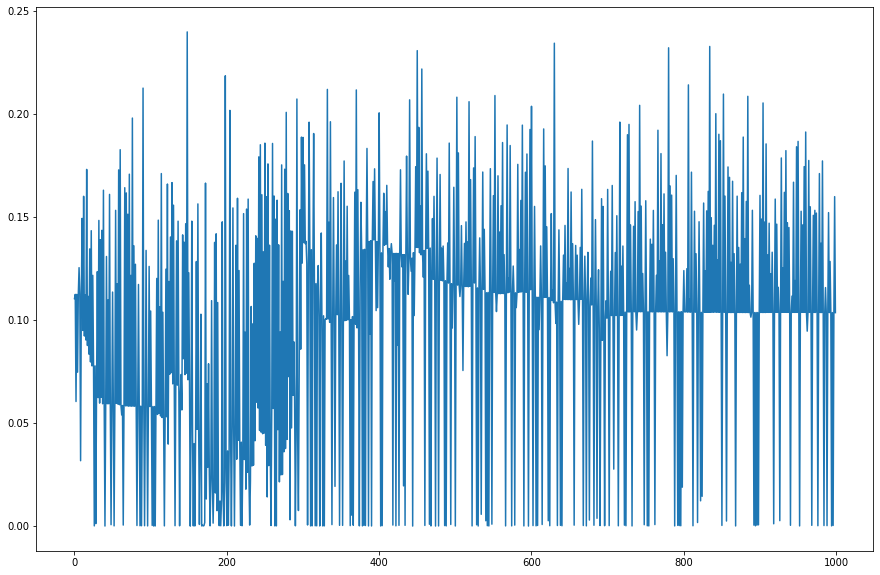

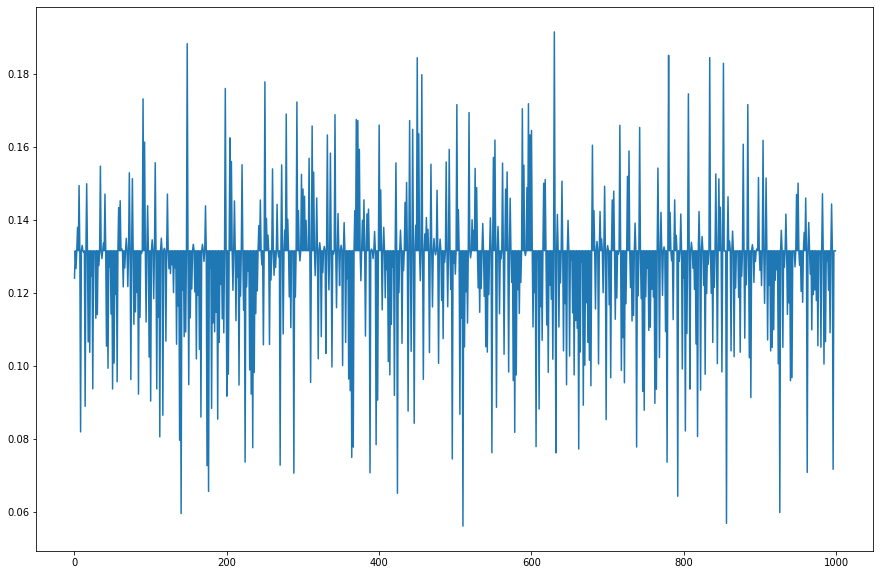

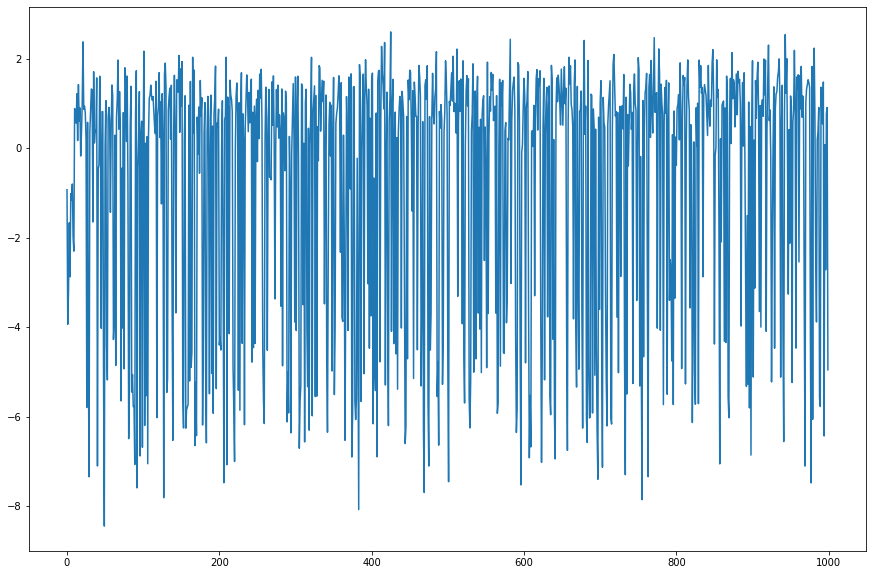

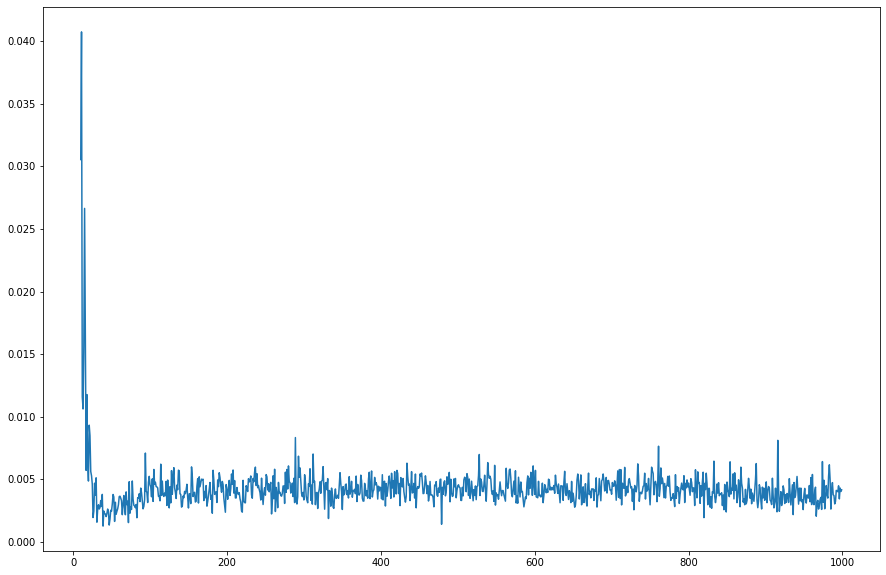

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.8)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

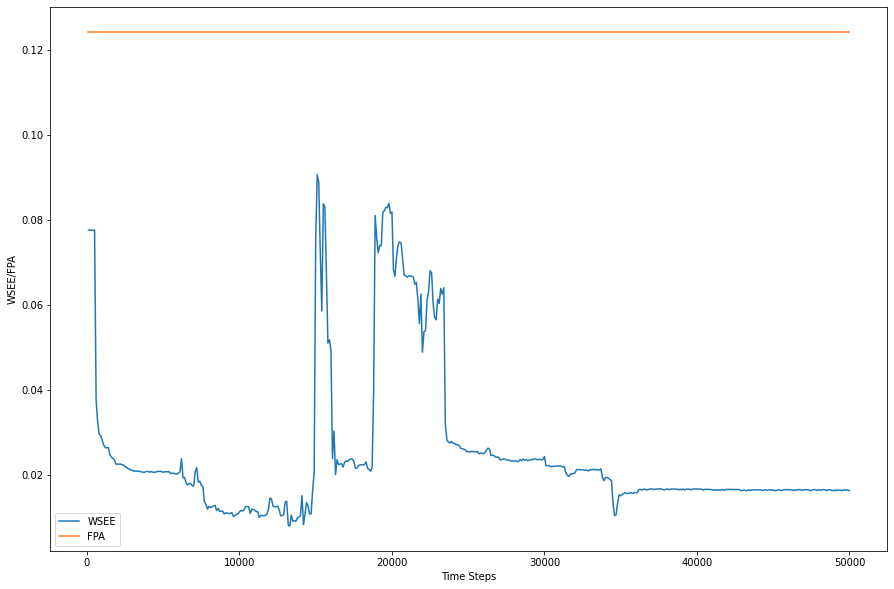

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

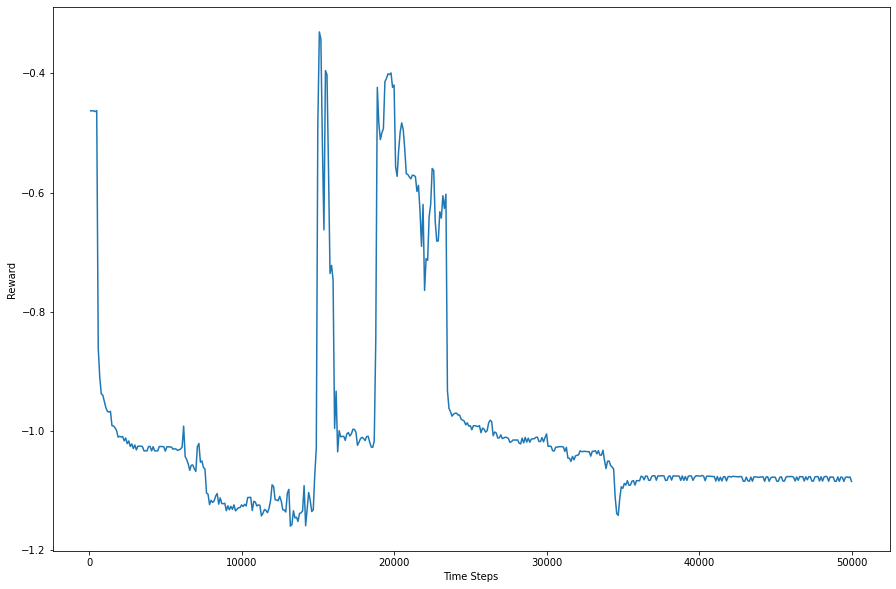

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
